In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch
import numpy as np
import os

# Load dataset
df = pd.read_csv('5c_emotion.csv')
df = df.dropna()
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(data.head())
X = data['text']
y = data['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.astype(str))

# Create Hugging Face dataset
dataset = Dataset.from_pandas(pd.DataFrame({'text': X, 'label': y_encoded}))
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# Load BanglaBERT tokenizer and model
device = torch.device("cuda")
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label_encoder.classes_)

).to(device)

# Tokenize
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    warmup_ratio=0.1,
    gradient_accumulation_steps=2,
    report_to=[]
)

# Metrics
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='weighted')
    }

# Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate()
print(f"\n Evaluation results: {eval_results}")

# Predictions
predictions_output = trainer.predict(dataset['test'])
predictions = np.argmax(predictions_output.predictions, axis=1)
labels = predictions_output.label_ids


c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


            text    label
0  খুবই মজার ছিল    happy
1    এটা ঠিক আছে  neutral
2   খুবই আনন্দিত    happy
3  খুবই মজার ছিল    happy
4  তুমি খুব মজার    happy


c:\Users\USERAS\anaconda3\envs\resPy\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceCla

{'loss': 1.6047, 'learning_rate': 1.0860711376595167e-07, 'epoch': 0.0}


  0%|          | 43/36822 [00:03<35:33, 17.24it/s]

{'loss': 1.59, 'learning_rate': 2.1721422753190334e-07, 'epoch': 0.0}


  0%|          | 63/36822 [00:04<36:21, 16.85it/s]

{'loss': 1.5884, 'learning_rate': 3.2582134129785504e-07, 'epoch': 0.0}


  0%|          | 83/36822 [00:05<35:31, 17.24it/s]

{'loss': 1.5791, 'learning_rate': 4.344284550638067e-07, 'epoch': 0.01}


  0%|          | 103/36822 [00:06<35:29, 17.24it/s]

{'loss': 1.5817, 'learning_rate': 5.430355688297583e-07, 'epoch': 0.01}


  0%|          | 123/36822 [00:07<36:23, 16.81it/s]

{'loss': 1.5767, 'learning_rate': 6.516426825957101e-07, 'epoch': 0.01}


  0%|          | 143/36822 [00:08<34:46, 17.58it/s]

{'loss': 1.5633, 'learning_rate': 7.602497963616617e-07, 'epoch': 0.01}


  0%|          | 163/36822 [00:09<34:38, 17.64it/s]

{'loss': 1.5679, 'learning_rate': 8.688569101276134e-07, 'epoch': 0.01}


  0%|          | 183/36822 [00:11<34:46, 17.56it/s]

{'loss': 1.5502, 'learning_rate': 9.774640238935651e-07, 'epoch': 0.01}


  1%|          | 203/36822 [00:12<34:51, 17.51it/s]

{'loss': 1.5352, 'learning_rate': 1.0860711376595167e-06, 'epoch': 0.02}


  1%|          | 223/36822 [00:13<35:18, 17.28it/s]

{'loss': 1.5241, 'learning_rate': 1.1946782514254684e-06, 'epoch': 0.02}


  1%|          | 243/36822 [00:14<35:41, 17.08it/s]

{'loss': 1.5513, 'learning_rate': 1.3032853651914202e-06, 'epoch': 0.02}


  1%|          | 263/36822 [00:15<36:06, 16.87it/s]

{'loss': 1.5176, 'learning_rate': 1.4118924789573717e-06, 'epoch': 0.02}


  1%|          | 283/36822 [00:16<35:57, 16.93it/s]

{'loss': 1.4828, 'learning_rate': 1.5204995927233235e-06, 'epoch': 0.02}


  1%|          | 303/36822 [00:18<36:10, 16.82it/s]

{'loss': 1.4509, 'learning_rate': 1.6291067064892752e-06, 'epoch': 0.02}


  1%|          | 323/36822 [00:19<36:02, 16.88it/s]

{'loss': 1.4522, 'learning_rate': 1.7377138202552268e-06, 'epoch': 0.03}


  1%|          | 343/36822 [00:20<34:51, 17.44it/s]

{'loss': 1.4348, 'learning_rate': 1.8463209340211785e-06, 'epoch': 0.03}


  1%|          | 363/36822 [00:21<35:11, 17.27it/s]

{'loss': 1.4206, 'learning_rate': 1.9549280477871303e-06, 'epoch': 0.03}


  1%|          | 383/36822 [00:22<34:41, 17.50it/s]

{'loss': 1.3557, 'learning_rate': 2.063535161553082e-06, 'epoch': 0.03}


  1%|          | 403/36822 [00:23<35:23, 17.15it/s]

{'loss': 1.2911, 'learning_rate': 2.1721422753190333e-06, 'epoch': 0.03}


  1%|          | 423/36822 [00:25<34:20, 17.67it/s]

{'loss': 1.2331, 'learning_rate': 2.2807493890849853e-06, 'epoch': 0.03}


  1%|          | 443/36822 [00:26<34:40, 17.48it/s]

{'loss': 1.1954, 'learning_rate': 2.389356502850937e-06, 'epoch': 0.04}


  1%|▏         | 463/36822 [00:27<35:32, 17.05it/s]

{'loss': 1.139, 'learning_rate': 2.4979636166168884e-06, 'epoch': 0.04}


  1%|▏         | 483/36822 [00:28<35:20, 17.14it/s]

{'loss': 1.0905, 'learning_rate': 2.6065707303828403e-06, 'epoch': 0.04}


  1%|▏         | 503/36822 [00:29<34:18, 17.64it/s]

{'loss': 1.0254, 'learning_rate': 2.715177844148792e-06, 'epoch': 0.04}


  1%|▏         | 523/36822 [00:30<34:56, 17.31it/s]

{'loss': 0.932, 'learning_rate': 2.8237849579147434e-06, 'epoch': 0.04}


  1%|▏         | 543/36822 [00:31<34:41, 17.43it/s]

{'loss': 0.9148, 'learning_rate': 2.9323920716806954e-06, 'epoch': 0.04}


  2%|▏         | 563/36822 [00:33<35:40, 16.94it/s]

{'loss': 0.8999, 'learning_rate': 3.040999185446647e-06, 'epoch': 0.05}


  2%|▏         | 583/36822 [00:34<34:34, 17.47it/s]

{'loss': 0.7954, 'learning_rate': 3.1496062992125985e-06, 'epoch': 0.05}


  2%|▏         | 603/36822 [00:35<34:17, 17.60it/s]

{'loss': 0.695, 'learning_rate': 3.2582134129785504e-06, 'epoch': 0.05}


  2%|▏         | 623/36822 [00:36<34:25, 17.52it/s]

{'loss': 0.7701, 'learning_rate': 3.366820526744502e-06, 'epoch': 0.05}


  2%|▏         | 643/36822 [00:37<34:31, 17.46it/s]

{'loss': 0.6259, 'learning_rate': 3.4754276405104535e-06, 'epoch': 0.05}


  2%|▏         | 663/36822 [00:38<33:59, 17.73it/s]

{'loss': 0.5299, 'learning_rate': 3.5840347542764055e-06, 'epoch': 0.05}


  2%|▏         | 683/36822 [00:39<35:22, 17.02it/s]

{'loss': 0.5195, 'learning_rate': 3.692641868042357e-06, 'epoch': 0.06}


  2%|▏         | 703/36822 [00:41<35:32, 16.94it/s]

{'loss': 0.5381, 'learning_rate': 3.8012489818083085e-06, 'epoch': 0.06}


  2%|▏         | 723/36822 [00:42<35:42, 16.85it/s]

{'loss': 0.4616, 'learning_rate': 3.9098560955742605e-06, 'epoch': 0.06}


  2%|▏         | 743/36822 [00:43<36:32, 16.46it/s]

{'loss': 0.4741, 'learning_rate': 4.018463209340212e-06, 'epoch': 0.06}


  2%|▏         | 763/36822 [00:44<35:57, 16.71it/s]

{'loss': 0.4186, 'learning_rate': 4.127070323106164e-06, 'epoch': 0.06}


  2%|▏         | 783/36822 [00:45<36:03, 16.66it/s]

{'loss': 0.3415, 'learning_rate': 4.235677436872115e-06, 'epoch': 0.06}


  2%|▏         | 803/36822 [00:47<34:20, 17.48it/s]

{'loss': 0.3564, 'learning_rate': 4.344284550638067e-06, 'epoch': 0.07}


  2%|▏         | 823/36822 [00:48<34:08, 17.57it/s]

{'loss': 0.418, 'learning_rate': 4.452891664404019e-06, 'epoch': 0.07}


  2%|▏         | 843/36822 [00:49<34:21, 17.45it/s]

{'loss': 0.3096, 'learning_rate': 4.561498778169971e-06, 'epoch': 0.07}


  2%|▏         | 863/36822 [00:50<34:24, 17.42it/s]

{'loss': 0.3849, 'learning_rate': 4.670105891935922e-06, 'epoch': 0.07}


  2%|▏         | 883/36822 [00:51<34:23, 17.41it/s]

{'loss': 0.2703, 'learning_rate': 4.778713005701874e-06, 'epoch': 0.07}


  2%|▏         | 903/36822 [00:52<34:33, 17.32it/s]

{'loss': 0.3188, 'learning_rate': 4.887320119467825e-06, 'epoch': 0.07}


  3%|▎         | 923/36822 [00:53<35:05, 17.05it/s]

{'loss': 0.2534, 'learning_rate': 4.995927233233777e-06, 'epoch': 0.07}


  3%|▎         | 943/36822 [00:55<35:22, 16.91it/s]

{'loss': 0.4019, 'learning_rate': 5.104534346999729e-06, 'epoch': 0.08}


  3%|▎         | 963/36822 [00:56<34:26, 17.36it/s]

{'loss': 0.2861, 'learning_rate': 5.213141460765681e-06, 'epoch': 0.08}


  3%|▎         | 983/36822 [00:57<34:48, 17.16it/s]

{'loss': 0.2642, 'learning_rate': 5.321748574531632e-06, 'epoch': 0.08}


  3%|▎         | 1003/36822 [00:58<34:22, 17.37it/s]

{'loss': 0.3542, 'learning_rate': 5.430355688297584e-06, 'epoch': 0.08}


  3%|▎         | 1023/36822 [00:59<34:05, 17.50it/s]

{'loss': 0.2829, 'learning_rate': 5.538962802063535e-06, 'epoch': 0.08}


  3%|▎         | 1043/36822 [01:00<34:04, 17.50it/s]

{'loss': 0.2227, 'learning_rate': 5.647569915829487e-06, 'epoch': 0.08}


  3%|▎         | 1063/36822 [01:01<33:59, 17.54it/s]

{'loss': 0.2703, 'learning_rate': 5.756177029595439e-06, 'epoch': 0.09}


  3%|▎         | 1083/36822 [01:03<33:41, 17.68it/s]

{'loss': 0.2781, 'learning_rate': 5.864784143361391e-06, 'epoch': 0.09}


  3%|▎         | 1103/36822 [01:04<35:14, 16.89it/s]

{'loss': 0.3287, 'learning_rate': 5.973391257127342e-06, 'epoch': 0.09}


  3%|▎         | 1123/36822 [01:05<34:56, 17.03it/s]

{'loss': 0.253, 'learning_rate': 6.081998370893294e-06, 'epoch': 0.09}


  3%|▎         | 1143/36822 [01:06<35:54, 16.56it/s]

{'loss': 0.2661, 'learning_rate': 6.190605484659245e-06, 'epoch': 0.09}


  3%|▎         | 1163/36822 [01:07<34:58, 17.00it/s]

{'loss': 0.1978, 'learning_rate': 6.299212598425197e-06, 'epoch': 0.09}


  3%|▎         | 1183/36822 [01:08<34:47, 17.07it/s]

{'loss': 0.2005, 'learning_rate': 6.407819712191149e-06, 'epoch': 0.1}


  3%|▎         | 1203/36822 [01:10<35:56, 16.52it/s]

{'loss': 0.1785, 'learning_rate': 6.516426825957101e-06, 'epoch': 0.1}


  3%|▎         | 1223/36822 [01:11<34:07, 17.39it/s]

{'loss': 0.2001, 'learning_rate': 6.625033939723052e-06, 'epoch': 0.1}


  3%|▎         | 1243/36822 [01:12<33:44, 17.57it/s]

{'loss': 0.282, 'learning_rate': 6.733641053489004e-06, 'epoch': 0.1}


  3%|▎         | 1263/36822 [01:13<33:51, 17.51it/s]

{'loss': 0.1801, 'learning_rate': 6.8422481672549555e-06, 'epoch': 0.1}


  3%|▎         | 1283/36822 [01:14<34:02, 17.40it/s]

{'loss': 0.1845, 'learning_rate': 6.950855281020907e-06, 'epoch': 0.1}


  4%|▎         | 1303/36822 [01:15<33:51, 17.48it/s]

{'loss': 0.2356, 'learning_rate': 7.059462394786859e-06, 'epoch': 0.11}


  4%|▎         | 1323/36822 [01:17<34:12, 17.30it/s]

{'loss': 0.2531, 'learning_rate': 7.168069508552811e-06, 'epoch': 0.11}


  4%|▎         | 1343/36822 [01:18<35:32, 16.63it/s]

{'loss': 0.2017, 'learning_rate': 7.2766766223187625e-06, 'epoch': 0.11}


  4%|▎         | 1363/36822 [01:19<34:20, 17.21it/s]

{'loss': 0.3832, 'learning_rate': 7.385283736084714e-06, 'epoch': 0.11}


  4%|▍         | 1383/36822 [01:20<33:30, 17.63it/s]

{'loss': 0.1957, 'learning_rate': 7.4938908498506655e-06, 'epoch': 0.11}


  4%|▍         | 1403/36822 [01:21<34:41, 17.02it/s]

{'loss': 0.2809, 'learning_rate': 7.602497963616617e-06, 'epoch': 0.11}


  4%|▍         | 1423/36822 [01:22<34:08, 17.28it/s]

{'loss': 0.2852, 'learning_rate': 7.711105077382569e-06, 'epoch': 0.12}


  4%|▍         | 1443/36822 [01:23<33:38, 17.52it/s]

{'loss': 0.2103, 'learning_rate': 7.819712191148521e-06, 'epoch': 0.12}


  4%|▍         | 1463/36822 [01:25<33:27, 17.61it/s]

{'loss': 0.2526, 'learning_rate': 7.928319304914472e-06, 'epoch': 0.12}


  4%|▍         | 1483/36822 [01:26<33:43, 17.46it/s]

{'loss': 0.1549, 'learning_rate': 8.036926418680424e-06, 'epoch': 0.12}


  4%|▍         | 1503/36822 [01:27<33:30, 17.57it/s]

{'loss': 0.3175, 'learning_rate': 8.145533532446376e-06, 'epoch': 0.12}


  4%|▍         | 1523/36822 [01:28<33:42, 17.45it/s]

{'loss': 0.2802, 'learning_rate': 8.254140646212327e-06, 'epoch': 0.12}


  4%|▍         | 1543/36822 [01:29<33:59, 17.29it/s]

{'loss': 0.1914, 'learning_rate': 8.36274775997828e-06, 'epoch': 0.13}


  4%|▍         | 1563/36822 [01:30<35:18, 16.64it/s]

{'loss': 0.157, 'learning_rate': 8.47135487374423e-06, 'epoch': 0.13}


  4%|▍         | 1583/36822 [01:32<34:46, 16.89it/s]

{'loss': 0.2912, 'learning_rate': 8.579961987510183e-06, 'epoch': 0.13}


  4%|▍         | 1603/36822 [01:33<35:13, 16.66it/s]

{'loss': 0.2357, 'learning_rate': 8.688569101276133e-06, 'epoch': 0.13}


  4%|▍         | 1623/36822 [01:34<34:53, 16.82it/s]

{'loss': 0.2368, 'learning_rate': 8.797176215042086e-06, 'epoch': 0.13}


  4%|▍         | 1643/36822 [01:35<35:03, 16.72it/s]

{'loss': 0.3005, 'learning_rate': 8.905783328808038e-06, 'epoch': 0.13}


  5%|▍         | 1663/36822 [01:36<33:37, 17.42it/s]

{'loss': 0.1664, 'learning_rate': 9.014390442573989e-06, 'epoch': 0.14}


  5%|▍         | 1683/36822 [01:37<33:36, 17.42it/s]

{'loss': 0.146, 'learning_rate': 9.122997556339941e-06, 'epoch': 0.14}


  5%|▍         | 1703/36822 [01:39<33:35, 17.42it/s]

{'loss': 0.1601, 'learning_rate': 9.231604670105892e-06, 'epoch': 0.14}


  5%|▍         | 1723/36822 [01:40<33:12, 17.61it/s]

{'loss': 0.1452, 'learning_rate': 9.340211783871844e-06, 'epoch': 0.14}


  5%|▍         | 1743/36822 [01:41<33:11, 17.61it/s]

{'loss': 0.2591, 'learning_rate': 9.448818897637797e-06, 'epoch': 0.14}


  5%|▍         | 1763/36822 [01:42<33:16, 17.56it/s]

{'loss': 0.3367, 'learning_rate': 9.557426011403747e-06, 'epoch': 0.14}


  5%|▍         | 1783/36822 [01:43<33:33, 17.40it/s]

{'loss': 0.228, 'learning_rate': 9.6660331251697e-06, 'epoch': 0.15}


  5%|▍         | 1803/36822 [01:44<34:17, 17.02it/s]

{'loss': 0.1522, 'learning_rate': 9.77464023893565e-06, 'epoch': 0.15}


  5%|▍         | 1823/36822 [01:46<34:24, 16.96it/s]

{'loss': 0.2117, 'learning_rate': 9.883247352701603e-06, 'epoch': 0.15}


  5%|▌         | 1843/36822 [01:47<33:56, 17.18it/s]

{'loss': 0.293, 'learning_rate': 9.991854466467553e-06, 'epoch': 0.15}


  5%|▌         | 1863/36822 [01:48<33:30, 17.39it/s]

{'loss': 0.2677, 'learning_rate': 1.0100461580233508e-05, 'epoch': 0.15}


  5%|▌         | 1883/36822 [01:49<33:23, 17.44it/s]

{'loss': 0.2504, 'learning_rate': 1.0209068693999458e-05, 'epoch': 0.15}


  5%|▌         | 1903/36822 [01:50<33:13, 17.52it/s]

{'loss': 0.2671, 'learning_rate': 1.031767580776541e-05, 'epoch': 0.15}


  5%|▌         | 1923/36822 [01:51<33:36, 17.30it/s]

{'loss': 0.2462, 'learning_rate': 1.0426282921531361e-05, 'epoch': 0.16}


  5%|▌         | 1943/36822 [01:52<33:04, 17.58it/s]

{'loss': 0.0965, 'learning_rate': 1.0534890035297314e-05, 'epoch': 0.16}


  5%|▌         | 1963/36822 [01:54<33:39, 17.26it/s]

{'loss': 0.229, 'learning_rate': 1.0643497149063264e-05, 'epoch': 0.16}


  5%|▌         | 1983/36822 [01:55<35:11, 16.50it/s]

{'loss': 0.1868, 'learning_rate': 1.0752104262829217e-05, 'epoch': 0.16}


  5%|▌         | 2003/36822 [01:56<34:32, 16.80it/s]

{'loss': 0.2126, 'learning_rate': 1.0860711376595168e-05, 'epoch': 0.16}


  5%|▌         | 2023/36822 [01:57<34:41, 16.72it/s]

{'loss': 0.1683, 'learning_rate': 1.096931849036112e-05, 'epoch': 0.16}


  6%|▌         | 2043/36822 [01:58<34:15, 16.92it/s]

{'loss': 0.1541, 'learning_rate': 1.107792560412707e-05, 'epoch': 0.17}


  6%|▌         | 2063/36822 [02:00<34:58, 16.57it/s]

{'loss': 0.195, 'learning_rate': 1.1186532717893025e-05, 'epoch': 0.17}


  6%|▌         | 2083/36822 [02:01<33:34, 17.25it/s]

{'loss': 0.2351, 'learning_rate': 1.1295139831658974e-05, 'epoch': 0.17}


  6%|▌         | 2103/36822 [02:02<33:39, 17.20it/s]

{'loss': 0.2413, 'learning_rate': 1.1403746945424928e-05, 'epoch': 0.17}


  6%|▌         | 2123/36822 [02:03<33:01, 17.51it/s]

{'loss': 0.1739, 'learning_rate': 1.1512354059190878e-05, 'epoch': 0.17}


  6%|▌         | 2143/36822 [02:04<33:10, 17.42it/s]

{'loss': 0.2203, 'learning_rate': 1.162096117295683e-05, 'epoch': 0.17}


  6%|▌         | 2163/36822 [02:05<32:58, 17.52it/s]

{'loss': 0.2485, 'learning_rate': 1.1729568286722782e-05, 'epoch': 0.18}


  6%|▌         | 2183/36822 [02:06<33:54, 17.02it/s]

{'loss': 0.2546, 'learning_rate': 1.1838175400488734e-05, 'epoch': 0.18}


  6%|▌         | 2203/36822 [02:08<33:28, 17.24it/s]

{'loss': 0.2246, 'learning_rate': 1.1946782514254685e-05, 'epoch': 0.18}


  6%|▌         | 2223/36822 [02:09<33:47, 17.07it/s]

{'loss': 0.2003, 'learning_rate': 1.2055389628020637e-05, 'epoch': 0.18}


  6%|▌         | 2243/36822 [02:10<32:59, 17.47it/s]

{'loss': 0.1812, 'learning_rate': 1.2163996741786588e-05, 'epoch': 0.18}


  6%|▌         | 2263/36822 [02:11<33:18, 17.29it/s]

{'loss': 0.2558, 'learning_rate': 1.227260385555254e-05, 'epoch': 0.18}


  6%|▌         | 2283/36822 [02:12<34:24, 16.73it/s]

{'loss': 0.274, 'learning_rate': 1.238121096931849e-05, 'epoch': 0.19}


  6%|▋         | 2303/36822 [02:13<32:50, 17.52it/s]

{'loss': 0.1266, 'learning_rate': 1.2489818083084443e-05, 'epoch': 0.19}


  6%|▋         | 2323/36822 [02:15<32:32, 17.67it/s]

{'loss': 0.1979, 'learning_rate': 1.2598425196850394e-05, 'epoch': 0.19}


  6%|▋         | 2343/36822 [02:16<32:59, 17.42it/s]

{'loss': 0.1596, 'learning_rate': 1.2707032310616348e-05, 'epoch': 0.19}


  6%|▋         | 2363/36822 [02:17<32:49, 17.50it/s]

{'loss': 0.1568, 'learning_rate': 1.2815639424382299e-05, 'epoch': 0.19}


  6%|▋         | 2383/36822 [02:18<32:48, 17.49it/s]

{'loss': 0.1544, 'learning_rate': 1.2924246538148251e-05, 'epoch': 0.19}


  7%|▋         | 2403/36822 [02:19<33:35, 17.07it/s]

{'loss': 0.2512, 'learning_rate': 1.3032853651914202e-05, 'epoch': 0.2}


  7%|▋         | 2423/36822 [02:20<33:21, 17.18it/s]

{'loss': 0.2159, 'learning_rate': 1.3141460765680154e-05, 'epoch': 0.2}


  7%|▋         | 2443/36822 [02:21<33:13, 17.25it/s]

{'loss': 0.1517, 'learning_rate': 1.3250067879446105e-05, 'epoch': 0.2}


  7%|▋         | 2463/36822 [02:23<33:48, 16.94it/s]

{'loss': 0.2542, 'learning_rate': 1.3358674993212057e-05, 'epoch': 0.2}


  7%|▋         | 2483/36822 [02:24<33:42, 16.98it/s]

{'loss': 0.1872, 'learning_rate': 1.3467282106978008e-05, 'epoch': 0.2}


  7%|▋         | 2503/36822 [02:25<33:26, 17.10it/s]

{'loss': 0.1369, 'learning_rate': 1.357588922074396e-05, 'epoch': 0.2}


  7%|▋         | 2523/36822 [02:26<32:51, 17.40it/s]

{'loss': 0.2239, 'learning_rate': 1.3684496334509911e-05, 'epoch': 0.21}


  7%|▋         | 2543/36822 [02:27<32:49, 17.41it/s]

{'loss': 0.2127, 'learning_rate': 1.3793103448275863e-05, 'epoch': 0.21}


  7%|▋         | 2563/36822 [02:28<32:29, 17.57it/s]

{'loss': 0.2229, 'learning_rate': 1.3901710562041814e-05, 'epoch': 0.21}


  7%|▋         | 2583/36822 [02:30<32:51, 17.36it/s]

{'loss': 0.2606, 'learning_rate': 1.4010317675807768e-05, 'epoch': 0.21}


  7%|▋         | 2603/36822 [02:31<32:36, 17.49it/s]

{'loss': 0.2735, 'learning_rate': 1.4118924789573719e-05, 'epoch': 0.21}


  7%|▋         | 2623/36822 [02:32<32:46, 17.39it/s]

{'loss': 0.1754, 'learning_rate': 1.4227531903339671e-05, 'epoch': 0.21}


  7%|▋         | 2643/36822 [02:33<33:23, 17.06it/s]

{'loss': 0.2029, 'learning_rate': 1.4336139017105622e-05, 'epoch': 0.22}


  7%|▋         | 2663/36822 [02:34<33:26, 17.02it/s]

{'loss': 0.2102, 'learning_rate': 1.4444746130871574e-05, 'epoch': 0.22}


  7%|▋         | 2683/36822 [02:35<32:23, 17.57it/s]

{'loss': 0.1169, 'learning_rate': 1.4553353244637525e-05, 'epoch': 0.22}


  7%|▋         | 2703/36822 [02:37<33:25, 17.01it/s]

{'loss': 0.1698, 'learning_rate': 1.4661960358403477e-05, 'epoch': 0.22}


  7%|▋         | 2723/36822 [02:38<32:17, 17.60it/s]

{'loss': 0.2328, 'learning_rate': 1.4770567472169428e-05, 'epoch': 0.22}


  7%|▋         | 2743/36822 [02:39<32:23, 17.54it/s]

{'loss': 0.1718, 'learning_rate': 1.487917458593538e-05, 'epoch': 0.22}


  8%|▊         | 2763/36822 [02:40<32:25, 17.51it/s]

{'loss': 0.456, 'learning_rate': 1.4987781699701331e-05, 'epoch': 0.22}


  8%|▊         | 2783/36822 [02:41<32:19, 17.55it/s]

{'loss': 0.302, 'learning_rate': 1.5096388813467283e-05, 'epoch': 0.23}


  8%|▊         | 2803/36822 [02:42<32:16, 17.57it/s]

{'loss': 0.2262, 'learning_rate': 1.5204995927233234e-05, 'epoch': 0.23}


  8%|▊         | 2823/36822 [02:43<32:46, 17.29it/s]

{'loss': 0.2648, 'learning_rate': 1.5313603040999187e-05, 'epoch': 0.23}


  8%|▊         | 2843/36822 [02:45<33:12, 17.05it/s]

{'loss': 0.1921, 'learning_rate': 1.5422210154765137e-05, 'epoch': 0.23}


  8%|▊         | 2863/36822 [02:46<33:57, 16.67it/s]

{'loss': 0.2634, 'learning_rate': 1.553081726853109e-05, 'epoch': 0.23}


  8%|▊         | 2883/36822 [02:47<33:32, 16.87it/s]

{'loss': 0.2176, 'learning_rate': 1.5639424382297042e-05, 'epoch': 0.23}


  8%|▊         | 2903/36822 [02:48<33:35, 16.83it/s]

{'loss': 0.1701, 'learning_rate': 1.5748031496062993e-05, 'epoch': 0.24}


  8%|▊         | 2923/36822 [02:49<33:15, 16.99it/s]

{'loss': 0.218, 'learning_rate': 1.5856638609828943e-05, 'epoch': 0.24}


  8%|▊         | 2943/36822 [02:50<32:30, 17.37it/s]

{'loss': 0.1747, 'learning_rate': 1.5965245723594897e-05, 'epoch': 0.24}


  8%|▊         | 2963/36822 [02:52<32:13, 17.51it/s]

{'loss': 0.2758, 'learning_rate': 1.6073852837360848e-05, 'epoch': 0.24}


  8%|▊         | 2983/36822 [02:53<32:09, 17.54it/s]

{'loss': 0.1411, 'learning_rate': 1.6182459951126802e-05, 'epoch': 0.24}


  8%|▊         | 3003/36822 [02:54<32:14, 17.48it/s]

{'loss': 0.2006, 'learning_rate': 1.6291067064892753e-05, 'epoch': 0.24}


  8%|▊         | 3023/36822 [02:55<32:09, 17.51it/s]

{'loss': 0.2272, 'learning_rate': 1.6399674178658704e-05, 'epoch': 0.25}


  8%|▊         | 3043/36822 [02:56<32:08, 17.51it/s]

{'loss': 0.2051, 'learning_rate': 1.6508281292424654e-05, 'epoch': 0.25}


  8%|▊         | 3063/36822 [02:57<32:45, 17.18it/s]

{'loss': 0.2077, 'learning_rate': 1.661688840619061e-05, 'epoch': 0.25}


  8%|▊         | 3083/36822 [02:58<32:54, 17.09it/s]

{'loss': 0.2239, 'learning_rate': 1.672549551995656e-05, 'epoch': 0.25}


  8%|▊         | 3103/36822 [03:00<32:57, 17.05it/s]

{'loss': 0.1339, 'learning_rate': 1.683410263372251e-05, 'epoch': 0.25}


  8%|▊         | 3123/36822 [03:01<32:17, 17.39it/s]

{'loss': 0.1921, 'learning_rate': 1.694270974748846e-05, 'epoch': 0.25}


  9%|▊         | 3143/36822 [03:02<32:34, 17.23it/s]

{'loss': 0.2814, 'learning_rate': 1.7051316861254415e-05, 'epoch': 0.26}


  9%|▊         | 3163/36822 [03:03<31:49, 17.63it/s]

{'loss': 0.1531, 'learning_rate': 1.7159923975020365e-05, 'epoch': 0.26}


  9%|▊         | 3183/36822 [03:04<31:53, 17.58it/s]

{'loss': 0.1987, 'learning_rate': 1.726853108878632e-05, 'epoch': 0.26}


  9%|▊         | 3203/36822 [03:05<32:02, 17.49it/s]

{'loss': 0.318, 'learning_rate': 1.7377138202552267e-05, 'epoch': 0.26}


  9%|▉         | 3223/36822 [03:07<32:03, 17.47it/s]

{'loss': 0.1324, 'learning_rate': 1.748574531631822e-05, 'epoch': 0.26}


  9%|▉         | 3243/36822 [03:08<31:46, 17.62it/s]

{'loss': 0.1763, 'learning_rate': 1.759435243008417e-05, 'epoch': 0.26}


  9%|▉         | 3263/36822 [03:09<32:13, 17.36it/s]

{'loss': 0.2263, 'learning_rate': 1.7702959543850126e-05, 'epoch': 0.27}


  9%|▉         | 3283/36822 [03:10<32:46, 17.06it/s]

{'loss': 0.1686, 'learning_rate': 1.7811566657616076e-05, 'epoch': 0.27}


  9%|▉         | 3303/36822 [03:11<33:42, 16.58it/s]

{'loss': 0.1874, 'learning_rate': 1.7920173771382027e-05, 'epoch': 0.27}


  9%|▉         | 3323/36822 [03:12<33:21, 16.74it/s]

{'loss': 0.1706, 'learning_rate': 1.8028780885147978e-05, 'epoch': 0.27}


  9%|▉         | 3343/36822 [03:14<34:11, 16.32it/s]

{'loss': 0.2542, 'learning_rate': 1.813738799891393e-05, 'epoch': 0.27}


  9%|▉         | 3363/36822 [03:15<33:28, 16.66it/s]

{'loss': 0.1743, 'learning_rate': 1.8245995112679882e-05, 'epoch': 0.27}


  9%|▉         | 3383/36822 [03:16<31:55, 17.46it/s]

{'loss': 0.2175, 'learning_rate': 1.8354602226445833e-05, 'epoch': 0.28}


  9%|▉         | 3403/36822 [03:17<31:55, 17.44it/s]

{'loss': 0.2568, 'learning_rate': 1.8463209340211784e-05, 'epoch': 0.28}


  9%|▉         | 3423/36822 [03:18<31:56, 17.43it/s]

{'loss': 0.182, 'learning_rate': 1.8571816453977738e-05, 'epoch': 0.28}


  9%|▉         | 3443/36822 [03:19<31:46, 17.51it/s]

{'loss': 0.1153, 'learning_rate': 1.868042356774369e-05, 'epoch': 0.28}


  9%|▉         | 3463/36822 [03:20<31:57, 17.40it/s]

{'loss': 0.1889, 'learning_rate': 1.8789030681509643e-05, 'epoch': 0.28}


  9%|▉         | 3483/36822 [03:22<32:02, 17.34it/s]

{'loss': 0.1732, 'learning_rate': 1.8897637795275593e-05, 'epoch': 0.28}


 10%|▉         | 3503/36822 [03:23<31:56, 17.39it/s]

{'loss': 0.1519, 'learning_rate': 1.9006244909041544e-05, 'epoch': 0.29}


 10%|▉         | 3523/36822 [03:24<32:31, 17.06it/s]

{'loss': 0.1545, 'learning_rate': 1.9114852022807495e-05, 'epoch': 0.29}


 10%|▉         | 3543/36822 [03:25<32:53, 16.86it/s]

{'loss': 0.1669, 'learning_rate': 1.922345913657345e-05, 'epoch': 0.29}


 10%|▉         | 3563/36822 [03:26<31:34, 17.55it/s]

{'loss': 0.2564, 'learning_rate': 1.93320662503394e-05, 'epoch': 0.29}


 10%|▉         | 3583/36822 [03:27<32:04, 17.27it/s]

{'loss': 0.1659, 'learning_rate': 1.944067336410535e-05, 'epoch': 0.29}


 10%|▉         | 3603/36822 [03:29<31:31, 17.57it/s]

{'loss': 0.2433, 'learning_rate': 1.95492804778713e-05, 'epoch': 0.29}


 10%|▉         | 3623/36822 [03:30<31:37, 17.50it/s]

{'loss': 0.2348, 'learning_rate': 1.9657887591637255e-05, 'epoch': 0.29}


 10%|▉         | 3643/36822 [03:31<31:31, 17.54it/s]

{'loss': 0.1651, 'learning_rate': 1.9766494705403206e-05, 'epoch': 0.3}


 10%|▉         | 3663/36822 [03:32<31:21, 17.62it/s]

{'loss': 0.3168, 'learning_rate': 1.987510181916916e-05, 'epoch': 0.3}


 10%|█         | 3683/36822 [03:33<31:21, 17.61it/s]

{'loss': 0.228, 'learning_rate': 1.9983708932935107e-05, 'epoch': 0.3}


 10%|█         | 3701/36822 [03:34<32:54, 16.78it/s]

{'loss': 0.1497, 'learning_rate': 1.9989740185280186e-05, 'epoch': 0.3}


 10%|█         | 3723/36822 [03:35<32:53, 16.77it/s]

{'loss': 0.1341, 'learning_rate': 1.9977669815021575e-05, 'epoch': 0.3}


 10%|█         | 3743/36822 [03:37<32:55, 16.75it/s]

{'loss': 0.1579, 'learning_rate': 1.996559944476297e-05, 'epoch': 0.3}


 10%|█         | 3763/36822 [03:38<32:03, 17.18it/s]

{'loss': 0.1461, 'learning_rate': 1.995352907450436e-05, 'epoch': 0.31}


 10%|█         | 3783/36822 [03:39<32:17, 17.05it/s]

{'loss': 0.247, 'learning_rate': 1.9941458704245754e-05, 'epoch': 0.31}


 10%|█         | 3803/36822 [03:40<31:46, 17.32it/s]

{'loss': 0.1688, 'learning_rate': 1.9929388333987148e-05, 'epoch': 0.31}


 10%|█         | 3823/36822 [03:41<31:36, 17.40it/s]

{'loss': 0.1693, 'learning_rate': 1.991731796372854e-05, 'epoch': 0.31}


 10%|█         | 3843/36822 [03:43<31:37, 17.38it/s]

{'loss': 0.1979, 'learning_rate': 1.990524759346993e-05, 'epoch': 0.31}


 10%|█         | 3863/36822 [03:44<31:27, 17.47it/s]

{'loss': 0.2426, 'learning_rate': 1.9893177223211323e-05, 'epoch': 0.31}


 11%|█         | 3883/36822 [03:45<31:14, 17.57it/s]

{'loss': 0.125, 'learning_rate': 1.9881106852952716e-05, 'epoch': 0.32}


 11%|█         | 3903/36822 [03:46<31:58, 17.15it/s]

{'loss': 0.1051, 'learning_rate': 1.986903648269411e-05, 'epoch': 0.32}


 11%|█         | 3923/36822 [03:47<32:00, 17.13it/s]

{'loss': 0.2011, 'learning_rate': 1.98569661124355e-05, 'epoch': 0.32}


 11%|█         | 3943/36822 [03:48<31:29, 17.40it/s]

{'loss': 0.2479, 'learning_rate': 1.9844895742176892e-05, 'epoch': 0.32}


 11%|█         | 3963/36822 [03:49<31:18, 17.49it/s]

{'loss': 0.1777, 'learning_rate': 1.9832825371918285e-05, 'epoch': 0.32}


 11%|█         | 3983/36822 [03:51<31:29, 17.38it/s]

{'loss': 0.16, 'learning_rate': 1.982075500165968e-05, 'epoch': 0.32}


 11%|█         | 4003/36822 [03:52<32:01, 17.08it/s]

{'loss': 0.1926, 'learning_rate': 1.9808684631401068e-05, 'epoch': 0.33}


 11%|█         | 4023/36822 [03:53<31:16, 17.48it/s]

{'loss': 0.1983, 'learning_rate': 1.979661426114246e-05, 'epoch': 0.33}


 11%|█         | 4043/36822 [03:54<31:04, 17.58it/s]

{'loss': 0.1564, 'learning_rate': 1.9784543890883854e-05, 'epoch': 0.33}


 11%|█         | 4063/36822 [03:55<31:02, 17.59it/s]

{'loss': 0.1587, 'learning_rate': 1.9772473520625247e-05, 'epoch': 0.33}


 11%|█         | 4083/36822 [03:56<31:06, 17.54it/s]

{'loss': 0.3286, 'learning_rate': 1.9760403150366637e-05, 'epoch': 0.33}


 11%|█         | 4103/36822 [03:57<30:49, 17.69it/s]

{'loss': 0.1392, 'learning_rate': 1.974833278010803e-05, 'epoch': 0.33}


 11%|█         | 4123/36822 [03:59<31:52, 17.10it/s]

{'loss': 0.2427, 'learning_rate': 1.9736262409849423e-05, 'epoch': 0.34}


 11%|█▏        | 4143/36822 [04:00<32:14, 16.89it/s]

{'loss': 0.239, 'learning_rate': 1.9724192039590816e-05, 'epoch': 0.34}


 11%|█▏        | 4163/36822 [04:01<32:39, 16.67it/s]

{'loss': 0.1629, 'learning_rate': 1.971212166933221e-05, 'epoch': 0.34}


 11%|█▏        | 4183/36822 [04:02<31:52, 17.07it/s]

{'loss': 0.1731, 'learning_rate': 1.9700051299073602e-05, 'epoch': 0.34}


 11%|█▏        | 4203/36822 [04:03<32:24, 16.77it/s]

{'loss': 0.1914, 'learning_rate': 1.9687980928814995e-05, 'epoch': 0.34}


 11%|█▏        | 4223/36822 [04:04<31:31, 17.24it/s]

{'loss': 0.1237, 'learning_rate': 1.9675910558556385e-05, 'epoch': 0.34}


 12%|█▏        | 4243/36822 [04:06<32:18, 16.80it/s]

{'loss': 0.2102, 'learning_rate': 1.9663840188297778e-05, 'epoch': 0.35}


 12%|█▏        | 4263/36822 [04:07<32:56, 16.48it/s]

{'loss': 0.1413, 'learning_rate': 1.965176981803917e-05, 'epoch': 0.35}


 12%|█▏        | 4283/36822 [04:08<32:09, 16.87it/s]

{'loss': 0.1455, 'learning_rate': 1.9639699447780564e-05, 'epoch': 0.35}


 12%|█▏        | 4303/36822 [04:09<32:11, 16.84it/s]

{'loss': 0.2261, 'learning_rate': 1.9627629077521954e-05, 'epoch': 0.35}


 12%|█▏        | 4323/36822 [04:11<32:56, 16.44it/s]

{'loss': 0.2141, 'learning_rate': 1.9615558707263347e-05, 'epoch': 0.35}


 12%|█▏        | 4343/36822 [04:12<33:21, 16.23it/s]

{'loss': 0.1693, 'learning_rate': 1.960348833700474e-05, 'epoch': 0.35}


 12%|█▏        | 4363/36822 [04:13<32:39, 16.56it/s]

{'loss': 0.1938, 'learning_rate': 1.959141796674613e-05, 'epoch': 0.36}


 12%|█▏        | 4383/36822 [04:14<33:01, 16.37it/s]

{'loss': 0.1157, 'learning_rate': 1.9579347596487523e-05, 'epoch': 0.36}


 12%|█▏        | 4403/36822 [04:15<32:58, 16.39it/s]

{'loss': 0.1925, 'learning_rate': 1.9567277226228916e-05, 'epoch': 0.36}


 12%|█▏        | 4423/36822 [04:17<33:25, 16.15it/s]

{'loss': 0.196, 'learning_rate': 1.955520685597031e-05, 'epoch': 0.36}


 12%|█▏        | 4443/36822 [04:18<32:51, 16.42it/s]

{'loss': 0.2191, 'learning_rate': 1.95431364857117e-05, 'epoch': 0.36}


 12%|█▏        | 4463/36822 [04:19<32:37, 16.53it/s]

{'loss': 0.1596, 'learning_rate': 1.953106611545309e-05, 'epoch': 0.36}


 12%|█▏        | 4483/36822 [04:20<33:20, 16.17it/s]

{'loss': 0.2431, 'learning_rate': 1.9518995745194485e-05, 'epoch': 0.36}


 12%|█▏        | 4503/36822 [04:21<32:44, 16.45it/s]

{'loss': 0.1742, 'learning_rate': 1.9506925374935878e-05, 'epoch': 0.37}


 12%|█▏        | 4523/36822 [04:23<32:27, 16.59it/s]

{'loss': 0.295, 'learning_rate': 1.949485500467727e-05, 'epoch': 0.37}


 12%|█▏        | 4543/36822 [04:24<32:39, 16.48it/s]

{'loss': 0.127, 'learning_rate': 1.9482784634418664e-05, 'epoch': 0.37}


 12%|█▏        | 4563/36822 [04:25<33:45, 15.92it/s]

{'loss': 0.1618, 'learning_rate': 1.9470714264160057e-05, 'epoch': 0.37}


 12%|█▏        | 4583/36822 [04:26<33:24, 16.08it/s]

{'loss': 0.2503, 'learning_rate': 1.9458643893901447e-05, 'epoch': 0.37}


 13%|█▎        | 4603/36822 [04:28<33:33, 16.00it/s]

{'loss': 0.1804, 'learning_rate': 1.944657352364284e-05, 'epoch': 0.37}


 13%|█▎        | 4623/36822 [04:29<35:02, 15.31it/s]

{'loss': 0.2092, 'learning_rate': 1.9434503153384233e-05, 'epoch': 0.38}


 13%|█▎        | 4643/36822 [04:30<34:38, 15.48it/s]

{'loss': 0.1313, 'learning_rate': 1.9422432783125626e-05, 'epoch': 0.38}


 13%|█▎        | 4663/36822 [04:31<35:15, 15.20it/s]

{'loss': 0.1978, 'learning_rate': 1.9410362412867015e-05, 'epoch': 0.38}


 13%|█▎        | 4683/36822 [04:33<34:31, 15.51it/s]

{'loss': 0.213, 'learning_rate': 1.939829204260841e-05, 'epoch': 0.38}


 13%|█▎        | 4703/36822 [04:34<34:07, 15.69it/s]

{'loss': 0.1952, 'learning_rate': 1.93862216723498e-05, 'epoch': 0.38}


 13%|█▎        | 4723/36822 [04:35<33:44, 15.86it/s]

{'loss': 0.1863, 'learning_rate': 1.9374151302091195e-05, 'epoch': 0.38}


 13%|█▎        | 4743/36822 [04:37<34:28, 15.51it/s]

{'loss': 0.1566, 'learning_rate': 1.9362080931832584e-05, 'epoch': 0.39}


 13%|█▎        | 4763/36822 [04:38<32:18, 16.54it/s]

{'loss': 0.184, 'learning_rate': 1.9350010561573977e-05, 'epoch': 0.39}


 13%|█▎        | 4783/36822 [04:39<35:11, 15.17it/s]

{'loss': 0.1611, 'learning_rate': 1.933794019131537e-05, 'epoch': 0.39}


 13%|█▎        | 4803/36822 [04:40<33:14, 16.05it/s]

{'loss': 0.1937, 'learning_rate': 1.9325869821056764e-05, 'epoch': 0.39}


 13%|█▎        | 4823/36822 [04:42<33:34, 15.88it/s]

{'loss': 0.1726, 'learning_rate': 1.9313799450798153e-05, 'epoch': 0.39}


 13%|█▎        | 4843/36822 [04:43<33:25, 15.94it/s]

{'loss': 0.2802, 'learning_rate': 1.9301729080539546e-05, 'epoch': 0.39}


 13%|█▎        | 4863/36822 [04:44<33:29, 15.90it/s]

{'loss': 0.1804, 'learning_rate': 1.928965871028094e-05, 'epoch': 0.4}


 13%|█▎        | 4883/36822 [04:45<33:54, 15.70it/s]

{'loss': 0.2529, 'learning_rate': 1.9277588340022332e-05, 'epoch': 0.4}


 13%|█▎        | 4903/36822 [04:47<34:44, 15.31it/s]

{'loss': 0.229, 'learning_rate': 1.9265517969763725e-05, 'epoch': 0.4}


 13%|█▎        | 4923/36822 [04:48<33:53, 15.69it/s]

{'loss': 0.1976, 'learning_rate': 1.925344759950512e-05, 'epoch': 0.4}


 13%|█▎        | 4943/36822 [04:49<33:22, 15.92it/s]

{'loss': 0.1154, 'learning_rate': 1.9241377229246508e-05, 'epoch': 0.4}


 13%|█▎        | 4963/36822 [04:51<33:53, 15.67it/s]

{'loss': 0.2688, 'learning_rate': 1.92293068589879e-05, 'epoch': 0.4}


 14%|█▎        | 4983/36822 [04:52<34:36, 15.34it/s]

{'loss': 0.1571, 'learning_rate': 1.9217236488729294e-05, 'epoch': 0.41}


 14%|█▎        | 5003/36822 [04:53<34:25, 15.41it/s]

{'loss': 0.2024, 'learning_rate': 1.9205166118470687e-05, 'epoch': 0.41}


 14%|█▎        | 5023/36822 [04:54<31:29, 16.83it/s]

{'loss': 0.1258, 'learning_rate': 1.9193095748212077e-05, 'epoch': 0.41}


 14%|█▎        | 5043/36822 [04:56<33:27, 15.83it/s]

{'loss': 0.1309, 'learning_rate': 1.918102537795347e-05, 'epoch': 0.41}


 14%|█▎        | 5063/36822 [04:57<33:15, 15.91it/s]

{'loss': 0.1989, 'learning_rate': 1.9168955007694863e-05, 'epoch': 0.41}


 14%|█▍        | 5083/36822 [04:58<32:10, 16.44it/s]

{'loss': 0.1341, 'learning_rate': 1.9156884637436256e-05, 'epoch': 0.41}


 14%|█▍        | 5103/36822 [04:59<32:16, 16.38it/s]

{'loss': 0.3137, 'learning_rate': 1.9144814267177646e-05, 'epoch': 0.42}


 14%|█▍        | 5123/36822 [05:00<31:17, 16.88it/s]

{'loss': 0.1303, 'learning_rate': 1.913274389691904e-05, 'epoch': 0.42}


 14%|█▍        | 5143/36822 [05:02<31:50, 16.58it/s]

{'loss': 0.1503, 'learning_rate': 1.9120673526660432e-05, 'epoch': 0.42}


 14%|█▍        | 5163/36822 [05:03<31:16, 16.87it/s]

{'loss': 0.2367, 'learning_rate': 1.9108603156401825e-05, 'epoch': 0.42}


 14%|█▍        | 5183/36822 [05:04<30:44, 17.16it/s]

{'loss': 0.1867, 'learning_rate': 1.9096532786143215e-05, 'epoch': 0.42}


 14%|█▍        | 5203/36822 [05:05<31:35, 16.68it/s]

{'loss': 0.1934, 'learning_rate': 1.9084462415884608e-05, 'epoch': 0.42}


 14%|█▍        | 5223/36822 [05:06<33:12, 15.86it/s]

{'loss': 0.1479, 'learning_rate': 1.9072392045626e-05, 'epoch': 0.43}


 14%|█▍        | 5243/36822 [05:08<31:21, 16.79it/s]

{'loss': 0.2348, 'learning_rate': 1.9060321675367394e-05, 'epoch': 0.43}


 14%|█▍        | 5263/36822 [05:09<32:00, 16.43it/s]

{'loss': 0.1186, 'learning_rate': 1.9048251305108784e-05, 'epoch': 0.43}


 14%|█▍        | 5283/36822 [05:10<31:46, 16.54it/s]

{'loss': 0.2008, 'learning_rate': 1.903618093485018e-05, 'epoch': 0.43}


 14%|█▍        | 5303/36822 [05:11<31:43, 16.56it/s]

{'loss': 0.2463, 'learning_rate': 1.902411056459157e-05, 'epoch': 0.43}


 14%|█▍        | 5323/36822 [05:12<30:47, 17.05it/s]

{'loss': 0.1808, 'learning_rate': 1.9012040194332963e-05, 'epoch': 0.43}


 15%|█▍        | 5343/36822 [05:14<31:02, 16.90it/s]

{'loss': 0.1168, 'learning_rate': 1.8999969824074356e-05, 'epoch': 0.44}


 15%|█▍        | 5363/36822 [05:15<31:36, 16.59it/s]

{'loss': 0.2436, 'learning_rate': 1.898789945381575e-05, 'epoch': 0.44}


 15%|█▍        | 5383/36822 [05:16<31:23, 16.69it/s]

{'loss': 0.1518, 'learning_rate': 1.897582908355714e-05, 'epoch': 0.44}


 15%|█▍        | 5403/36822 [05:17<31:05, 16.84it/s]

{'loss': 0.1691, 'learning_rate': 1.8963758713298532e-05, 'epoch': 0.44}


 15%|█▍        | 5423/36822 [05:18<31:05, 16.83it/s]

{'loss': 0.2418, 'learning_rate': 1.8951688343039925e-05, 'epoch': 0.44}


 15%|█▍        | 5443/36822 [05:20<31:24, 16.65it/s]

{'loss': 0.1444, 'learning_rate': 1.8939617972781318e-05, 'epoch': 0.44}


 15%|█▍        | 5463/36822 [05:21<31:15, 16.72it/s]

{'loss': 0.2874, 'learning_rate': 1.8927547602522708e-05, 'epoch': 0.44}


 15%|█▍        | 5483/36822 [05:22<31:37, 16.52it/s]

{'loss': 0.2539, 'learning_rate': 1.89154772322641e-05, 'epoch': 0.45}


 15%|█▍        | 5503/36822 [05:23<31:11, 16.73it/s]

{'loss': 0.19, 'learning_rate': 1.8903406862005494e-05, 'epoch': 0.45}


 15%|█▍        | 5523/36822 [05:24<31:23, 16.62it/s]

{'loss': 0.1917, 'learning_rate': 1.8891336491746887e-05, 'epoch': 0.45}


 15%|█▌        | 5543/36822 [05:26<31:19, 16.64it/s]

{'loss': 0.2147, 'learning_rate': 1.8879266121488276e-05, 'epoch': 0.45}


 15%|█▌        | 5563/36822 [05:27<30:53, 16.86it/s]

{'loss': 0.1133, 'learning_rate': 1.886719575122967e-05, 'epoch': 0.45}


 15%|█▌        | 5583/36822 [05:28<30:49, 16.89it/s]

{'loss': 0.2022, 'learning_rate': 1.8855125380971063e-05, 'epoch': 0.45}


 15%|█▌        | 5603/36822 [05:29<30:10, 17.25it/s]

{'loss': 0.1646, 'learning_rate': 1.8843055010712456e-05, 'epoch': 0.46}


 15%|█▌        | 5623/36822 [05:30<30:52, 16.84it/s]

{'loss': 0.195, 'learning_rate': 1.8830984640453845e-05, 'epoch': 0.46}


 15%|█▌        | 5643/36822 [05:31<30:19, 17.14it/s]

{'loss': 0.2247, 'learning_rate': 1.881891427019524e-05, 'epoch': 0.46}


 15%|█▌        | 5663/36822 [05:33<30:46, 16.88it/s]

{'loss': 0.14, 'learning_rate': 1.8806843899936635e-05, 'epoch': 0.46}


 15%|█▌        | 5683/36822 [05:34<30:53, 16.80it/s]

{'loss': 0.133, 'learning_rate': 1.8794773529678025e-05, 'epoch': 0.46}


 15%|█▌        | 5703/36822 [05:35<30:56, 16.76it/s]

{'loss': 0.2569, 'learning_rate': 1.8782703159419418e-05, 'epoch': 0.46}


 16%|█▌        | 5723/36822 [05:36<31:30, 16.45it/s]

{'loss': 0.2459, 'learning_rate': 1.877063278916081e-05, 'epoch': 0.47}


 16%|█▌        | 5743/36822 [05:37<31:01, 16.69it/s]

{'loss': 0.2022, 'learning_rate': 1.87585624189022e-05, 'epoch': 0.47}


 16%|█▌        | 5763/36822 [05:39<30:14, 17.12it/s]

{'loss': 0.1482, 'learning_rate': 1.8746492048643593e-05, 'epoch': 0.47}


 16%|█▌        | 5783/36822 [05:40<30:37, 16.90it/s]

{'loss': 0.1658, 'learning_rate': 1.8734421678384986e-05, 'epoch': 0.47}


 16%|█▌        | 5803/36822 [05:41<30:45, 16.81it/s]

{'loss': 0.1431, 'learning_rate': 1.872235130812638e-05, 'epoch': 0.47}


 16%|█▌        | 5823/36822 [05:42<30:53, 16.73it/s]

{'loss': 0.2913, 'learning_rate': 1.871028093786777e-05, 'epoch': 0.47}


 16%|█▌        | 5843/36822 [05:43<30:55, 16.69it/s]

{'loss': 0.1678, 'learning_rate': 1.8698210567609162e-05, 'epoch': 0.48}


 16%|█▌        | 5863/36822 [05:44<30:17, 17.04it/s]

{'loss': 0.1881, 'learning_rate': 1.8686140197350555e-05, 'epoch': 0.48}


 16%|█▌        | 5883/36822 [05:46<30:42, 16.80it/s]

{'loss': 0.237, 'learning_rate': 1.867406982709195e-05, 'epoch': 0.48}


 16%|█▌        | 5903/36822 [05:47<30:11, 17.06it/s]

{'loss': 0.1475, 'learning_rate': 1.8661999456833338e-05, 'epoch': 0.48}


 16%|█▌        | 5923/36822 [05:48<30:33, 16.85it/s]

{'loss': 0.2265, 'learning_rate': 1.864992908657473e-05, 'epoch': 0.48}


 16%|█▌        | 5943/36822 [05:49<31:00, 16.59it/s]

{'loss': 0.192, 'learning_rate': 1.8637858716316124e-05, 'epoch': 0.48}


 16%|█▌        | 5963/36822 [05:50<30:46, 16.72it/s]

{'loss': 0.2345, 'learning_rate': 1.8625788346057517e-05, 'epoch': 0.49}


 16%|█▌        | 5983/36822 [05:52<30:59, 16.58it/s]

{'loss': 0.14, 'learning_rate': 1.8613717975798907e-05, 'epoch': 0.49}


 16%|█▋        | 6003/36822 [05:53<30:38, 16.77it/s]

{'loss': 0.1138, 'learning_rate': 1.86016476055403e-05, 'epoch': 0.49}


 16%|█▋        | 6023/36822 [05:54<30:16, 16.95it/s]

{'loss': 0.224, 'learning_rate': 1.8589577235281693e-05, 'epoch': 0.49}


 16%|█▋        | 6043/36822 [05:55<30:08, 17.02it/s]

{'loss': 0.1631, 'learning_rate': 1.8577506865023086e-05, 'epoch': 0.49}


 16%|█▋        | 6063/36822 [05:56<30:10, 16.99it/s]

{'loss': 0.1684, 'learning_rate': 1.856543649476448e-05, 'epoch': 0.49}


 17%|█▋        | 6083/36822 [05:57<30:26, 16.83it/s]

{'loss': 0.2094, 'learning_rate': 1.8553366124505872e-05, 'epoch': 0.5}


 17%|█▋        | 6103/36822 [05:59<30:39, 16.70it/s]

{'loss': 0.1378, 'learning_rate': 1.8541295754247265e-05, 'epoch': 0.5}


 17%|█▋        | 6123/36822 [06:00<30:37, 16.71it/s]

{'loss': 0.1681, 'learning_rate': 1.8529225383988655e-05, 'epoch': 0.5}


 17%|█▋        | 6143/36822 [06:01<30:58, 16.50it/s]

{'loss': 0.2275, 'learning_rate': 1.8517155013730048e-05, 'epoch': 0.5}


 17%|█▋        | 6163/36822 [06:02<30:19, 16.85it/s]

{'loss': 0.1624, 'learning_rate': 1.850508464347144e-05, 'epoch': 0.5}


 17%|█▋        | 6183/36822 [06:03<30:44, 16.61it/s]

{'loss': 0.131, 'learning_rate': 1.8493014273212834e-05, 'epoch': 0.5}


 17%|█▋        | 6203/36822 [06:05<30:27, 16.75it/s]

{'loss': 0.2554, 'learning_rate': 1.8480943902954224e-05, 'epoch': 0.51}


 17%|█▋        | 6223/36822 [06:06<29:54, 17.05it/s]

{'loss': 0.2173, 'learning_rate': 1.8468873532695617e-05, 'epoch': 0.51}


 17%|█▋        | 6243/36822 [06:07<30:12, 16.87it/s]

{'loss': 0.1618, 'learning_rate': 1.845680316243701e-05, 'epoch': 0.51}


 17%|█▋        | 6263/36822 [06:08<30:28, 16.71it/s]

{'loss': 0.1566, 'learning_rate': 1.8444732792178403e-05, 'epoch': 0.51}


 17%|█▋        | 6283/36822 [06:09<30:01, 16.95it/s]

{'loss': 0.2211, 'learning_rate': 1.8432662421919793e-05, 'epoch': 0.51}


 17%|█▋        | 6303/36822 [06:11<30:11, 16.84it/s]

{'loss': 0.1088, 'learning_rate': 1.8420592051661186e-05, 'epoch': 0.51}


 17%|█▋        | 6323/36822 [06:12<30:24, 16.72it/s]

{'loss': 0.1686, 'learning_rate': 1.840852168140258e-05, 'epoch': 0.51}


 17%|█▋        | 6343/36822 [06:13<30:10, 16.83it/s]

{'loss': 0.2159, 'learning_rate': 1.839645131114397e-05, 'epoch': 0.52}


 17%|█▋        | 6363/36822 [06:14<30:55, 16.42it/s]

{'loss': 0.1349, 'learning_rate': 1.838438094088536e-05, 'epoch': 0.52}


 17%|█▋        | 6383/36822 [06:15<30:52, 16.43it/s]

{'loss': 0.142, 'learning_rate': 1.8372310570626755e-05, 'epoch': 0.52}


 17%|█▋        | 6403/36822 [06:17<30:17, 16.74it/s]

{'loss': 0.1197, 'learning_rate': 1.8360240200368148e-05, 'epoch': 0.52}


 17%|█▋        | 6423/36822 [06:18<30:17, 16.73it/s]

{'loss': 0.2554, 'learning_rate': 1.8348169830109537e-05, 'epoch': 0.52}


 17%|█▋        | 6443/36822 [06:19<30:11, 16.77it/s]

{'loss': 0.2023, 'learning_rate': 1.8336099459850934e-05, 'epoch': 0.52}


 18%|█▊        | 6463/36822 [06:20<30:23, 16.65it/s]

{'loss': 0.1459, 'learning_rate': 1.8324029089592327e-05, 'epoch': 0.53}


 18%|█▊        | 6483/36822 [06:21<30:22, 16.65it/s]

{'loss': 0.1646, 'learning_rate': 1.8311958719333717e-05, 'epoch': 0.53}


 18%|█▊        | 6503/36822 [06:22<29:56, 16.87it/s]

{'loss': 0.1558, 'learning_rate': 1.829988834907511e-05, 'epoch': 0.53}


 18%|█▊        | 6523/36822 [06:24<29:48, 16.94it/s]

{'loss': 0.1709, 'learning_rate': 1.8287817978816503e-05, 'epoch': 0.53}


 18%|█▊        | 6543/36822 [06:25<29:49, 16.92it/s]

{'loss': 0.2576, 'learning_rate': 1.8275747608557896e-05, 'epoch': 0.53}


 18%|█▊        | 6563/36822 [06:26<29:59, 16.82it/s]

{'loss': 0.2468, 'learning_rate': 1.8263677238299285e-05, 'epoch': 0.53}


 18%|█▊        | 6583/36822 [06:27<30:02, 16.78it/s]

{'loss': 0.2075, 'learning_rate': 1.825160686804068e-05, 'epoch': 0.54}


 18%|█▊        | 6603/36822 [06:28<29:35, 17.02it/s]

{'loss': 0.1404, 'learning_rate': 1.823953649778207e-05, 'epoch': 0.54}


 18%|█▊        | 6623/36822 [06:30<30:45, 16.37it/s]

{'loss': 0.1735, 'learning_rate': 1.8227466127523465e-05, 'epoch': 0.54}


 18%|█▊        | 6643/36822 [06:31<30:20, 16.58it/s]

{'loss': 0.2646, 'learning_rate': 1.8215395757264854e-05, 'epoch': 0.54}


 18%|█▊        | 6663/36822 [06:32<30:06, 16.69it/s]

{'loss': 0.1518, 'learning_rate': 1.8203325387006247e-05, 'epoch': 0.54}


 18%|█▊        | 6683/36822 [06:33<29:24, 17.08it/s]

{'loss': 0.1634, 'learning_rate': 1.819125501674764e-05, 'epoch': 0.54}


 18%|█▊        | 6703/36822 [06:34<30:12, 16.62it/s]

{'loss': 0.2617, 'learning_rate': 1.8179184646489034e-05, 'epoch': 0.55}


 18%|█▊        | 6723/36822 [06:36<30:15, 16.57it/s]

{'loss': 0.1173, 'learning_rate': 1.8167114276230423e-05, 'epoch': 0.55}


 18%|█▊        | 6743/36822 [06:37<29:36, 16.93it/s]

{'loss': 0.1181, 'learning_rate': 1.8155043905971816e-05, 'epoch': 0.55}


 18%|█▊        | 6763/36822 [06:38<30:09, 16.62it/s]

{'loss': 0.1624, 'learning_rate': 1.814297353571321e-05, 'epoch': 0.55}


 18%|█▊        | 6783/36822 [06:39<29:53, 16.75it/s]

{'loss': 0.1949, 'learning_rate': 1.8130903165454602e-05, 'epoch': 0.55}


 18%|█▊        | 6803/36822 [06:40<30:20, 16.49it/s]

{'loss': 0.1129, 'learning_rate': 1.8118832795195992e-05, 'epoch': 0.55}


 19%|█▊        | 6823/36822 [06:41<29:56, 16.70it/s]

{'loss': 0.3714, 'learning_rate': 1.810676242493739e-05, 'epoch': 0.56}


 19%|█▊        | 6843/36822 [06:43<29:47, 16.77it/s]

{'loss': 0.2135, 'learning_rate': 1.8094692054678778e-05, 'epoch': 0.56}


 19%|█▊        | 6863/36822 [06:44<29:30, 16.92it/s]

{'loss': 0.207, 'learning_rate': 1.808262168442017e-05, 'epoch': 0.56}


 19%|█▊        | 6883/36822 [06:45<30:18, 16.47it/s]

{'loss': 0.1345, 'learning_rate': 1.8070551314161564e-05, 'epoch': 0.56}


 19%|█▊        | 6903/36822 [06:46<29:30, 16.89it/s]

{'loss': 0.1315, 'learning_rate': 1.8058480943902957e-05, 'epoch': 0.56}


 19%|█▉        | 6923/36822 [06:47<30:00, 16.60it/s]

{'loss': 0.1974, 'learning_rate': 1.8046410573644347e-05, 'epoch': 0.56}


 19%|█▉        | 6943/36822 [06:49<29:48, 16.70it/s]

{'loss': 0.1463, 'learning_rate': 1.803434020338574e-05, 'epoch': 0.57}


 19%|█▉        | 6963/36822 [06:50<29:44, 16.73it/s]

{'loss': 0.2416, 'learning_rate': 1.8022269833127133e-05, 'epoch': 0.57}


 19%|█▉        | 6983/36822 [06:51<29:35, 16.80it/s]

{'loss': 0.2114, 'learning_rate': 1.8010199462868526e-05, 'epoch': 0.57}


 19%|█▉        | 7003/36822 [06:52<29:36, 16.79it/s]

{'loss': 0.164, 'learning_rate': 1.7998129092609916e-05, 'epoch': 0.57}


 19%|█▉        | 7023/36822 [06:53<29:36, 16.77it/s]

{'loss': 0.3201, 'learning_rate': 1.798605872235131e-05, 'epoch': 0.57}


 19%|█▉        | 7043/36822 [06:55<29:41, 16.72it/s]

{'loss': 0.1282, 'learning_rate': 1.7973988352092702e-05, 'epoch': 0.57}


 19%|█▉        | 7063/36822 [06:56<29:39, 16.73it/s]

{'loss': 0.2125, 'learning_rate': 1.7961917981834095e-05, 'epoch': 0.58}


 19%|█▉        | 7083/36822 [06:57<29:30, 16.79it/s]

{'loss': 0.1496, 'learning_rate': 1.7949847611575485e-05, 'epoch': 0.58}


 19%|█▉        | 7103/36822 [06:58<29:13, 16.95it/s]

{'loss': 0.13, 'learning_rate': 1.7937777241316878e-05, 'epoch': 0.58}


 19%|█▉        | 7123/36822 [06:59<29:14, 16.93it/s]

{'loss': 0.1848, 'learning_rate': 1.792570687105827e-05, 'epoch': 0.58}


 19%|█▉        | 7143/36822 [07:00<28:50, 17.15it/s]

{'loss': 0.2074, 'learning_rate': 1.7913636500799664e-05, 'epoch': 0.58}


 19%|█▉        | 7163/36822 [07:02<29:06, 16.98it/s]

{'loss': 0.1999, 'learning_rate': 1.7901566130541054e-05, 'epoch': 0.58}


 20%|█▉        | 7183/36822 [07:03<29:41, 16.63it/s]

{'loss': 0.2071, 'learning_rate': 1.7889495760282447e-05, 'epoch': 0.58}


 20%|█▉        | 7203/36822 [07:04<29:22, 16.80it/s]

{'loss': 0.1625, 'learning_rate': 1.787742539002384e-05, 'epoch': 0.59}


 20%|█▉        | 7223/36822 [07:05<30:08, 16.37it/s]

{'loss': 0.2112, 'learning_rate': 1.7865355019765233e-05, 'epoch': 0.59}


 20%|█▉        | 7243/36822 [07:06<30:05, 16.38it/s]

{'loss': 0.1748, 'learning_rate': 1.7853284649506626e-05, 'epoch': 0.59}


 20%|█▉        | 7263/36822 [07:08<30:27, 16.18it/s]

{'loss': 0.1914, 'learning_rate': 1.784121427924802e-05, 'epoch': 0.59}


 20%|█▉        | 7283/36822 [07:09<29:36, 16.63it/s]

{'loss': 0.2152, 'learning_rate': 1.782914390898941e-05, 'epoch': 0.59}


 20%|█▉        | 7303/36822 [07:10<29:21, 16.75it/s]

{'loss': 0.2565, 'learning_rate': 1.7817073538730802e-05, 'epoch': 0.59}


 20%|█▉        | 7323/36822 [07:11<29:12, 16.83it/s]

{'loss': 0.1812, 'learning_rate': 1.7805003168472195e-05, 'epoch': 0.6}


 20%|█▉        | 7343/36822 [07:12<29:08, 16.86it/s]

{'loss': 0.1464, 'learning_rate': 1.7792932798213588e-05, 'epoch': 0.6}


 20%|█▉        | 7363/36822 [07:14<28:28, 17.25it/s]

{'loss': 0.26, 'learning_rate': 1.7780862427954978e-05, 'epoch': 0.6}


 20%|██        | 7383/36822 [07:15<29:12, 16.80it/s]

{'loss': 0.2651, 'learning_rate': 1.776879205769637e-05, 'epoch': 0.6}


 20%|██        | 7403/36822 [07:16<29:10, 16.81it/s]

{'loss': 0.1436, 'learning_rate': 1.7756721687437764e-05, 'epoch': 0.6}


 20%|██        | 7423/36822 [07:17<28:50, 16.98it/s]

{'loss': 0.1692, 'learning_rate': 1.7744651317179157e-05, 'epoch': 0.6}


 20%|██        | 7443/36822 [07:18<29:23, 16.66it/s]

{'loss': 0.2163, 'learning_rate': 1.7732580946920546e-05, 'epoch': 0.61}


 20%|██        | 7463/36822 [07:20<29:39, 16.50it/s]

{'loss': 0.1799, 'learning_rate': 1.772051057666194e-05, 'epoch': 0.61}


 20%|██        | 7483/36822 [07:21<29:01, 16.85it/s]

{'loss': 0.1367, 'learning_rate': 1.7708440206403333e-05, 'epoch': 0.61}


 20%|██        | 7503/36822 [07:22<29:47, 16.40it/s]

{'loss': 0.2065, 'learning_rate': 1.7696369836144726e-05, 'epoch': 0.61}


 20%|██        | 7523/36822 [07:23<29:02, 16.81it/s]

{'loss': 0.2088, 'learning_rate': 1.7684299465886115e-05, 'epoch': 0.61}


 20%|██        | 7543/36822 [07:24<29:42, 16.42it/s]

{'loss': 0.078, 'learning_rate': 1.767222909562751e-05, 'epoch': 0.61}


 21%|██        | 7563/36822 [07:26<28:32, 17.08it/s]

{'loss': 0.258, 'learning_rate': 1.76601587253689e-05, 'epoch': 0.62}


 21%|██        | 7583/36822 [07:27<28:59, 16.81it/s]

{'loss': 0.1377, 'learning_rate': 1.7648088355110295e-05, 'epoch': 0.62}


 21%|██        | 7603/36822 [07:28<29:24, 16.56it/s]

{'loss': 0.1509, 'learning_rate': 1.7636017984851688e-05, 'epoch': 0.62}


 21%|██        | 7623/36822 [07:29<30:01, 16.20it/s]

{'loss': 0.2248, 'learning_rate': 1.762394761459308e-05, 'epoch': 0.62}


 21%|██        | 7643/36822 [07:30<28:37, 16.99it/s]

{'loss': 0.204, 'learning_rate': 1.7611877244334474e-05, 'epoch': 0.62}


 21%|██        | 7663/36822 [07:31<29:27, 16.50it/s]

{'loss': 0.1974, 'learning_rate': 1.7599806874075863e-05, 'epoch': 0.62}


 21%|██        | 7683/36822 [07:33<29:25, 16.50it/s]

{'loss': 0.1678, 'learning_rate': 1.7587736503817256e-05, 'epoch': 0.63}


 21%|██        | 7703/36822 [07:34<29:21, 16.53it/s]

{'loss': 0.1829, 'learning_rate': 1.757566613355865e-05, 'epoch': 0.63}


 21%|██        | 7723/36822 [07:35<29:02, 16.70it/s]

{'loss': 0.1882, 'learning_rate': 1.756359576330004e-05, 'epoch': 0.63}


 21%|██        | 7743/36822 [07:36<28:58, 16.72it/s]

{'loss': 0.1858, 'learning_rate': 1.7551525393041432e-05, 'epoch': 0.63}


 21%|██        | 7763/36822 [07:37<28:34, 16.95it/s]

{'loss': 0.0991, 'learning_rate': 1.7539455022782825e-05, 'epoch': 0.63}


 21%|██        | 7783/36822 [07:39<28:16, 17.11it/s]

{'loss': 0.2396, 'learning_rate': 1.752738465252422e-05, 'epoch': 0.63}


 21%|██        | 7803/36822 [07:40<28:16, 17.10it/s]

{'loss': 0.2021, 'learning_rate': 1.7515314282265608e-05, 'epoch': 0.64}


 21%|██        | 7823/36822 [07:41<28:38, 16.87it/s]

{'loss': 0.1097, 'learning_rate': 1.7503243912007e-05, 'epoch': 0.64}


 21%|██▏       | 7843/36822 [07:42<28:59, 16.66it/s]

{'loss': 0.1579, 'learning_rate': 1.7491173541748394e-05, 'epoch': 0.64}


 21%|██▏       | 7861/36822 [07:43<28:39, 16.84it/s]

{'loss': 0.2408, 'learning_rate': 1.7479103171489787e-05, 'epoch': 0.64}


 21%|██▏       | 7883/36822 [07:44<28:38, 16.84it/s]

{'loss': 0.2314, 'learning_rate': 1.7467032801231177e-05, 'epoch': 0.64}


 21%|██▏       | 7903/36822 [07:46<28:42, 16.79it/s]

{'loss': 0.137, 'learning_rate': 1.745496243097257e-05, 'epoch': 0.64}


 22%|██▏       | 7923/36822 [07:47<28:37, 16.83it/s]

{'loss': 0.1266, 'learning_rate': 1.7442892060713963e-05, 'epoch': 0.65}


 22%|██▏       | 7943/36822 [07:48<28:50, 16.69it/s]

{'loss': 0.1083, 'learning_rate': 1.7430821690455356e-05, 'epoch': 0.65}


 22%|██▏       | 7963/36822 [07:49<28:27, 16.90it/s]

{'loss': 0.1556, 'learning_rate': 1.741875132019675e-05, 'epoch': 0.65}


 22%|██▏       | 7983/36822 [07:50<29:41, 16.18it/s]

{'loss': 0.3447, 'learning_rate': 1.7406680949938142e-05, 'epoch': 0.65}


 22%|██▏       | 8003/36822 [07:52<28:25, 16.90it/s]

{'loss': 0.2049, 'learning_rate': 1.7394610579679535e-05, 'epoch': 0.65}


 22%|██▏       | 8023/36822 [07:53<28:36, 16.78it/s]

{'loss': 0.1726, 'learning_rate': 1.7382540209420925e-05, 'epoch': 0.65}


 22%|██▏       | 8043/36822 [07:54<28:53, 16.60it/s]

{'loss': 0.2104, 'learning_rate': 1.7370469839162318e-05, 'epoch': 0.66}


 22%|██▏       | 8063/36822 [07:55<28:09, 17.02it/s]

{'loss': 0.1176, 'learning_rate': 1.735839946890371e-05, 'epoch': 0.66}


 22%|██▏       | 8083/36822 [07:56<28:29, 16.82it/s]

{'loss': 0.1477, 'learning_rate': 1.7346329098645104e-05, 'epoch': 0.66}


 22%|██▏       | 8103/36822 [07:58<28:45, 16.64it/s]

{'loss': 0.2085, 'learning_rate': 1.7334258728386494e-05, 'epoch': 0.66}


 22%|██▏       | 8123/36822 [07:59<28:47, 16.62it/s]

{'loss': 0.1714, 'learning_rate': 1.7322188358127887e-05, 'epoch': 0.66}


 22%|██▏       | 8143/36822 [08:00<28:40, 16.67it/s]

{'loss': 0.1816, 'learning_rate': 1.731011798786928e-05, 'epoch': 0.66}


 22%|██▏       | 8163/36822 [08:01<29:18, 16.30it/s]

{'loss': 0.1361, 'learning_rate': 1.7298047617610673e-05, 'epoch': 0.66}


 22%|██▏       | 8183/36822 [08:02<28:08, 16.96it/s]

{'loss': 0.1599, 'learning_rate': 1.7285977247352063e-05, 'epoch': 0.67}


 22%|██▏       | 8203/36822 [08:04<28:56, 16.48it/s]

{'loss': 0.2653, 'learning_rate': 1.7273906877093456e-05, 'epoch': 0.67}


 22%|██▏       | 8223/36822 [08:05<28:40, 16.62it/s]

{'loss': 0.2053, 'learning_rate': 1.726183650683485e-05, 'epoch': 0.67}


 22%|██▏       | 8243/36822 [08:06<27:44, 17.17it/s]

{'loss': 0.2205, 'learning_rate': 1.7249766136576242e-05, 'epoch': 0.67}


 22%|██▏       | 8263/36822 [08:07<28:02, 16.97it/s]

{'loss': 0.1466, 'learning_rate': 1.723769576631763e-05, 'epoch': 0.67}


 22%|██▏       | 8283/36822 [08:08<28:14, 16.85it/s]

{'loss': 0.1606, 'learning_rate': 1.7225625396059025e-05, 'epoch': 0.67}


 23%|██▎       | 8303/36822 [08:09<28:09, 16.88it/s]

{'loss': 0.2008, 'learning_rate': 1.7213555025800418e-05, 'epoch': 0.68}


 23%|██▎       | 8323/36822 [08:11<27:56, 17.00it/s]

{'loss': 0.1684, 'learning_rate': 1.7201484655541807e-05, 'epoch': 0.68}


 23%|██▎       | 8343/36822 [08:12<28:28, 16.66it/s]

{'loss': 0.1358, 'learning_rate': 1.7189414285283204e-05, 'epoch': 0.68}


 23%|██▎       | 8363/36822 [08:13<28:20, 16.73it/s]

{'loss': 0.2422, 'learning_rate': 1.7177343915024597e-05, 'epoch': 0.68}


 23%|██▎       | 8383/36822 [08:14<28:11, 16.82it/s]

{'loss': 0.1747, 'learning_rate': 1.7165273544765987e-05, 'epoch': 0.68}


 23%|██▎       | 8403/36822 [08:15<28:07, 16.84it/s]

{'loss': 0.1773, 'learning_rate': 1.715320317450738e-05, 'epoch': 0.68}


 23%|██▎       | 8423/36822 [08:17<28:02, 16.88it/s]

{'loss': 0.169, 'learning_rate': 1.7141132804248773e-05, 'epoch': 0.69}


 23%|██▎       | 8443/36822 [08:18<28:10, 16.79it/s]

{'loss': 0.1578, 'learning_rate': 1.7129062433990166e-05, 'epoch': 0.69}


 23%|██▎       | 8463/36822 [08:19<27:27, 17.21it/s]

{'loss': 0.1757, 'learning_rate': 1.7116992063731556e-05, 'epoch': 0.69}


 23%|██▎       | 8483/36822 [08:20<27:49, 16.98it/s]

{'loss': 0.1792, 'learning_rate': 1.710492169347295e-05, 'epoch': 0.69}


 23%|██▎       | 8503/36822 [08:21<27:28, 17.18it/s]

{'loss': 0.19, 'learning_rate': 1.709285132321434e-05, 'epoch': 0.69}


 23%|██▎       | 8523/36822 [08:22<27:47, 16.97it/s]

{'loss': 0.1436, 'learning_rate': 1.7080780952955735e-05, 'epoch': 0.69}


 23%|██▎       | 8543/36822 [08:24<27:44, 16.99it/s]

{'loss': 0.2667, 'learning_rate': 1.7068710582697124e-05, 'epoch': 0.7}


 23%|██▎       | 8563/36822 [08:25<27:53, 16.88it/s]

{'loss': 0.1488, 'learning_rate': 1.7056640212438517e-05, 'epoch': 0.7}


 23%|██▎       | 8583/36822 [08:26<27:38, 17.03it/s]

{'loss': 0.2915, 'learning_rate': 1.704456984217991e-05, 'epoch': 0.7}


 23%|██▎       | 8603/36822 [08:27<28:22, 16.57it/s]

{'loss': 0.1533, 'learning_rate': 1.7032499471921304e-05, 'epoch': 0.7}


 23%|██▎       | 8623/36822 [08:28<27:56, 16.82it/s]

{'loss': 0.1314, 'learning_rate': 1.7020429101662693e-05, 'epoch': 0.7}


 23%|██▎       | 8643/36822 [08:30<28:40, 16.38it/s]

{'loss': 0.3698, 'learning_rate': 1.7008358731404086e-05, 'epoch': 0.7}


 24%|██▎       | 8663/36822 [08:31<27:36, 17.00it/s]

{'loss': 0.2225, 'learning_rate': 1.699628836114548e-05, 'epoch': 0.71}


 24%|██▎       | 8683/36822 [08:32<27:29, 17.06it/s]

{'loss': 0.1574, 'learning_rate': 1.6984217990886872e-05, 'epoch': 0.71}


 24%|██▎       | 8703/36822 [08:33<27:57, 16.76it/s]

{'loss': 0.2124, 'learning_rate': 1.6972147620628262e-05, 'epoch': 0.71}


 24%|██▎       | 8723/36822 [08:34<27:44, 16.88it/s]

{'loss': 0.1583, 'learning_rate': 1.696007725036966e-05, 'epoch': 0.71}


 24%|██▎       | 8743/36822 [08:35<27:32, 16.99it/s]

{'loss': 0.1031, 'learning_rate': 1.6948006880111048e-05, 'epoch': 0.71}


 24%|██▍       | 8763/36822 [08:37<27:50, 16.80it/s]

{'loss': 0.1366, 'learning_rate': 1.693593650985244e-05, 'epoch': 0.71}


 24%|██▍       | 8783/36822 [08:38<28:07, 16.62it/s]

{'loss': 0.1875, 'learning_rate': 1.6923866139593834e-05, 'epoch': 0.72}


 24%|██▍       | 8803/36822 [08:39<28:15, 16.53it/s]

{'loss': 0.2239, 'learning_rate': 1.6911795769335227e-05, 'epoch': 0.72}


 24%|██▍       | 8823/36822 [08:40<28:02, 16.64it/s]

{'loss': 0.193, 'learning_rate': 1.6899725399076617e-05, 'epoch': 0.72}


 24%|██▍       | 8843/36822 [08:41<27:49, 16.76it/s]

{'loss': 0.222, 'learning_rate': 1.688765502881801e-05, 'epoch': 0.72}


 24%|██▍       | 8863/36822 [08:43<27:28, 16.96it/s]

{'loss': 0.2543, 'learning_rate': 1.6875584658559403e-05, 'epoch': 0.72}


 24%|██▍       | 8883/36822 [08:44<27:16, 17.07it/s]

{'loss': 0.1889, 'learning_rate': 1.6863514288300796e-05, 'epoch': 0.72}


 24%|██▍       | 8903/36822 [08:45<27:10, 17.13it/s]

{'loss': 0.1393, 'learning_rate': 1.6851443918042186e-05, 'epoch': 0.73}


 24%|██▍       | 8923/36822 [08:46<28:02, 16.58it/s]

{'loss': 0.3007, 'learning_rate': 1.683937354778358e-05, 'epoch': 0.73}


 24%|██▍       | 8943/36822 [08:47<27:31, 16.88it/s]

{'loss': 0.1345, 'learning_rate': 1.6827303177524972e-05, 'epoch': 0.73}


 24%|██▍       | 8963/36822 [08:49<27:28, 16.90it/s]

{'loss': 0.2457, 'learning_rate': 1.6815232807266365e-05, 'epoch': 0.73}


 24%|██▍       | 8983/36822 [08:50<27:37, 16.79it/s]

{'loss': 0.2538, 'learning_rate': 1.6803162437007755e-05, 'epoch': 0.73}


 24%|██▍       | 9003/36822 [08:51<27:19, 16.97it/s]

{'loss': 0.2236, 'learning_rate': 1.6791092066749148e-05, 'epoch': 0.73}


 25%|██▍       | 9023/36822 [08:52<27:50, 16.64it/s]

{'loss': 0.0689, 'learning_rate': 1.677902169649054e-05, 'epoch': 0.73}


 25%|██▍       | 9043/36822 [08:53<27:23, 16.90it/s]

{'loss': 0.2096, 'learning_rate': 1.6766951326231934e-05, 'epoch': 0.74}


 25%|██▍       | 9063/36822 [08:54<27:35, 16.76it/s]

{'loss': 0.2966, 'learning_rate': 1.6754880955973324e-05, 'epoch': 0.74}


 25%|██▍       | 9083/36822 [08:56<27:49, 16.62it/s]

{'loss': 0.144, 'learning_rate': 1.6742810585714717e-05, 'epoch': 0.74}


 25%|██▍       | 9103/36822 [08:57<27:40, 16.70it/s]

{'loss': 0.1532, 'learning_rate': 1.673074021545611e-05, 'epoch': 0.74}


 25%|██▍       | 9123/36822 [08:58<27:57, 16.51it/s]

{'loss': 0.2357, 'learning_rate': 1.6718669845197503e-05, 'epoch': 0.74}


 25%|██▍       | 9143/36822 [08:59<27:24, 16.83it/s]

{'loss': 0.1554, 'learning_rate': 1.6706599474938896e-05, 'epoch': 0.74}


 25%|██▍       | 9163/36822 [09:00<27:36, 16.70it/s]

{'loss': 0.2078, 'learning_rate': 1.669452910468029e-05, 'epoch': 0.75}


 25%|██▍       | 9183/36822 [09:02<27:24, 16.81it/s]

{'loss': 0.1742, 'learning_rate': 1.668245873442168e-05, 'epoch': 0.75}


 25%|██▍       | 9203/36822 [09:03<27:07, 16.97it/s]

{'loss': 0.1934, 'learning_rate': 1.6670388364163072e-05, 'epoch': 0.75}


 25%|██▌       | 9223/36822 [09:04<27:25, 16.77it/s]

{'loss': 0.2226, 'learning_rate': 1.6658317993904465e-05, 'epoch': 0.75}


 25%|██▌       | 9243/36822 [09:05<27:47, 16.54it/s]

{'loss': 0.1758, 'learning_rate': 1.6646247623645858e-05, 'epoch': 0.75}


 25%|██▌       | 9263/36822 [09:06<27:17, 16.83it/s]

{'loss': 0.1902, 'learning_rate': 1.6634177253387248e-05, 'epoch': 0.75}


 25%|██▌       | 9283/36822 [09:07<26:51, 17.09it/s]

{'loss': 0.231, 'learning_rate': 1.662210688312864e-05, 'epoch': 0.76}


 25%|██▌       | 9303/36822 [09:09<26:58, 17.00it/s]

{'loss': 0.2223, 'learning_rate': 1.6610036512870034e-05, 'epoch': 0.76}


 25%|██▌       | 9323/36822 [09:10<27:09, 16.88it/s]

{'loss': 0.1635, 'learning_rate': 1.6597966142611427e-05, 'epoch': 0.76}


 25%|██▌       | 9343/36822 [09:11<26:41, 17.16it/s]

{'loss': 0.12, 'learning_rate': 1.6585895772352817e-05, 'epoch': 0.76}


 25%|██▌       | 9363/36822 [09:12<27:03, 16.91it/s]

{'loss': 0.1961, 'learning_rate': 1.657382540209421e-05, 'epoch': 0.76}


 25%|██▌       | 9383/36822 [09:13<27:05, 16.88it/s]

{'loss': 0.115, 'learning_rate': 1.6561755031835603e-05, 'epoch': 0.76}


 26%|██▌       | 9403/36822 [09:15<27:14, 16.78it/s]

{'loss': 0.1701, 'learning_rate': 1.6549684661576996e-05, 'epoch': 0.77}


 26%|██▌       | 9423/36822 [09:16<27:05, 16.85it/s]

{'loss': 0.1185, 'learning_rate': 1.6537614291318385e-05, 'epoch': 0.77}


 26%|██▌       | 9443/36822 [09:17<26:51, 16.99it/s]

{'loss': 0.1846, 'learning_rate': 1.652554392105978e-05, 'epoch': 0.77}


 26%|██▌       | 9463/36822 [09:18<26:50, 16.99it/s]

{'loss': 0.1075, 'learning_rate': 1.651347355080117e-05, 'epoch': 0.77}


 26%|██▌       | 9483/36822 [09:19<27:02, 16.85it/s]

{'loss': 0.279, 'learning_rate': 1.6501403180542565e-05, 'epoch': 0.77}


 26%|██▌       | 9503/36822 [09:20<26:46, 17.00it/s]

{'loss': 0.0807, 'learning_rate': 1.6489332810283958e-05, 'epoch': 0.77}


 26%|██▌       | 9523/36822 [09:22<27:10, 16.74it/s]

{'loss': 0.2309, 'learning_rate': 1.647726244002535e-05, 'epoch': 0.78}


 26%|██▌       | 9543/36822 [09:23<27:19, 16.64it/s]

{'loss': 0.1557, 'learning_rate': 1.6465192069766744e-05, 'epoch': 0.78}


 26%|██▌       | 9563/36822 [09:24<26:50, 16.93it/s]

{'loss': 0.133, 'learning_rate': 1.6453121699508133e-05, 'epoch': 0.78}


 26%|██▌       | 9583/36822 [09:25<27:22, 16.58it/s]

{'loss': 0.2059, 'learning_rate': 1.6441051329249527e-05, 'epoch': 0.78}


 26%|██▌       | 9603/36822 [09:26<27:26, 16.53it/s]

{'loss': 0.1739, 'learning_rate': 1.642898095899092e-05, 'epoch': 0.78}


 26%|██▌       | 9623/36822 [09:28<27:18, 16.60it/s]

{'loss': 0.152, 'learning_rate': 1.6416910588732313e-05, 'epoch': 0.78}


 26%|██▌       | 9643/36822 [09:29<26:55, 16.82it/s]

{'loss': 0.2743, 'learning_rate': 1.6404840218473702e-05, 'epoch': 0.79}


 26%|██▌       | 9663/36822 [09:30<27:01, 16.75it/s]

{'loss': 0.2143, 'learning_rate': 1.6392769848215095e-05, 'epoch': 0.79}


 26%|██▋       | 9683/36822 [09:31<27:10, 16.64it/s]

{'loss': 0.1499, 'learning_rate': 1.638069947795649e-05, 'epoch': 0.79}


 26%|██▋       | 9703/36822 [09:32<27:20, 16.53it/s]

{'loss': 0.1687, 'learning_rate': 1.6368629107697878e-05, 'epoch': 0.79}


 26%|██▋       | 9723/36822 [09:34<26:44, 16.89it/s]

{'loss': 0.1797, 'learning_rate': 1.635655873743927e-05, 'epoch': 0.79}


 26%|██▋       | 9743/36822 [09:35<26:36, 16.96it/s]

{'loss': 0.3516, 'learning_rate': 1.6344488367180664e-05, 'epoch': 0.79}


 27%|██▋       | 9763/36822 [09:36<26:45, 16.86it/s]

{'loss': 0.1787, 'learning_rate': 1.6332417996922057e-05, 'epoch': 0.8}


 27%|██▋       | 9783/36822 [09:37<26:34, 16.96it/s]

{'loss': 0.2158, 'learning_rate': 1.6320347626663447e-05, 'epoch': 0.8}


 27%|██▋       | 9803/36822 [09:38<26:33, 16.95it/s]

{'loss': 0.1245, 'learning_rate': 1.630827725640484e-05, 'epoch': 0.8}


 27%|██▋       | 9823/36822 [09:39<26:35, 16.92it/s]

{'loss': 0.2011, 'learning_rate': 1.6296206886146233e-05, 'epoch': 0.8}


 27%|██▋       | 9843/36822 [09:41<26:28, 16.98it/s]

{'loss': 0.1576, 'learning_rate': 1.6284136515887626e-05, 'epoch': 0.8}


 27%|██▋       | 9863/36822 [09:42<26:41, 16.84it/s]

{'loss': 0.1779, 'learning_rate': 1.6272066145629016e-05, 'epoch': 0.8}


 27%|██▋       | 9883/36822 [09:43<27:19, 16.43it/s]

{'loss': 0.152, 'learning_rate': 1.6259995775370412e-05, 'epoch': 0.8}


 27%|██▋       | 9903/36822 [09:44<26:53, 16.69it/s]

{'loss': 0.2191, 'learning_rate': 1.6247925405111805e-05, 'epoch': 0.81}


 27%|██▋       | 9923/36822 [09:45<26:37, 16.84it/s]

{'loss': 0.2383, 'learning_rate': 1.6235855034853195e-05, 'epoch': 0.81}


 27%|██▋       | 9943/36822 [09:47<26:53, 16.66it/s]

{'loss': 0.1356, 'learning_rate': 1.6223784664594588e-05, 'epoch': 0.81}


 27%|██▋       | 9963/36822 [09:48<26:55, 16.63it/s]

{'loss': 0.2026, 'learning_rate': 1.621171429433598e-05, 'epoch': 0.81}


 27%|██▋       | 9983/36822 [09:49<26:30, 16.88it/s]

{'loss': 0.1822, 'learning_rate': 1.6199643924077374e-05, 'epoch': 0.81}


 27%|██▋       | 10003/36822 [09:50<26:16, 17.01it/s]

{'loss': 0.1472, 'learning_rate': 1.6187573553818764e-05, 'epoch': 0.81}


 27%|██▋       | 10023/36822 [09:51<25:51, 17.27it/s]

{'loss': 0.1878, 'learning_rate': 1.6175503183560157e-05, 'epoch': 0.82}


 27%|██▋       | 10043/36822 [09:52<26:14, 17.01it/s]

{'loss': 0.1504, 'learning_rate': 1.616343281330155e-05, 'epoch': 0.82}


 27%|██▋       | 10063/36822 [09:54<25:47, 17.30it/s]

{'loss': 0.3201, 'learning_rate': 1.6151362443042943e-05, 'epoch': 0.82}


 27%|██▋       | 10083/36822 [09:55<28:00, 15.91it/s]

{'loss': 0.1492, 'learning_rate': 1.6139292072784333e-05, 'epoch': 0.82}


 27%|██▋       | 10103/36822 [09:56<28:02, 15.88it/s]

{'loss': 0.1234, 'learning_rate': 1.6127221702525726e-05, 'epoch': 0.82}


 27%|██▋       | 10123/36822 [09:57<27:39, 16.09it/s]

{'loss': 0.1623, 'learning_rate': 1.611515133226712e-05, 'epoch': 0.82}


 28%|██▊       | 10143/36822 [09:59<27:09, 16.37it/s]

{'loss': 0.1771, 'learning_rate': 1.6103080962008512e-05, 'epoch': 0.83}


 28%|██▊       | 10163/36822 [10:00<27:41, 16.05it/s]

{'loss': 0.1199, 'learning_rate': 1.6091010591749902e-05, 'epoch': 0.83}


 28%|██▊       | 10183/36822 [10:01<26:55, 16.49it/s]

{'loss': 0.1752, 'learning_rate': 1.6078940221491295e-05, 'epoch': 0.83}


 28%|██▊       | 10203/36822 [10:02<26:16, 16.88it/s]

{'loss': 0.2557, 'learning_rate': 1.6066869851232688e-05, 'epoch': 0.83}


 28%|██▊       | 10223/36822 [10:03<26:06, 16.98it/s]

{'loss': 0.1848, 'learning_rate': 1.605479948097408e-05, 'epoch': 0.83}


 28%|██▊       | 10243/36822 [10:05<26:26, 16.76it/s]

{'loss': 0.1832, 'learning_rate': 1.604272911071547e-05, 'epoch': 0.83}


 28%|██▊       | 10263/36822 [10:06<25:40, 17.24it/s]

{'loss': 0.188, 'learning_rate': 1.6030658740456867e-05, 'epoch': 0.84}


 28%|██▊       | 10283/36822 [10:07<25:30, 17.34it/s]

{'loss': 0.1814, 'learning_rate': 1.6018588370198257e-05, 'epoch': 0.84}


 28%|██▊       | 10303/36822 [10:08<25:33, 17.29it/s]

{'loss': 0.1496, 'learning_rate': 1.600651799993965e-05, 'epoch': 0.84}


 28%|██▊       | 10323/36822 [10:09<25:16, 17.47it/s]

{'loss': 0.1729, 'learning_rate': 1.5994447629681043e-05, 'epoch': 0.84}


 28%|██▊       | 10343/36822 [10:10<26:17, 16.78it/s]

{'loss': 0.1299, 'learning_rate': 1.5982377259422436e-05, 'epoch': 0.84}


 28%|██▊       | 10363/36822 [10:12<25:18, 17.42it/s]

{'loss': 0.0889, 'learning_rate': 1.5970306889163826e-05, 'epoch': 0.84}


 28%|██▊       | 10383/36822 [10:13<25:40, 17.16it/s]

{'loss': 0.1833, 'learning_rate': 1.595823651890522e-05, 'epoch': 0.85}


 28%|██▊       | 10403/36822 [10:14<25:01, 17.59it/s]

{'loss': 0.2234, 'learning_rate': 1.5946166148646612e-05, 'epoch': 0.85}


 28%|██▊       | 10423/36822 [10:15<24:53, 17.67it/s]

{'loss': 0.1445, 'learning_rate': 1.5934095778388005e-05, 'epoch': 0.85}


 28%|██▊       | 10443/36822 [10:16<25:11, 17.46it/s]

{'loss': 0.2328, 'learning_rate': 1.5922025408129394e-05, 'epoch': 0.85}


 28%|██▊       | 10463/36822 [10:17<24:51, 17.68it/s]

{'loss': 0.271, 'learning_rate': 1.5909955037870788e-05, 'epoch': 0.85}


 28%|██▊       | 10483/36822 [10:18<24:46, 17.72it/s]

{'loss': 0.1653, 'learning_rate': 1.589788466761218e-05, 'epoch': 0.85}


 29%|██▊       | 10503/36822 [10:20<25:07, 17.45it/s]

{'loss': 0.3093, 'learning_rate': 1.5885814297353574e-05, 'epoch': 0.86}


 29%|██▊       | 10523/36822 [10:21<25:37, 17.11it/s]

{'loss': 0.2081, 'learning_rate': 1.5873743927094963e-05, 'epoch': 0.86}


 29%|██▊       | 10543/36822 [10:22<25:52, 16.92it/s]

{'loss': 0.1758, 'learning_rate': 1.5861673556836356e-05, 'epoch': 0.86}


 29%|██▊       | 10563/36822 [10:23<24:57, 17.53it/s]

{'loss': 0.1682, 'learning_rate': 1.584960318657775e-05, 'epoch': 0.86}


 29%|██▊       | 10583/36822 [10:24<24:50, 17.60it/s]

{'loss': 0.0921, 'learning_rate': 1.5837532816319143e-05, 'epoch': 0.86}


 29%|██▉       | 10603/36822 [10:25<24:55, 17.53it/s]

{'loss': 0.1776, 'learning_rate': 1.5825462446060532e-05, 'epoch': 0.86}


 29%|██▉       | 10623/36822 [10:26<25:09, 17.35it/s]

{'loss': 0.147, 'learning_rate': 1.5813392075801925e-05, 'epoch': 0.87}


 29%|██▉       | 10643/36822 [10:28<24:45, 17.63it/s]

{'loss': 0.1389, 'learning_rate': 1.580132170554332e-05, 'epoch': 0.87}


 29%|██▉       | 10663/36822 [10:29<24:46, 17.59it/s]

{'loss': 0.2226, 'learning_rate': 1.578925133528471e-05, 'epoch': 0.87}


 29%|██▉       | 10683/36822 [10:30<24:39, 17.67it/s]

{'loss': 0.1767, 'learning_rate': 1.5777180965026104e-05, 'epoch': 0.87}


 29%|██▉       | 10703/36822 [10:31<24:35, 17.70it/s]

{'loss': 0.1767, 'learning_rate': 1.5765110594767498e-05, 'epoch': 0.87}


 29%|██▉       | 10723/36822 [10:32<25:23, 17.13it/s]

{'loss': 0.1317, 'learning_rate': 1.5753040224508887e-05, 'epoch': 0.87}


 29%|██▉       | 10743/36822 [10:33<25:30, 17.04it/s]

{'loss': 0.1705, 'learning_rate': 1.574096985425028e-05, 'epoch': 0.88}


 29%|██▉       | 10763/36822 [10:34<25:01, 17.35it/s]

{'loss': 0.1513, 'learning_rate': 1.5728899483991673e-05, 'epoch': 0.88}


 29%|██▉       | 10783/36822 [10:36<25:44, 16.86it/s]

{'loss': 0.1146, 'learning_rate': 1.5716829113733066e-05, 'epoch': 0.88}


 29%|██▉       | 10803/36822 [10:37<25:46, 16.83it/s]

{'loss': 0.1716, 'learning_rate': 1.5704758743474456e-05, 'epoch': 0.88}


 29%|██▉       | 10823/36822 [10:38<26:10, 16.56it/s]

{'loss': 0.199, 'learning_rate': 1.569268837321585e-05, 'epoch': 0.88}


 29%|██▉       | 10843/36822 [10:39<24:35, 17.61it/s]

{'loss': 0.2084, 'learning_rate': 1.5680618002957242e-05, 'epoch': 0.88}


 30%|██▉       | 10863/36822 [10:40<24:43, 17.49it/s]

{'loss': 0.1259, 'learning_rate': 1.5668547632698635e-05, 'epoch': 0.88}


 30%|██▉       | 10883/36822 [10:41<24:42, 17.50it/s]

{'loss': 0.178, 'learning_rate': 1.5656477262440025e-05, 'epoch': 0.89}


 30%|██▉       | 10903/36822 [10:43<24:50, 17.38it/s]

{'loss': 0.1979, 'learning_rate': 1.5644406892181418e-05, 'epoch': 0.89}


 30%|██▉       | 10923/36822 [10:44<24:27, 17.64it/s]

{'loss': 0.2098, 'learning_rate': 1.563233652192281e-05, 'epoch': 0.89}


 30%|██▉       | 10943/36822 [10:45<24:55, 17.30it/s]

{'loss': 0.1849, 'learning_rate': 1.5620266151664204e-05, 'epoch': 0.89}


 30%|██▉       | 10963/36822 [10:46<24:33, 17.55it/s]

{'loss': 0.1515, 'learning_rate': 1.5608195781405594e-05, 'epoch': 0.89}


 30%|██▉       | 10983/36822 [10:47<25:04, 17.17it/s]

{'loss': 0.2791, 'learning_rate': 1.5596125411146987e-05, 'epoch': 0.89}


 30%|██▉       | 11003/36822 [10:48<24:38, 17.47it/s]

{'loss': 0.0999, 'learning_rate': 1.558405504088838e-05, 'epoch': 0.9}


 30%|██▉       | 11023/36822 [10:49<24:54, 17.27it/s]

{'loss': 0.1575, 'learning_rate': 1.5571984670629773e-05, 'epoch': 0.9}


 30%|██▉       | 11043/36822 [10:51<24:25, 17.59it/s]

{'loss': 0.2167, 'learning_rate': 1.5559914300371166e-05, 'epoch': 0.9}


 30%|███       | 11063/36822 [10:52<24:35, 17.45it/s]

{'loss': 0.1845, 'learning_rate': 1.554784393011256e-05, 'epoch': 0.9}


 30%|███       | 11083/36822 [10:53<24:10, 17.74it/s]

{'loss': 0.1577, 'learning_rate': 1.553577355985395e-05, 'epoch': 0.9}


 30%|███       | 11103/36822 [10:54<24:18, 17.63it/s]

{'loss': 0.146, 'learning_rate': 1.5523703189595342e-05, 'epoch': 0.9}


 30%|███       | 11123/36822 [10:55<24:12, 17.69it/s]

{'loss': 0.2024, 'learning_rate': 1.5511632819336735e-05, 'epoch': 0.91}


 30%|███       | 11143/36822 [10:56<24:16, 17.63it/s]

{'loss': 0.1228, 'learning_rate': 1.5499562449078128e-05, 'epoch': 0.91}


 30%|███       | 11163/36822 [10:57<25:27, 16.80it/s]

{'loss': 0.106, 'learning_rate': 1.5487492078819518e-05, 'epoch': 0.91}


 30%|███       | 11183/36822 [10:59<25:25, 16.81it/s]

{'loss': 0.2346, 'learning_rate': 1.547542170856091e-05, 'epoch': 0.91}


 30%|███       | 11203/36822 [11:00<25:48, 16.55it/s]

{'loss': 0.1808, 'learning_rate': 1.5463351338302304e-05, 'epoch': 0.91}


 30%|███       | 11223/36822 [11:01<25:14, 16.90it/s]

{'loss': 0.1206, 'learning_rate': 1.5451280968043697e-05, 'epoch': 0.91}


 31%|███       | 11243/36822 [11:02<24:55, 17.10it/s]

{'loss': 0.1052, 'learning_rate': 1.5439210597785087e-05, 'epoch': 0.92}


 31%|███       | 11263/36822 [11:03<24:23, 17.46it/s]

{'loss': 0.1232, 'learning_rate': 1.542714022752648e-05, 'epoch': 0.92}


 31%|███       | 11283/36822 [11:04<24:03, 17.69it/s]

{'loss': 0.2063, 'learning_rate': 1.5415069857267873e-05, 'epoch': 0.92}


 31%|███       | 11303/36822 [11:05<23:57, 17.75it/s]

{'loss': 0.1646, 'learning_rate': 1.5402999487009266e-05, 'epoch': 0.92}


 31%|███       | 11323/36822 [11:07<24:10, 17.58it/s]

{'loss': 0.1667, 'learning_rate': 1.5390929116750655e-05, 'epoch': 0.92}


 31%|███       | 11343/36822 [11:08<24:06, 17.61it/s]

{'loss': 0.1517, 'learning_rate': 1.537885874649205e-05, 'epoch': 0.92}


 31%|███       | 11363/36822 [11:09<24:32, 17.29it/s]

{'loss': 0.1141, 'learning_rate': 1.536678837623344e-05, 'epoch': 0.93}


 31%|███       | 11383/36822 [11:10<24:28, 17.32it/s]

{'loss': 0.1571, 'learning_rate': 1.5354718005974835e-05, 'epoch': 0.93}


 31%|███       | 11403/36822 [11:11<24:33, 17.25it/s]

{'loss': 0.1617, 'learning_rate': 1.5342647635716228e-05, 'epoch': 0.93}


 31%|███       | 11423/36822 [11:12<24:19, 17.40it/s]

{'loss': 0.1153, 'learning_rate': 1.533057726545762e-05, 'epoch': 0.93}


 31%|███       | 11443/36822 [11:14<24:12, 17.47it/s]

{'loss': 0.1526, 'learning_rate': 1.5318506895199014e-05, 'epoch': 0.93}


 31%|███       | 11463/36822 [11:15<23:57, 17.64it/s]

{'loss': 0.1746, 'learning_rate': 1.5306436524940404e-05, 'epoch': 0.93}


 31%|███       | 11483/36822 [11:16<24:06, 17.52it/s]

{'loss': 0.2624, 'learning_rate': 1.5294366154681797e-05, 'epoch': 0.94}


 31%|███       | 11503/36822 [11:17<23:48, 17.72it/s]

{'loss': 0.2917, 'learning_rate': 1.528229578442319e-05, 'epoch': 0.94}


 31%|███▏      | 11523/36822 [11:18<23:47, 17.73it/s]

{'loss': 0.1236, 'learning_rate': 1.5270225414164583e-05, 'epoch': 0.94}


 31%|███▏      | 11543/36822 [11:19<23:44, 17.74it/s]

{'loss': 0.1753, 'learning_rate': 1.5258155043905974e-05, 'epoch': 0.94}


 31%|███▏      | 11563/36822 [11:20<23:48, 17.68it/s]

{'loss': 0.1526, 'learning_rate': 1.5246084673647365e-05, 'epoch': 0.94}


 31%|███▏      | 11583/36822 [11:21<24:16, 17.33it/s]

{'loss': 0.1714, 'learning_rate': 1.5234014303388759e-05, 'epoch': 0.94}


 32%|███▏      | 11603/36822 [11:23<24:20, 17.27it/s]

{'loss': 0.1615, 'learning_rate': 1.522194393313015e-05, 'epoch': 0.95}


 32%|███▏      | 11623/36822 [11:24<24:40, 17.02it/s]

{'loss': 0.2176, 'learning_rate': 1.5209873562871543e-05, 'epoch': 0.95}


 32%|███▏      | 11643/36822 [11:25<25:15, 16.61it/s]

{'loss': 0.1699, 'learning_rate': 1.5197803192612934e-05, 'epoch': 0.95}


 32%|███▏      | 11663/36822 [11:26<25:18, 16.57it/s]

{'loss': 0.1428, 'learning_rate': 1.5185732822354326e-05, 'epoch': 0.95}


 32%|███▏      | 11683/36822 [11:27<24:44, 16.94it/s]

{'loss': 0.1802, 'learning_rate': 1.5173662452095719e-05, 'epoch': 0.95}


 32%|███▏      | 11703/36822 [11:29<23:52, 17.54it/s]

{'loss': 0.156, 'learning_rate': 1.516159208183711e-05, 'epoch': 0.95}


 32%|███▏      | 11723/36822 [11:30<23:36, 17.72it/s]

{'loss': 0.2334, 'learning_rate': 1.5149521711578503e-05, 'epoch': 0.95}


 32%|███▏      | 11743/36822 [11:31<23:34, 17.73it/s]

{'loss': 0.2602, 'learning_rate': 1.5137451341319895e-05, 'epoch': 0.96}


 32%|███▏      | 11763/36822 [11:32<23:46, 17.56it/s]

{'loss': 0.1668, 'learning_rate': 1.5125380971061288e-05, 'epoch': 0.96}


 32%|███▏      | 11783/36822 [11:33<23:32, 17.73it/s]

{'loss': 0.1059, 'learning_rate': 1.5113310600802679e-05, 'epoch': 0.96}


 32%|███▏      | 11803/36822 [11:34<23:39, 17.62it/s]

{'loss': 0.3035, 'learning_rate': 1.5101240230544074e-05, 'epoch': 0.96}


 32%|███▏      | 11823/36822 [11:35<24:19, 17.12it/s]

{'loss': 0.1743, 'learning_rate': 1.5089169860285467e-05, 'epoch': 0.96}


 32%|███▏      | 11843/36822 [11:36<24:09, 17.23it/s]

{'loss': 0.1465, 'learning_rate': 1.5077099490026858e-05, 'epoch': 0.96}


 32%|███▏      | 11863/36822 [11:38<23:55, 17.39it/s]

{'loss': 0.1352, 'learning_rate': 1.5065029119768251e-05, 'epoch': 0.97}


 32%|███▏      | 11883/36822 [11:39<24:02, 17.29it/s]

{'loss': 0.1973, 'learning_rate': 1.5052958749509643e-05, 'epoch': 0.97}


 32%|███▏      | 11903/36822 [11:40<24:27, 16.98it/s]

{'loss': 0.1478, 'learning_rate': 1.5040888379251036e-05, 'epoch': 0.97}


 32%|███▏      | 11923/36822 [11:41<23:41, 17.51it/s]

{'loss': 0.1867, 'learning_rate': 1.5028818008992427e-05, 'epoch': 0.97}


 32%|███▏      | 11943/36822 [11:42<23:32, 17.62it/s]

{'loss': 0.1186, 'learning_rate': 1.501674763873382e-05, 'epoch': 0.97}


 32%|███▏      | 11963/36822 [11:43<23:28, 17.64it/s]

{'loss': 0.2321, 'learning_rate': 1.5004677268475212e-05, 'epoch': 0.97}


 33%|███▎      | 11983/36822 [11:44<23:34, 17.55it/s]

{'loss': 0.0988, 'learning_rate': 1.4992606898216605e-05, 'epoch': 0.98}


 33%|███▎      | 12003/36822 [11:46<23:26, 17.65it/s]

{'loss': 0.2049, 'learning_rate': 1.4980536527957996e-05, 'epoch': 0.98}


 33%|███▎      | 12023/36822 [11:47<23:42, 17.43it/s]

{'loss': 0.1197, 'learning_rate': 1.4968466157699389e-05, 'epoch': 0.98}


 33%|███▎      | 12043/36822 [11:48<23:49, 17.33it/s]

{'loss': 0.174, 'learning_rate': 1.495639578744078e-05, 'epoch': 0.98}


 33%|███▎      | 12063/36822 [11:49<24:41, 16.71it/s]

{'loss': 0.1121, 'learning_rate': 1.4944325417182173e-05, 'epoch': 0.98}


 33%|███▎      | 12083/36822 [11:50<24:09, 17.07it/s]

{'loss': 0.163, 'learning_rate': 1.4932255046923565e-05, 'epoch': 0.98}


 33%|███▎      | 12103/36822 [11:51<25:04, 16.42it/s]

{'loss': 0.1639, 'learning_rate': 1.4920184676664958e-05, 'epoch': 0.99}


 33%|███▎      | 12123/36822 [11:53<24:17, 16.95it/s]

{'loss': 0.2673, 'learning_rate': 1.490811430640635e-05, 'epoch': 0.99}


 33%|███▎      | 12143/36822 [11:54<23:45, 17.31it/s]

{'loss': 0.1513, 'learning_rate': 1.4896043936147742e-05, 'epoch': 0.99}


 33%|███▎      | 12163/36822 [11:55<23:28, 17.51it/s]

{'loss': 0.1686, 'learning_rate': 1.4883973565889134e-05, 'epoch': 0.99}


 33%|███▎      | 12183/36822 [11:56<23:19, 17.60it/s]

{'loss': 0.1364, 'learning_rate': 1.4871903195630528e-05, 'epoch': 0.99}


 33%|███▎      | 12203/36822 [11:57<23:17, 17.62it/s]

{'loss': 0.1593, 'learning_rate': 1.485983282537192e-05, 'epoch': 0.99}


 33%|███▎      | 12223/36822 [11:58<23:16, 17.62it/s]

{'loss': 0.1777, 'learning_rate': 1.4847762455113313e-05, 'epoch': 1.0}


 33%|███▎      | 12243/36822 [11:59<23:18, 17.58it/s]

{'loss': 0.116, 'learning_rate': 1.4835692084854704e-05, 'epoch': 1.0}


 33%|███▎      | 12263/36822 [12:01<23:29, 17.43it/s]

{'loss': 0.2482, 'learning_rate': 1.4823621714596097e-05, 'epoch': 1.0}


                                                     
 33%|███▎      | 12274/36822 [12:42<24:00, 17.05it/s]

{'eval_loss': 0.18491792678833008, 'eval_accuracy': 0.9347808375427733, 'eval_f1': 0.9367789432994973, 'eval_runtime': 40.6215, 'eval_samples_per_second': 604.311, 'eval_steps_per_second': 151.078, 'epoch': 1.0}


 33%|███▎      | 12282/36822 [12:44<11:29:33,  1.69s/it]

{'loss': 0.1497, 'learning_rate': 1.4811551344337489e-05, 'epoch': 1.0}


 33%|███▎      | 12302/36822 [12:46<40:56,  9.98it/s]   

{'loss': 0.2093, 'learning_rate': 1.4799480974078882e-05, 'epoch': 1.0}


 33%|███▎      | 12322/36822 [12:47<23:43, 17.21it/s]

{'loss': 0.2844, 'learning_rate': 1.4787410603820273e-05, 'epoch': 1.0}


 34%|███▎      | 12342/36822 [12:48<23:07, 17.64it/s]

{'loss': 0.1089, 'learning_rate': 1.4775340233561666e-05, 'epoch': 1.01}


 34%|███▎      | 12362/36822 [12:49<23:46, 17.15it/s]

{'loss': 0.1331, 'learning_rate': 1.4763269863303058e-05, 'epoch': 1.01}


 34%|███▎      | 12382/36822 [12:50<23:39, 17.22it/s]

{'loss': 0.2123, 'learning_rate': 1.475119949304445e-05, 'epoch': 1.01}


 34%|███▎      | 12402/36822 [12:51<24:05, 16.90it/s]

{'loss': 0.1702, 'learning_rate': 1.4739129122785842e-05, 'epoch': 1.01}


 34%|███▎      | 12422/36822 [12:53<23:54, 17.01it/s]

{'loss': 0.1067, 'learning_rate': 1.4727058752527235e-05, 'epoch': 1.01}


 34%|███▍      | 12442/36822 [12:54<23:31, 17.27it/s]

{'loss': 0.1641, 'learning_rate': 1.4714988382268626e-05, 'epoch': 1.01}


 34%|███▍      | 12462/36822 [12:55<23:19, 17.41it/s]

{'loss': 0.2261, 'learning_rate': 1.470291801201002e-05, 'epoch': 1.02}


 34%|███▍      | 12482/36822 [12:56<23:12, 17.48it/s]

{'loss': 0.17, 'learning_rate': 1.4690847641751411e-05, 'epoch': 1.02}


 34%|███▍      | 12502/36822 [12:57<23:05, 17.56it/s]

{'loss': 0.2646, 'learning_rate': 1.4678777271492804e-05, 'epoch': 1.02}


 34%|███▍      | 12522/36822 [12:58<22:53, 17.69it/s]

{'loss': 0.1257, 'learning_rate': 1.4666706901234195e-05, 'epoch': 1.02}


 34%|███▍      | 12542/36822 [12:59<23:00, 17.59it/s]

{'loss': 0.1597, 'learning_rate': 1.4654636530975588e-05, 'epoch': 1.02}


 34%|███▍      | 12562/36822 [13:01<23:02, 17.55it/s]

{'loss': 0.1503, 'learning_rate': 1.4642566160716981e-05, 'epoch': 1.02}


 34%|███▍      | 12582/36822 [13:02<23:03, 17.52it/s]

{'loss': 0.1645, 'learning_rate': 1.4630495790458375e-05, 'epoch': 1.02}


 34%|███▍      | 12602/36822 [13:03<22:53, 17.64it/s]

{'loss': 0.1068, 'learning_rate': 1.4618425420199766e-05, 'epoch': 1.03}


 34%|███▍      | 12622/36822 [13:04<23:04, 17.48it/s]

{'loss': 0.2046, 'learning_rate': 1.4606355049941159e-05, 'epoch': 1.03}


 34%|███▍      | 12642/36822 [13:05<23:35, 17.08it/s]

{'loss': 0.1685, 'learning_rate': 1.459428467968255e-05, 'epoch': 1.03}


 34%|███▍      | 12662/36822 [13:06<23:54, 16.84it/s]

{'loss': 0.129, 'learning_rate': 1.4582214309423943e-05, 'epoch': 1.03}


 34%|███▍      | 12682/36822 [13:07<23:51, 16.87it/s]

{'loss': 0.1765, 'learning_rate': 1.4570143939165335e-05, 'epoch': 1.03}


 34%|███▍      | 12702/36822 [13:09<23:00, 17.48it/s]

{'loss': 0.2552, 'learning_rate': 1.4558073568906728e-05, 'epoch': 1.03}


 35%|███▍      | 12722/36822 [13:10<22:48, 17.61it/s]

{'loss': 0.1952, 'learning_rate': 1.454600319864812e-05, 'epoch': 1.04}


 35%|███▍      | 12742/36822 [13:11<22:39, 17.72it/s]

{'loss': 0.1238, 'learning_rate': 1.4533932828389512e-05, 'epoch': 1.04}


 35%|███▍      | 12762/36822 [13:12<22:47, 17.60it/s]

{'loss': 0.2477, 'learning_rate': 1.4521862458130904e-05, 'epoch': 1.04}


 35%|███▍      | 12782/36822 [13:13<22:42, 17.64it/s]

{'loss': 0.122, 'learning_rate': 1.4509792087872297e-05, 'epoch': 1.04}


 35%|███▍      | 12802/36822 [13:14<24:06, 16.60it/s]

{'loss': 0.1235, 'learning_rate': 1.4497721717613688e-05, 'epoch': 1.04}


 35%|███▍      | 12822/36822 [13:15<23:43, 16.86it/s]

{'loss': 0.1308, 'learning_rate': 1.4485651347355081e-05, 'epoch': 1.04}


 35%|███▍      | 12842/36822 [13:17<23:21, 17.10it/s]

{'loss': 0.1602, 'learning_rate': 1.4473580977096473e-05, 'epoch': 1.05}


 35%|███▍      | 12862/36822 [13:18<23:40, 16.87it/s]

{'loss': 0.1742, 'learning_rate': 1.4461510606837866e-05, 'epoch': 1.05}


 35%|███▍      | 12882/36822 [13:19<23:36, 16.90it/s]

{'loss': 0.122, 'learning_rate': 1.4449440236579257e-05, 'epoch': 1.05}


 35%|███▌      | 12902/36822 [13:20<23:51, 16.71it/s]

{'loss': 0.2583, 'learning_rate': 1.443736986632065e-05, 'epoch': 1.05}


 35%|███▌      | 12922/36822 [13:21<22:40, 17.56it/s]

{'loss': 0.1715, 'learning_rate': 1.4425299496062041e-05, 'epoch': 1.05}


 35%|███▌      | 12942/36822 [13:22<22:26, 17.73it/s]

{'loss': 0.1523, 'learning_rate': 1.4413229125803436e-05, 'epoch': 1.05}


 35%|███▌      | 12962/36822 [13:24<22:26, 17.71it/s]

{'loss': 0.1715, 'learning_rate': 1.440115875554483e-05, 'epoch': 1.06}


 35%|███▌      | 12982/36822 [13:25<22:44, 17.47it/s]

{'loss': 0.1754, 'learning_rate': 1.438908838528622e-05, 'epoch': 1.06}


 35%|███▌      | 13002/36822 [13:26<22:42, 17.49it/s]

{'loss': 0.1511, 'learning_rate': 1.4377018015027614e-05, 'epoch': 1.06}


 35%|███▌      | 13022/36822 [13:27<22:28, 17.64it/s]

{'loss': 0.1154, 'learning_rate': 1.4364947644769005e-05, 'epoch': 1.06}


 35%|███▌      | 13042/36822 [13:28<22:42, 17.45it/s]

{'loss': 0.2204, 'learning_rate': 1.4352877274510396e-05, 'epoch': 1.06}


 35%|███▌      | 13062/36822 [13:29<23:19, 16.97it/s]

{'loss': 0.2525, 'learning_rate': 1.434080690425179e-05, 'epoch': 1.06}


 36%|███▌      | 13082/36822 [13:30<22:59, 17.21it/s]

{'loss': 0.1468, 'learning_rate': 1.4328736533993181e-05, 'epoch': 1.07}


 36%|███▌      | 13102/36822 [13:32<22:53, 17.26it/s]

{'loss': 0.2499, 'learning_rate': 1.4316666163734574e-05, 'epoch': 1.07}


 36%|███▌      | 13122/36822 [13:33<22:30, 17.55it/s]

{'loss': 0.1328, 'learning_rate': 1.4304595793475965e-05, 'epoch': 1.07}


 36%|███▌      | 13142/36822 [13:34<22:18, 17.69it/s]

{'loss': 0.1931, 'learning_rate': 1.4292525423217358e-05, 'epoch': 1.07}


 36%|███▌      | 13162/36822 [13:35<22:22, 17.63it/s]

{'loss': 0.158, 'learning_rate': 1.428045505295875e-05, 'epoch': 1.07}


 36%|███▌      | 13182/36822 [13:36<22:19, 17.64it/s]

{'loss': 0.1322, 'learning_rate': 1.4268384682700143e-05, 'epoch': 1.07}


 36%|███▌      | 13202/36822 [13:37<22:26, 17.54it/s]

{'loss': 0.1731, 'learning_rate': 1.4256314312441534e-05, 'epoch': 1.08}


 36%|███▌      | 13222/36822 [13:38<22:11, 17.72it/s]

{'loss': 0.1738, 'learning_rate': 1.4244243942182927e-05, 'epoch': 1.08}


 36%|███▌      | 13242/36822 [13:39<23:07, 17.00it/s]

{'loss': 0.2489, 'learning_rate': 1.4232173571924319e-05, 'epoch': 1.08}


 36%|███▌      | 13262/36822 [13:41<22:42, 17.30it/s]

{'loss': 0.1711, 'learning_rate': 1.4220103201665712e-05, 'epoch': 1.08}


 36%|███▌      | 13282/36822 [13:42<23:20, 16.81it/s]

{'loss': 0.1492, 'learning_rate': 1.4208032831407103e-05, 'epoch': 1.08}


 36%|███▌      | 13302/36822 [13:43<23:05, 16.97it/s]

{'loss': 0.1483, 'learning_rate': 1.4195962461148496e-05, 'epoch': 1.08}


 36%|███▌      | 13322/36822 [13:44<23:27, 16.70it/s]

{'loss': 0.1532, 'learning_rate': 1.4183892090889891e-05, 'epoch': 1.09}


 36%|███▌      | 13342/36822 [13:45<22:58, 17.03it/s]

{'loss': 0.1562, 'learning_rate': 1.4171821720631282e-05, 'epoch': 1.09}


 36%|███▋      | 13362/36822 [13:46<22:16, 17.55it/s]

{'loss': 0.1745, 'learning_rate': 1.4159751350372675e-05, 'epoch': 1.09}


 36%|███▋      | 13382/36822 [13:48<22:12, 17.59it/s]

{'loss': 0.202, 'learning_rate': 1.4147680980114067e-05, 'epoch': 1.09}


 36%|███▋      | 13402/36822 [13:49<22:04, 17.68it/s]

{'loss': 0.1045, 'learning_rate': 1.413561060985546e-05, 'epoch': 1.09}


 36%|███▋      | 13422/36822 [13:50<22:12, 17.56it/s]

{'loss': 0.224, 'learning_rate': 1.4123540239596851e-05, 'epoch': 1.09}


 37%|███▋      | 13442/36822 [13:51<22:08, 17.60it/s]

{'loss': 0.1187, 'learning_rate': 1.4111469869338244e-05, 'epoch': 1.09}


 37%|███▋      | 13462/36822 [13:52<22:12, 17.53it/s]

{'loss': 0.1931, 'learning_rate': 1.4099399499079636e-05, 'epoch': 1.1}


 37%|███▋      | 13482/36822 [13:53<22:11, 17.53it/s]

{'loss': 0.2416, 'learning_rate': 1.4087329128821029e-05, 'epoch': 1.1}


 37%|███▋      | 13502/36822 [13:54<22:54, 16.97it/s]

{'loss': 0.095, 'learning_rate': 1.407525875856242e-05, 'epoch': 1.1}


 37%|███▋      | 13522/36822 [13:56<22:31, 17.24it/s]

{'loss': 0.1807, 'learning_rate': 1.4063188388303813e-05, 'epoch': 1.1}


 37%|███▋      | 13542/36822 [13:57<22:12, 17.47it/s]

{'loss': 0.2308, 'learning_rate': 1.4051118018045204e-05, 'epoch': 1.1}


 37%|███▋      | 13562/36822 [13:58<22:01, 17.60it/s]

{'loss': 0.1449, 'learning_rate': 1.4039047647786597e-05, 'epoch': 1.1}


 37%|███▋      | 13582/36822 [13:59<22:06, 17.52it/s]

{'loss': 0.1139, 'learning_rate': 1.4026977277527989e-05, 'epoch': 1.11}


 37%|███▋      | 13602/36822 [14:00<22:03, 17.54it/s]

{'loss': 0.1044, 'learning_rate': 1.4014906907269382e-05, 'epoch': 1.11}


 37%|███▋      | 13622/36822 [14:01<22:04, 17.51it/s]

{'loss': 0.1663, 'learning_rate': 1.4002836537010773e-05, 'epoch': 1.11}


 37%|███▋      | 13642/36822 [14:02<21:52, 17.66it/s]

{'loss': 0.2084, 'learning_rate': 1.3990766166752165e-05, 'epoch': 1.11}


 37%|███▋      | 13662/36822 [14:04<22:22, 17.25it/s]

{'loss': 0.18, 'learning_rate': 1.3978695796493558e-05, 'epoch': 1.11}


 37%|███▋      | 13682/36822 [14:05<22:51, 16.87it/s]

{'loss': 0.1869, 'learning_rate': 1.3966625426234949e-05, 'epoch': 1.11}


 37%|███▋      | 13702/36822 [14:06<23:04, 16.70it/s]

{'loss': 0.183, 'learning_rate': 1.3954555055976344e-05, 'epoch': 1.12}


 37%|███▋      | 13722/36822 [14:07<22:19, 17.25it/s]

{'loss': 0.2135, 'learning_rate': 1.3942484685717737e-05, 'epoch': 1.12}


 37%|███▋      | 13742/36822 [14:08<22:21, 17.21it/s]

{'loss': 0.108, 'learning_rate': 1.3930414315459128e-05, 'epoch': 1.12}


 37%|███▋      | 13762/36822 [14:09<22:09, 17.35it/s]

{'loss': 0.1318, 'learning_rate': 1.3918343945200521e-05, 'epoch': 1.12}


 37%|███▋      | 13782/36822 [14:10<22:02, 17.42it/s]

{'loss': 0.2164, 'learning_rate': 1.3906273574941913e-05, 'epoch': 1.12}


 37%|███▋      | 13802/36822 [14:12<22:05, 17.37it/s]

{'loss': 0.101, 'learning_rate': 1.3894203204683306e-05, 'epoch': 1.12}


 38%|███▊      | 13822/36822 [14:13<22:21, 17.14it/s]

{'loss': 0.2336, 'learning_rate': 1.3882132834424697e-05, 'epoch': 1.13}


 38%|███▊      | 13842/36822 [14:14<22:14, 17.22it/s]

{'loss': 0.1748, 'learning_rate': 1.387006246416609e-05, 'epoch': 1.13}


 38%|███▊      | 13862/36822 [14:15<22:19, 17.15it/s]

{'loss': 0.1741, 'learning_rate': 1.3857992093907482e-05, 'epoch': 1.13}


 38%|███▊      | 13882/36822 [14:16<22:02, 17.35it/s]

{'loss': 0.1848, 'learning_rate': 1.3845921723648875e-05, 'epoch': 1.13}


 38%|███▊      | 13902/36822 [14:17<22:11, 17.22it/s]

{'loss': 0.2917, 'learning_rate': 1.3833851353390266e-05, 'epoch': 1.13}


 38%|███▊      | 13922/36822 [14:19<21:46, 17.52it/s]

{'loss': 0.137, 'learning_rate': 1.3821780983131659e-05, 'epoch': 1.13}


 38%|███▊      | 13942/36822 [14:20<22:19, 17.09it/s]

{'loss': 0.1945, 'learning_rate': 1.380971061287305e-05, 'epoch': 1.14}


 38%|███▊      | 13962/36822 [14:21<21:40, 17.58it/s]

{'loss': 0.0782, 'learning_rate': 1.3797640242614444e-05, 'epoch': 1.14}


 38%|███▊      | 13982/36822 [14:22<22:29, 16.92it/s]

{'loss': 0.2551, 'learning_rate': 1.3785569872355835e-05, 'epoch': 1.14}


 38%|███▊      | 14002/36822 [14:23<22:01, 17.26it/s]

{'loss': 0.1369, 'learning_rate': 1.3773499502097228e-05, 'epoch': 1.14}


 38%|███▊      | 14022/36822 [14:24<21:56, 17.31it/s]

{'loss': 0.1838, 'learning_rate': 1.376142913183862e-05, 'epoch': 1.14}


 38%|███▊      | 14042/36822 [14:25<21:58, 17.28it/s]

{'loss': 0.1609, 'learning_rate': 1.3749358761580012e-05, 'epoch': 1.14}


 38%|███▊      | 14062/36822 [14:27<22:03, 17.20it/s]

{'loss': 0.1727, 'learning_rate': 1.3737288391321404e-05, 'epoch': 1.15}


 38%|███▊      | 14082/36822 [14:28<22:28, 16.86it/s]

{'loss': 0.1958, 'learning_rate': 1.3725218021062799e-05, 'epoch': 1.15}


 38%|███▊      | 14102/36822 [14:29<22:08, 17.10it/s]

{'loss': 0.096, 'learning_rate': 1.371314765080419e-05, 'epoch': 1.15}


 38%|███▊      | 14122/36822 [14:30<22:03, 17.15it/s]

{'loss': 0.1452, 'learning_rate': 1.3701077280545583e-05, 'epoch': 1.15}


 38%|███▊      | 14142/36822 [14:31<21:51, 17.30it/s]

{'loss': 0.2072, 'learning_rate': 1.3689006910286974e-05, 'epoch': 1.15}


 38%|███▊      | 14162/36822 [14:32<21:49, 17.30it/s]

{'loss': 0.1338, 'learning_rate': 1.3676936540028367e-05, 'epoch': 1.15}


 39%|███▊      | 14182/36822 [14:34<21:35, 17.48it/s]

{'loss': 0.1286, 'learning_rate': 1.3664866169769759e-05, 'epoch': 1.16}


 39%|███▊      | 14202/36822 [14:35<21:58, 17.16it/s]

{'loss': 0.1789, 'learning_rate': 1.3652795799511152e-05, 'epoch': 1.16}


 39%|███▊      | 14222/36822 [14:36<21:50, 17.25it/s]

{'loss': 0.1124, 'learning_rate': 1.3640725429252543e-05, 'epoch': 1.16}


 39%|███▊      | 14242/36822 [14:37<21:41, 17.35it/s]

{'loss': 0.1696, 'learning_rate': 1.3628655058993936e-05, 'epoch': 1.16}


 39%|███▊      | 14262/36822 [14:38<21:49, 17.22it/s]

{'loss': 0.0857, 'learning_rate': 1.3616584688735328e-05, 'epoch': 1.16}


 39%|███▉      | 14282/36822 [14:39<21:40, 17.33it/s]

{'loss': 0.1486, 'learning_rate': 1.360451431847672e-05, 'epoch': 1.16}


 39%|███▉      | 14302/36822 [14:40<21:52, 17.16it/s]

{'loss': 0.1823, 'learning_rate': 1.3592443948218112e-05, 'epoch': 1.17}


 39%|███▉      | 14322/36822 [14:42<21:49, 17.18it/s]

{'loss': 0.1928, 'learning_rate': 1.3580373577959505e-05, 'epoch': 1.17}


 39%|███▉      | 14342/36822 [14:43<21:36, 17.34it/s]

{'loss': 0.2344, 'learning_rate': 1.3568303207700897e-05, 'epoch': 1.17}


 39%|███▉      | 14362/36822 [14:44<21:20, 17.54it/s]

{'loss': 0.125, 'learning_rate': 1.355623283744229e-05, 'epoch': 1.17}


 39%|███▉      | 14382/36822 [14:45<21:39, 17.27it/s]

{'loss': 0.211, 'learning_rate': 1.3544162467183681e-05, 'epoch': 1.17}


 39%|███▉      | 14402/36822 [14:46<21:45, 17.17it/s]

{'loss': 0.2039, 'learning_rate': 1.3532092096925074e-05, 'epoch': 1.17}


 39%|███▉      | 14422/36822 [14:47<21:49, 17.10it/s]

{'loss': 0.135, 'learning_rate': 1.3520021726666465e-05, 'epoch': 1.17}


 39%|███▉      | 14442/36822 [14:48<21:42, 17.18it/s]

{'loss': 0.1193, 'learning_rate': 1.3507951356407858e-05, 'epoch': 1.18}


 39%|███▉      | 14462/36822 [14:50<21:47, 17.10it/s]

{'loss': 0.1105, 'learning_rate': 1.349588098614925e-05, 'epoch': 1.18}


 39%|███▉      | 14482/36822 [14:51<21:41, 17.16it/s]

{'loss': 0.1734, 'learning_rate': 1.3483810615890645e-05, 'epoch': 1.18}


 39%|███▉      | 14502/36822 [14:52<21:31, 17.28it/s]

{'loss': 0.074, 'learning_rate': 1.3471740245632036e-05, 'epoch': 1.18}


 39%|███▉      | 14522/36822 [14:53<21:30, 17.28it/s]

{'loss': 0.0819, 'learning_rate': 1.3459669875373429e-05, 'epoch': 1.18}


 39%|███▉      | 14542/36822 [14:54<21:25, 17.34it/s]

{'loss': 0.1972, 'learning_rate': 1.344759950511482e-05, 'epoch': 1.18}


 40%|███▉      | 14562/36822 [14:55<21:37, 17.15it/s]

{'loss': 0.1497, 'learning_rate': 1.3435529134856213e-05, 'epoch': 1.19}


 40%|███▉      | 14582/36822 [14:57<21:45, 17.03it/s]

{'loss': 0.208, 'learning_rate': 1.3423458764597605e-05, 'epoch': 1.19}


 40%|███▉      | 14602/36822 [14:58<21:15, 17.43it/s]

{'loss': 0.215, 'learning_rate': 1.3411388394338998e-05, 'epoch': 1.19}


 40%|███▉      | 14622/36822 [14:59<21:31, 17.19it/s]

{'loss': 0.2446, 'learning_rate': 1.339931802408039e-05, 'epoch': 1.19}


 40%|███▉      | 14642/36822 [15:00<21:33, 17.15it/s]

{'loss': 0.1717, 'learning_rate': 1.3387247653821782e-05, 'epoch': 1.19}


 40%|███▉      | 14662/36822 [15:01<21:25, 17.24it/s]

{'loss': 0.1606, 'learning_rate': 1.3375177283563174e-05, 'epoch': 1.19}


 40%|███▉      | 14682/36822 [15:02<21:09, 17.43it/s]

{'loss': 0.1637, 'learning_rate': 1.3363106913304567e-05, 'epoch': 1.2}


 40%|███▉      | 14702/36822 [15:03<21:08, 17.44it/s]

{'loss': 0.2237, 'learning_rate': 1.3351036543045958e-05, 'epoch': 1.2}


 40%|███▉      | 14722/36822 [15:05<21:11, 17.38it/s]

{'loss': 0.1461, 'learning_rate': 1.3338966172787351e-05, 'epoch': 1.2}


 40%|████      | 14742/36822 [15:06<21:15, 17.32it/s]

{'loss': 0.1336, 'learning_rate': 1.3326895802528743e-05, 'epoch': 1.2}


 40%|████      | 14762/36822 [15:07<21:38, 16.98it/s]

{'loss': 0.1378, 'learning_rate': 1.3314825432270136e-05, 'epoch': 1.2}


 40%|████      | 14782/36822 [15:08<21:24, 17.16it/s]

{'loss': 0.1534, 'learning_rate': 1.3302755062011527e-05, 'epoch': 1.2}


 40%|████      | 14802/36822 [15:09<20:58, 17.50it/s]

{'loss': 0.2037, 'learning_rate': 1.329068469175292e-05, 'epoch': 1.21}


 40%|████      | 14822/36822 [15:10<21:24, 17.12it/s]

{'loss': 0.1616, 'learning_rate': 1.3278614321494311e-05, 'epoch': 1.21}


 40%|████      | 14842/36822 [15:12<21:22, 17.14it/s]

{'loss': 0.1287, 'learning_rate': 1.3266543951235705e-05, 'epoch': 1.21}


 40%|████      | 14862/36822 [15:13<21:12, 17.26it/s]

{'loss': 0.1895, 'learning_rate': 1.32544735809771e-05, 'epoch': 1.21}


 40%|████      | 14882/36822 [15:14<21:24, 17.09it/s]

{'loss': 0.1337, 'learning_rate': 1.324240321071849e-05, 'epoch': 1.21}


 40%|████      | 14902/36822 [15:15<21:01, 17.37it/s]

{'loss': 0.161, 'learning_rate': 1.3230332840459884e-05, 'epoch': 1.21}


 41%|████      | 14922/36822 [15:16<20:50, 17.52it/s]

{'loss': 0.1787, 'learning_rate': 1.3218262470201275e-05, 'epoch': 1.22}


 41%|████      | 14942/36822 [15:17<21:11, 17.21it/s]

{'loss': 0.1397, 'learning_rate': 1.3206192099942668e-05, 'epoch': 1.22}


 41%|████      | 14962/36822 [15:18<20:58, 17.37it/s]

{'loss': 0.1683, 'learning_rate': 1.319412172968406e-05, 'epoch': 1.22}


 41%|████      | 14982/36822 [15:20<20:58, 17.36it/s]

{'loss': 0.2249, 'learning_rate': 1.3182051359425453e-05, 'epoch': 1.22}


 41%|████      | 15002/36822 [15:21<21:08, 17.21it/s]

{'loss': 0.0812, 'learning_rate': 1.3169980989166844e-05, 'epoch': 1.22}


 41%|████      | 15022/36822 [15:22<21:03, 17.26it/s]

{'loss': 0.0945, 'learning_rate': 1.3157910618908235e-05, 'epoch': 1.22}


 41%|████      | 15042/36822 [15:23<21:02, 17.26it/s]

{'loss': 0.1576, 'learning_rate': 1.3145840248649628e-05, 'epoch': 1.23}


 41%|████      | 15062/36822 [15:24<21:01, 17.25it/s]

{'loss': 0.1073, 'learning_rate': 1.313376987839102e-05, 'epoch': 1.23}


 41%|████      | 15082/36822 [15:25<20:50, 17.39it/s]

{'loss': 0.105, 'learning_rate': 1.3121699508132413e-05, 'epoch': 1.23}


 41%|████      | 15102/36822 [15:26<21:06, 17.15it/s]

{'loss': 0.1789, 'learning_rate': 1.3109629137873804e-05, 'epoch': 1.23}


 41%|████      | 15122/36822 [15:28<20:36, 17.54it/s]

{'loss': 0.1679, 'learning_rate': 1.3097558767615197e-05, 'epoch': 1.23}


 41%|████      | 15142/36822 [15:29<21:01, 17.18it/s]

{'loss': 0.1231, 'learning_rate': 1.3085488397356589e-05, 'epoch': 1.23}


 41%|████      | 15162/36822 [15:30<20:54, 17.26it/s]

{'loss': 0.1284, 'learning_rate': 1.3073418027097982e-05, 'epoch': 1.24}


 41%|████      | 15182/36822 [15:31<20:55, 17.23it/s]

{'loss': 0.1783, 'learning_rate': 1.3061347656839373e-05, 'epoch': 1.24}


 41%|████▏     | 15202/36822 [15:32<20:34, 17.51it/s]

{'loss': 0.099, 'learning_rate': 1.3049277286580766e-05, 'epoch': 1.24}


 41%|████▏     | 15222/36822 [15:33<21:01, 17.13it/s]

{'loss': 0.2158, 'learning_rate': 1.3037206916322158e-05, 'epoch': 1.24}


 41%|████▏     | 15242/36822 [15:35<20:56, 17.18it/s]

{'loss': 0.2077, 'learning_rate': 1.3025136546063552e-05, 'epoch': 1.24}


 41%|████▏     | 15262/36822 [15:36<20:53, 17.20it/s]

{'loss': 0.2121, 'learning_rate': 1.3013066175804945e-05, 'epoch': 1.24}


 42%|████▏     | 15282/36822 [15:37<20:39, 17.37it/s]

{'loss': 0.2175, 'learning_rate': 1.3000995805546337e-05, 'epoch': 1.24}


 42%|████▏     | 15302/36822 [15:38<20:52, 17.18it/s]

{'loss': 0.1242, 'learning_rate': 1.298892543528773e-05, 'epoch': 1.25}


 42%|████▏     | 15322/36822 [15:39<20:35, 17.40it/s]

{'loss': 0.1917, 'learning_rate': 1.2976855065029121e-05, 'epoch': 1.25}


 42%|████▏     | 15342/36822 [15:40<20:51, 17.16it/s]

{'loss': 0.178, 'learning_rate': 1.2964784694770514e-05, 'epoch': 1.25}


 42%|████▏     | 15362/36822 [15:41<20:47, 17.20it/s]

{'loss': 0.1118, 'learning_rate': 1.2952714324511906e-05, 'epoch': 1.25}


 42%|████▏     | 15382/36822 [15:43<21:00, 17.01it/s]

{'loss': 0.1898, 'learning_rate': 1.2940643954253299e-05, 'epoch': 1.25}


 42%|████▏     | 15402/36822 [15:44<20:36, 17.33it/s]

{'loss': 0.1471, 'learning_rate': 1.292857358399469e-05, 'epoch': 1.25}


 42%|████▏     | 15422/36822 [15:45<20:35, 17.32it/s]

{'loss': 0.0548, 'learning_rate': 1.2916503213736083e-05, 'epoch': 1.26}


 42%|████▏     | 15442/36822 [15:46<20:35, 17.30it/s]

{'loss': 0.1794, 'learning_rate': 1.2904432843477474e-05, 'epoch': 1.26}


 42%|████▏     | 15462/36822 [15:47<20:41, 17.21it/s]

{'loss': 0.1304, 'learning_rate': 1.2892362473218868e-05, 'epoch': 1.26}


 42%|████▏     | 15482/36822 [15:48<20:36, 17.26it/s]

{'loss': 0.1089, 'learning_rate': 1.2880292102960259e-05, 'epoch': 1.26}


 42%|████▏     | 15502/36822 [15:50<20:24, 17.41it/s]

{'loss': 0.1354, 'learning_rate': 1.2868221732701652e-05, 'epoch': 1.26}


 42%|████▏     | 15522/36822 [15:51<20:14, 17.53it/s]

{'loss': 0.1978, 'learning_rate': 1.2856151362443043e-05, 'epoch': 1.26}


 42%|████▏     | 15542/36822 [15:52<20:46, 17.07it/s]

{'loss': 0.1459, 'learning_rate': 1.2844080992184436e-05, 'epoch': 1.27}


 42%|████▏     | 15562/36822 [15:53<20:28, 17.30it/s]

{'loss': 0.2001, 'learning_rate': 1.2832010621925828e-05, 'epoch': 1.27}


 42%|████▏     | 15582/36822 [15:54<20:20, 17.40it/s]

{'loss': 0.2314, 'learning_rate': 1.281994025166722e-05, 'epoch': 1.27}


 42%|████▏     | 15602/36822 [15:55<20:29, 17.26it/s]

{'loss': 0.285, 'learning_rate': 1.2807869881408612e-05, 'epoch': 1.27}


 42%|████▏     | 15622/36822 [15:56<20:47, 16.99it/s]

{'loss': 0.1567, 'learning_rate': 1.2795799511150007e-05, 'epoch': 1.27}


 42%|████▏     | 15642/36822 [15:58<20:33, 17.18it/s]

{'loss': 0.2098, 'learning_rate': 1.2783729140891398e-05, 'epoch': 1.27}


 43%|████▎     | 15662/36822 [15:59<20:26, 17.25it/s]

{'loss': 0.1985, 'learning_rate': 1.2771658770632791e-05, 'epoch': 1.28}


 43%|████▎     | 15682/36822 [16:00<20:18, 17.34it/s]

{'loss': 0.3359, 'learning_rate': 1.2759588400374183e-05, 'epoch': 1.28}


 43%|████▎     | 15702/36822 [16:01<20:27, 17.20it/s]

{'loss': 0.1897, 'learning_rate': 1.2747518030115576e-05, 'epoch': 1.28}


 43%|████▎     | 15722/36822 [16:02<20:19, 17.31it/s]

{'loss': 0.1447, 'learning_rate': 1.2735447659856967e-05, 'epoch': 1.28}


 43%|████▎     | 15742/36822 [16:03<20:17, 17.32it/s]

{'loss': 0.1473, 'learning_rate': 1.272337728959836e-05, 'epoch': 1.28}


 43%|████▎     | 15762/36822 [16:04<20:10, 17.40it/s]

{'loss': 0.1415, 'learning_rate': 1.2711306919339752e-05, 'epoch': 1.28}


 43%|████▎     | 15782/36822 [16:06<20:23, 17.20it/s]

{'loss': 0.2081, 'learning_rate': 1.2699236549081145e-05, 'epoch': 1.29}


 43%|████▎     | 15802/36822 [16:07<20:27, 17.12it/s]

{'loss': 0.1147, 'learning_rate': 1.2687166178822536e-05, 'epoch': 1.29}


 43%|████▎     | 15822/36822 [16:08<20:05, 17.42it/s]

{'loss': 0.1749, 'learning_rate': 1.267509580856393e-05, 'epoch': 1.29}


 43%|████▎     | 15842/36822 [16:09<20:10, 17.33it/s]

{'loss': 0.0872, 'learning_rate': 1.266302543830532e-05, 'epoch': 1.29}


 43%|████▎     | 15862/36822 [16:10<20:17, 17.22it/s]

{'loss': 0.1929, 'learning_rate': 1.2650955068046714e-05, 'epoch': 1.29}


 43%|████▎     | 15882/36822 [16:11<19:58, 17.47it/s]

{'loss': 0.2176, 'learning_rate': 1.2638884697788105e-05, 'epoch': 1.29}


 43%|████▎     | 15902/36822 [16:13<20:01, 17.41it/s]

{'loss': 0.099, 'learning_rate': 1.2626814327529498e-05, 'epoch': 1.3}


 43%|████▎     | 15922/36822 [16:14<19:55, 17.48it/s]

{'loss': 0.1177, 'learning_rate': 1.261474395727089e-05, 'epoch': 1.3}


 43%|████▎     | 15942/36822 [16:15<20:10, 17.24it/s]

{'loss': 0.1108, 'learning_rate': 1.2602673587012282e-05, 'epoch': 1.3}


 43%|████▎     | 15962/36822 [16:16<20:03, 17.33it/s]

{'loss': 0.2031, 'learning_rate': 1.2590603216753674e-05, 'epoch': 1.3}


 43%|████▎     | 15982/36822 [16:17<20:07, 17.26it/s]

{'loss': 0.1037, 'learning_rate': 1.2578532846495067e-05, 'epoch': 1.3}


 43%|████▎     | 16002/36822 [16:18<20:18, 17.09it/s]

{'loss': 0.2147, 'learning_rate': 1.256646247623646e-05, 'epoch': 1.3}


 44%|████▎     | 16022/36822 [16:19<20:11, 17.17it/s]

{'loss': 0.0956, 'learning_rate': 1.2554392105977853e-05, 'epoch': 1.31}


 44%|████▎     | 16042/36822 [16:21<20:21, 17.01it/s]

{'loss': 0.1271, 'learning_rate': 1.2542321735719244e-05, 'epoch': 1.31}


 44%|████▎     | 16062/36822 [16:22<20:13, 17.11it/s]

{'loss': 0.0952, 'learning_rate': 1.2530251365460637e-05, 'epoch': 1.31}


 44%|████▎     | 16082/36822 [16:23<19:57, 17.32it/s]

{'loss': 0.1557, 'learning_rate': 1.2518180995202029e-05, 'epoch': 1.31}


 44%|████▎     | 16102/36822 [16:24<19:59, 17.28it/s]

{'loss': 0.1742, 'learning_rate': 1.2506110624943422e-05, 'epoch': 1.31}


 44%|████▍     | 16122/36822 [16:25<19:50, 17.39it/s]

{'loss': 0.184, 'learning_rate': 1.2494040254684813e-05, 'epoch': 1.31}


 44%|████▍     | 16142/36822 [16:26<19:59, 17.24it/s]

{'loss': 0.2894, 'learning_rate': 1.2481969884426206e-05, 'epoch': 1.31}


 44%|████▍     | 16162/36822 [16:28<19:50, 17.35it/s]

{'loss': 0.1072, 'learning_rate': 1.2469899514167598e-05, 'epoch': 1.32}


 44%|████▍     | 16182/36822 [16:29<19:50, 17.34it/s]

{'loss': 0.1136, 'learning_rate': 1.245782914390899e-05, 'epoch': 1.32}


 44%|████▍     | 16202/36822 [16:30<19:51, 17.30it/s]

{'loss': 0.166, 'learning_rate': 1.2445758773650382e-05, 'epoch': 1.32}


 44%|████▍     | 16222/36822 [16:31<20:20, 16.88it/s]

{'loss': 0.258, 'learning_rate': 1.2433688403391775e-05, 'epoch': 1.32}


 44%|████▍     | 16242/36822 [16:32<19:53, 17.24it/s]

{'loss': 0.1307, 'learning_rate': 1.2421618033133167e-05, 'epoch': 1.32}


 44%|████▍     | 16262/36822 [16:33<19:43, 17.37it/s]

{'loss': 0.2639, 'learning_rate': 1.240954766287456e-05, 'epoch': 1.32}


 44%|████▍     | 16282/36822 [16:34<19:38, 17.42it/s]

{'loss': 0.1608, 'learning_rate': 1.2397477292615951e-05, 'epoch': 1.33}


 44%|████▍     | 16302/36822 [16:36<19:48, 17.27it/s]

{'loss': 0.1276, 'learning_rate': 1.2385406922357344e-05, 'epoch': 1.33}


 44%|████▍     | 16322/36822 [16:37<20:03, 17.04it/s]

{'loss': 0.1829, 'learning_rate': 1.2373336552098735e-05, 'epoch': 1.33}


 44%|████▍     | 16342/36822 [16:38<19:34, 17.44it/s]

{'loss': 0.2453, 'learning_rate': 1.2361266181840129e-05, 'epoch': 1.33}


 44%|████▍     | 16362/36822 [16:39<19:53, 17.14it/s]

{'loss': 0.1032, 'learning_rate': 1.234919581158152e-05, 'epoch': 1.33}


 44%|████▍     | 16382/36822 [16:40<19:29, 17.48it/s]

{'loss': 0.1591, 'learning_rate': 1.2337125441322915e-05, 'epoch': 1.33}


 45%|████▍     | 16402/36822 [16:41<19:31, 17.43it/s]

{'loss': 0.199, 'learning_rate': 1.2325055071064308e-05, 'epoch': 1.34}


 45%|████▍     | 16422/36822 [16:43<19:41, 17.27it/s]

{'loss': 0.1815, 'learning_rate': 1.2312984700805699e-05, 'epoch': 1.34}


 45%|████▍     | 16442/36822 [16:44<19:29, 17.43it/s]

{'loss': 0.1842, 'learning_rate': 1.230091433054709e-05, 'epoch': 1.34}


 45%|████▍     | 16462/36822 [16:45<21:35, 15.71it/s]

{'loss': 0.1725, 'learning_rate': 1.2288843960288484e-05, 'epoch': 1.34}


 45%|████▍     | 16482/36822 [16:46<20:40, 16.40it/s]

{'loss': 0.1843, 'learning_rate': 1.2276773590029875e-05, 'epoch': 1.34}


 45%|████▍     | 16502/36822 [16:47<21:40, 15.63it/s]

{'loss': 0.1233, 'learning_rate': 1.2264703219771268e-05, 'epoch': 1.34}


 45%|████▍     | 16522/36822 [16:49<21:07, 16.01it/s]

{'loss': 0.1323, 'learning_rate': 1.225263284951266e-05, 'epoch': 1.35}


 45%|████▍     | 16542/36822 [16:50<20:42, 16.32it/s]

{'loss': 0.2282, 'learning_rate': 1.2240562479254052e-05, 'epoch': 1.35}


 45%|████▍     | 16562/36822 [16:51<20:53, 16.16it/s]

{'loss': 0.064, 'learning_rate': 1.2228492108995444e-05, 'epoch': 1.35}


 45%|████▌     | 16582/36822 [16:52<19:53, 16.96it/s]

{'loss': 0.1011, 'learning_rate': 1.2216421738736837e-05, 'epoch': 1.35}


 45%|████▌     | 16602/36822 [16:53<19:48, 17.02it/s]

{'loss': 0.1039, 'learning_rate': 1.2204351368478228e-05, 'epoch': 1.35}


 45%|████▌     | 16622/36822 [16:55<19:45, 17.04it/s]

{'loss': 0.3307, 'learning_rate': 1.2192280998219621e-05, 'epoch': 1.35}


 45%|████▌     | 16642/36822 [16:56<19:22, 17.35it/s]

{'loss': 0.1484, 'learning_rate': 1.2180210627961013e-05, 'epoch': 1.36}


 45%|████▌     | 16662/36822 [16:57<19:17, 17.42it/s]

{'loss': 0.0893, 'learning_rate': 1.2168140257702406e-05, 'epoch': 1.36}


 45%|████▌     | 16682/36822 [16:58<19:08, 17.54it/s]

{'loss': 0.1568, 'learning_rate': 1.2156069887443797e-05, 'epoch': 1.36}


 45%|████▌     | 16702/36822 [16:59<19:24, 17.28it/s]

{'loss': 0.1247, 'learning_rate': 1.214399951718519e-05, 'epoch': 1.36}


 45%|████▌     | 16722/36822 [17:00<19:11, 17.45it/s]

{'loss': 0.2277, 'learning_rate': 1.2131929146926582e-05, 'epoch': 1.36}


 45%|████▌     | 16742/36822 [17:01<19:35, 17.09it/s]

{'loss': 0.177, 'learning_rate': 1.2119858776667975e-05, 'epoch': 1.36}


 46%|████▌     | 16762/36822 [17:03<19:05, 17.52it/s]

{'loss': 0.139, 'learning_rate': 1.210778840640937e-05, 'epoch': 1.37}


 46%|████▌     | 16782/36822 [17:04<19:11, 17.41it/s]

{'loss': 0.1576, 'learning_rate': 1.209571803615076e-05, 'epoch': 1.37}


 46%|████▌     | 16802/36822 [17:05<19:21, 17.24it/s]

{'loss': 0.1883, 'learning_rate': 1.2083647665892154e-05, 'epoch': 1.37}


 46%|████▌     | 16822/36822 [17:06<19:03, 17.49it/s]

{'loss': 0.1836, 'learning_rate': 1.2071577295633545e-05, 'epoch': 1.37}


 46%|████▌     | 16842/36822 [17:07<18:51, 17.65it/s]

{'loss': 0.2084, 'learning_rate': 1.2059506925374938e-05, 'epoch': 1.37}


 46%|████▌     | 16862/36822 [17:08<18:59, 17.51it/s]

{'loss': 0.2033, 'learning_rate': 1.204743655511633e-05, 'epoch': 1.37}


 46%|████▌     | 16882/36822 [17:09<18:53, 17.59it/s]

{'loss': 0.1704, 'learning_rate': 1.2035366184857723e-05, 'epoch': 1.38}


 46%|████▌     | 16902/36822 [17:11<18:55, 17.55it/s]

{'loss': 0.2074, 'learning_rate': 1.2023295814599114e-05, 'epoch': 1.38}


 46%|████▌     | 16922/36822 [17:12<19:41, 16.85it/s]

{'loss': 0.1758, 'learning_rate': 1.2011225444340507e-05, 'epoch': 1.38}


 46%|████▌     | 16942/36822 [17:13<19:25, 17.06it/s]

{'loss': 0.1326, 'learning_rate': 1.1999155074081898e-05, 'epoch': 1.38}


 46%|████▌     | 16962/36822 [17:14<19:41, 16.81it/s]

{'loss': 0.2111, 'learning_rate': 1.1987084703823292e-05, 'epoch': 1.38}


 46%|████▌     | 16982/36822 [17:15<19:40, 16.81it/s]

{'loss': 0.1103, 'learning_rate': 1.1975014333564683e-05, 'epoch': 1.38}


 46%|████▌     | 17002/36822 [17:16<19:37, 16.84it/s]

{'loss': 0.1756, 'learning_rate': 1.1962943963306074e-05, 'epoch': 1.39}


 46%|████▌     | 17022/36822 [17:18<19:14, 17.15it/s]

{'loss': 0.1527, 'learning_rate': 1.1950873593047467e-05, 'epoch': 1.39}


 46%|████▋     | 17042/36822 [17:19<18:48, 17.53it/s]

{'loss': 0.1018, 'learning_rate': 1.1938803222788859e-05, 'epoch': 1.39}


 46%|████▋     | 17062/36822 [17:20<18:48, 17.51it/s]

{'loss': 0.1406, 'learning_rate': 1.1926732852530252e-05, 'epoch': 1.39}


 46%|████▋     | 17082/36822 [17:21<18:33, 17.72it/s]

{'loss': 0.1325, 'learning_rate': 1.1914662482271643e-05, 'epoch': 1.39}


 46%|████▋     | 17102/36822 [17:22<18:44, 17.54it/s]

{'loss': 0.1215, 'learning_rate': 1.1902592112013036e-05, 'epoch': 1.39}


 46%|████▋     | 17122/36822 [17:23<18:38, 17.62it/s]

{'loss': 0.1515, 'learning_rate': 1.1890521741754428e-05, 'epoch': 1.39}


 47%|████▋     | 17142/36822 [17:24<18:34, 17.66it/s]

{'loss': 0.0986, 'learning_rate': 1.187845137149582e-05, 'epoch': 1.4}


 47%|████▋     | 17162/36822 [17:26<18:46, 17.45it/s]

{'loss': 0.2142, 'learning_rate': 1.1866381001237215e-05, 'epoch': 1.4}


 47%|████▋     | 17182/36822 [17:27<18:54, 17.31it/s]

{'loss': 0.1413, 'learning_rate': 1.1854310630978607e-05, 'epoch': 1.4}


 47%|████▋     | 17202/36822 [17:28<18:36, 17.58it/s]

{'loss': 0.2132, 'learning_rate': 1.184224026072e-05, 'epoch': 1.4}


 47%|████▋     | 17222/36822 [17:29<18:56, 17.25it/s]

{'loss': 0.1673, 'learning_rate': 1.1830169890461391e-05, 'epoch': 1.4}


 47%|████▋     | 17242/36822 [17:30<18:28, 17.66it/s]

{'loss': 0.1045, 'learning_rate': 1.1818099520202784e-05, 'epoch': 1.4}


 47%|████▋     | 17262/36822 [17:31<18:39, 17.47it/s]

{'loss': 0.0867, 'learning_rate': 1.1806029149944176e-05, 'epoch': 1.41}


 47%|████▋     | 17282/36822 [17:32<18:26, 17.66it/s]

{'loss': 0.1399, 'learning_rate': 1.1793958779685569e-05, 'epoch': 1.41}


 47%|████▋     | 17302/36822 [17:33<18:24, 17.67it/s]

{'loss': 0.1751, 'learning_rate': 1.178188840942696e-05, 'epoch': 1.41}


 47%|████▋     | 17322/36822 [17:35<18:24, 17.65it/s]

{'loss': 0.1501, 'learning_rate': 1.1769818039168353e-05, 'epoch': 1.41}


 47%|████▋     | 17342/36822 [17:36<19:13, 16.89it/s]

{'loss': 0.2227, 'learning_rate': 1.1757747668909745e-05, 'epoch': 1.41}


 47%|████▋     | 17362/36822 [17:37<18:55, 17.14it/s]

{'loss': 0.1698, 'learning_rate': 1.1745677298651138e-05, 'epoch': 1.41}


 47%|████▋     | 17382/36822 [17:38<19:11, 16.88it/s]

{'loss': 0.1369, 'learning_rate': 1.1733606928392529e-05, 'epoch': 1.42}


 47%|████▋     | 17402/36822 [17:39<19:21, 16.71it/s]

{'loss': 0.0741, 'learning_rate': 1.1721536558133922e-05, 'epoch': 1.42}


 47%|████▋     | 17422/36822 [17:40<19:02, 16.98it/s]

{'loss': 0.1927, 'learning_rate': 1.1709466187875313e-05, 'epoch': 1.42}


 47%|████▋     | 17442/36822 [17:42<19:02, 16.96it/s]

{'loss': 0.193, 'learning_rate': 1.1697395817616706e-05, 'epoch': 1.42}


 47%|████▋     | 17462/36822 [17:43<18:27, 17.48it/s]

{'loss': 0.1722, 'learning_rate': 1.1685325447358098e-05, 'epoch': 1.42}


 47%|████▋     | 17482/36822 [17:44<18:22, 17.54it/s]

{'loss': 0.2379, 'learning_rate': 1.1673255077099491e-05, 'epoch': 1.42}


 48%|████▊     | 17502/36822 [17:45<18:21, 17.55it/s]

{'loss': 0.137, 'learning_rate': 1.1661184706840882e-05, 'epoch': 1.43}


 48%|████▊     | 17522/36822 [17:46<18:32, 17.35it/s]

{'loss': 0.231, 'learning_rate': 1.1649114336582275e-05, 'epoch': 1.43}


 48%|████▊     | 17542/36822 [17:47<18:10, 17.68it/s]

{'loss': 0.1802, 'learning_rate': 1.1637043966323668e-05, 'epoch': 1.43}


 48%|████▊     | 17562/36822 [17:48<18:34, 17.28it/s]

{'loss': 0.1591, 'learning_rate': 1.1624973596065061e-05, 'epoch': 1.43}


 48%|████▊     | 17582/36822 [17:50<18:23, 17.43it/s]

{'loss': 0.1025, 'learning_rate': 1.1612903225806453e-05, 'epoch': 1.43}


 48%|████▊     | 17602/36822 [17:51<18:23, 17.42it/s]

{'loss': 0.1624, 'learning_rate': 1.1600832855547846e-05, 'epoch': 1.43}


 48%|████▊     | 17622/36822 [17:52<18:17, 17.49it/s]

{'loss': 0.1255, 'learning_rate': 1.1588762485289237e-05, 'epoch': 1.44}


 48%|████▊     | 17642/36822 [17:53<18:35, 17.19it/s]

{'loss': 0.0969, 'learning_rate': 1.157669211503063e-05, 'epoch': 1.44}


 48%|████▊     | 17662/36822 [17:54<18:05, 17.64it/s]

{'loss': 0.1677, 'learning_rate': 1.1564621744772022e-05, 'epoch': 1.44}


 48%|████▊     | 17682/36822 [17:55<18:05, 17.63it/s]

{'loss': 0.2249, 'learning_rate': 1.1552551374513415e-05, 'epoch': 1.44}


 48%|████▊     | 17702/36822 [17:56<18:08, 17.56it/s]

{'loss': 0.1592, 'learning_rate': 1.1540481004254806e-05, 'epoch': 1.44}


 48%|████▊     | 17722/36822 [17:58<17:54, 17.78it/s]

{'loss': 0.1997, 'learning_rate': 1.15284106339962e-05, 'epoch': 1.44}


 48%|████▊     | 17742/36822 [17:59<18:00, 17.66it/s]

{'loss': 0.1206, 'learning_rate': 1.151634026373759e-05, 'epoch': 1.45}


 48%|████▊     | 17762/36822 [18:00<18:04, 17.57it/s]

{'loss': 0.1531, 'learning_rate': 1.1504269893478984e-05, 'epoch': 1.45}


 48%|████▊     | 17782/36822 [18:01<18:30, 17.15it/s]

{'loss': 0.2182, 'learning_rate': 1.1492199523220375e-05, 'epoch': 1.45}


 48%|████▊     | 17802/36822 [18:02<18:44, 16.91it/s]

{'loss': 0.1554, 'learning_rate': 1.1480129152961768e-05, 'epoch': 1.45}


 48%|████▊     | 17822/36822 [18:03<18:33, 17.06it/s]

{'loss': 0.1004, 'learning_rate': 1.146805878270316e-05, 'epoch': 1.45}


 48%|████▊     | 17842/36822 [18:05<18:47, 16.83it/s]

{'loss': 0.3522, 'learning_rate': 1.1455988412444553e-05, 'epoch': 1.45}


 49%|████▊     | 17862/36822 [18:06<18:59, 16.64it/s]

{'loss': 0.2703, 'learning_rate': 1.1443918042185944e-05, 'epoch': 1.46}


 49%|████▊     | 17882/36822 [18:07<19:11, 16.45it/s]

{'loss': 0.1423, 'learning_rate': 1.1431847671927337e-05, 'epoch': 1.46}


 49%|████▊     | 17902/36822 [18:08<17:57, 17.56it/s]

{'loss': 0.143, 'learning_rate': 1.1419777301668728e-05, 'epoch': 1.46}


 49%|████▊     | 17922/36822 [18:09<18:08, 17.36it/s]

{'loss': 0.137, 'learning_rate': 1.1407706931410123e-05, 'epoch': 1.46}


 49%|████▊     | 17942/36822 [18:10<17:50, 17.63it/s]

{'loss': 0.1174, 'learning_rate': 1.1395636561151514e-05, 'epoch': 1.46}


 49%|████▉     | 17962/36822 [18:11<18:02, 17.43it/s]

{'loss': 0.1737, 'learning_rate': 1.1383566190892908e-05, 'epoch': 1.46}


 49%|████▉     | 17982/36822 [18:13<17:53, 17.54it/s]

{'loss': 0.1358, 'learning_rate': 1.1371495820634299e-05, 'epoch': 1.46}


 49%|████▉     | 18002/36822 [18:14<17:47, 17.62it/s]

{'loss': 0.1748, 'learning_rate': 1.1359425450375692e-05, 'epoch': 1.47}


 49%|████▉     | 18022/36822 [18:15<17:47, 17.61it/s]

{'loss': 0.0833, 'learning_rate': 1.1347355080117083e-05, 'epoch': 1.47}


 49%|████▉     | 18042/36822 [18:16<18:09, 17.24it/s]

{'loss': 0.1248, 'learning_rate': 1.1335284709858476e-05, 'epoch': 1.47}


 49%|████▉     | 18062/36822 [18:17<17:55, 17.44it/s]

{'loss': 0.0974, 'learning_rate': 1.1323214339599868e-05, 'epoch': 1.47}


 49%|████▉     | 18082/36822 [18:18<18:15, 17.11it/s]

{'loss': 0.142, 'learning_rate': 1.131114396934126e-05, 'epoch': 1.47}


 49%|████▉     | 18102/36822 [18:19<17:59, 17.34it/s]

{'loss': 0.1899, 'learning_rate': 1.1299073599082652e-05, 'epoch': 1.47}


 49%|████▉     | 18122/36822 [18:21<17:40, 17.63it/s]

{'loss': 0.2946, 'learning_rate': 1.1287003228824045e-05, 'epoch': 1.48}


 49%|████▉     | 18142/36822 [18:22<17:49, 17.47it/s]

{'loss': 0.1943, 'learning_rate': 1.1274932858565437e-05, 'epoch': 1.48}


 49%|████▉     | 18162/36822 [18:23<17:42, 17.56it/s]

{'loss': 0.1768, 'learning_rate': 1.126286248830683e-05, 'epoch': 1.48}


 49%|████▉     | 18182/36822 [18:24<17:38, 17.61it/s]

{'loss': 0.1018, 'learning_rate': 1.1250792118048221e-05, 'epoch': 1.48}


 49%|████▉     | 18202/36822 [18:25<17:40, 17.56it/s]

{'loss': 0.1806, 'learning_rate': 1.1238721747789614e-05, 'epoch': 1.48}


 49%|████▉     | 18222/36822 [18:26<18:22, 16.87it/s]

{'loss': 0.2077, 'learning_rate': 1.1226651377531006e-05, 'epoch': 1.48}


 50%|████▉     | 18242/36822 [18:27<18:56, 16.34it/s]

{'loss': 0.1166, 'learning_rate': 1.1214581007272399e-05, 'epoch': 1.49}


 50%|████▉     | 18262/36822 [18:29<18:14, 16.96it/s]

{'loss': 0.115, 'learning_rate': 1.120251063701379e-05, 'epoch': 1.49}


 50%|████▉     | 18282/36822 [18:30<18:35, 16.62it/s]

{'loss': 0.2067, 'learning_rate': 1.1190440266755183e-05, 'epoch': 1.49}


 50%|████▉     | 18302/36822 [18:31<18:07, 17.02it/s]

{'loss': 0.2043, 'learning_rate': 1.1178369896496578e-05, 'epoch': 1.49}


 50%|████▉     | 18322/36822 [18:32<17:38, 17.47it/s]

{'loss': 0.2349, 'learning_rate': 1.1166299526237969e-05, 'epoch': 1.49}


 50%|████▉     | 18342/36822 [18:33<17:39, 17.44it/s]

{'loss': 0.1068, 'learning_rate': 1.1154229155979362e-05, 'epoch': 1.49}


 50%|████▉     | 18362/36822 [18:34<17:32, 17.54it/s]

{'loss': 0.1463, 'learning_rate': 1.1142158785720754e-05, 'epoch': 1.5}


 50%|████▉     | 18382/36822 [18:36<17:32, 17.51it/s]

{'loss': 0.186, 'learning_rate': 1.1130088415462145e-05, 'epoch': 1.5}


 50%|████▉     | 18402/36822 [18:37<17:36, 17.43it/s]

{'loss': 0.17, 'learning_rate': 1.1118018045203538e-05, 'epoch': 1.5}


 50%|█████     | 18422/36822 [18:38<17:30, 17.51it/s]

{'loss': 0.1878, 'learning_rate': 1.110594767494493e-05, 'epoch': 1.5}


 50%|█████     | 18442/36822 [18:39<17:28, 17.53it/s]

{'loss': 0.1393, 'learning_rate': 1.1093877304686322e-05, 'epoch': 1.5}


 50%|█████     | 18462/36822 [18:40<17:53, 17.11it/s]

{'loss': 0.185, 'learning_rate': 1.1081806934427714e-05, 'epoch': 1.5}


 50%|█████     | 18482/36822 [18:41<17:55, 17.06it/s]

{'loss': 0.0615, 'learning_rate': 1.1069736564169107e-05, 'epoch': 1.51}


 50%|█████     | 18502/36822 [18:42<17:46, 17.19it/s]

{'loss': 0.2064, 'learning_rate': 1.1057666193910498e-05, 'epoch': 1.51}


 50%|█████     | 18522/36822 [18:44<17:20, 17.60it/s]

{'loss': 0.1729, 'learning_rate': 1.1045595823651891e-05, 'epoch': 1.51}


 50%|█████     | 18542/36822 [18:45<17:24, 17.51it/s]

{'loss': 0.2047, 'learning_rate': 1.1033525453393283e-05, 'epoch': 1.51}


 50%|█████     | 18562/36822 [18:46<17:19, 17.56it/s]

{'loss': 0.25, 'learning_rate': 1.1021455083134676e-05, 'epoch': 1.51}


 50%|█████     | 18582/36822 [18:47<17:15, 17.62it/s]

{'loss': 0.1551, 'learning_rate': 1.1009384712876067e-05, 'epoch': 1.51}


 51%|█████     | 18602/36822 [18:48<17:21, 17.49it/s]

{'loss': 0.1197, 'learning_rate': 1.099731434261746e-05, 'epoch': 1.52}


 51%|█████     | 18622/36822 [18:49<17:14, 17.59it/s]

{'loss': 0.1172, 'learning_rate': 1.0985243972358852e-05, 'epoch': 1.52}


 51%|█████     | 18642/36822 [18:50<17:26, 17.38it/s]

{'loss': 0.1913, 'learning_rate': 1.0973173602100245e-05, 'epoch': 1.52}


 51%|█████     | 18662/36822 [18:52<17:34, 17.22it/s]

{'loss': 0.1895, 'learning_rate': 1.0961103231841636e-05, 'epoch': 1.52}


 51%|█████     | 18682/36822 [18:53<17:28, 17.29it/s]

{'loss': 0.1727, 'learning_rate': 1.094903286158303e-05, 'epoch': 1.52}


 51%|█████     | 18702/36822 [18:54<17:56, 16.83it/s]

{'loss': 0.1191, 'learning_rate': 1.0936962491324424e-05, 'epoch': 1.52}


 51%|█████     | 18722/36822 [18:55<17:54, 16.84it/s]

{'loss': 0.1422, 'learning_rate': 1.0924892121065815e-05, 'epoch': 1.53}


 51%|█████     | 18742/36822 [18:56<17:53, 16.84it/s]

{'loss': 0.2632, 'learning_rate': 1.0912821750807208e-05, 'epoch': 1.53}


 51%|█████     | 18762/36822 [18:57<17:03, 17.64it/s]

{'loss': 0.2009, 'learning_rate': 1.09007513805486e-05, 'epoch': 1.53}


 51%|█████     | 18782/36822 [18:59<17:04, 17.61it/s]

{'loss': 0.1734, 'learning_rate': 1.0888681010289993e-05, 'epoch': 1.53}


 51%|█████     | 18802/36822 [19:00<17:10, 17.49it/s]

{'loss': 0.1492, 'learning_rate': 1.0876610640031384e-05, 'epoch': 1.53}


 51%|█████     | 18822/36822 [19:01<17:07, 17.52it/s]

{'loss': 0.2113, 'learning_rate': 1.0864540269772777e-05, 'epoch': 1.53}


 51%|█████     | 18842/36822 [19:02<17:05, 17.53it/s]

{'loss': 0.1399, 'learning_rate': 1.0852469899514169e-05, 'epoch': 1.53}


 51%|█████     | 18862/36822 [19:03<17:04, 17.53it/s]

{'loss': 0.1915, 'learning_rate': 1.0840399529255562e-05, 'epoch': 1.54}


 51%|█████▏    | 18882/36822 [19:04<17:03, 17.53it/s]

{'loss': 0.1259, 'learning_rate': 1.0828329158996953e-05, 'epoch': 1.54}


 51%|█████▏    | 18902/36822 [19:05<16:55, 17.65it/s]

{'loss': 0.155, 'learning_rate': 1.0816258788738346e-05, 'epoch': 1.54}


 51%|█████▏    | 18922/36822 [19:06<17:32, 17.01it/s]

{'loss': 0.1819, 'learning_rate': 1.0804188418479737e-05, 'epoch': 1.54}


 51%|█████▏    | 18942/36822 [19:08<16:58, 17.55it/s]

{'loss': 0.0988, 'learning_rate': 1.079211804822113e-05, 'epoch': 1.54}


 51%|█████▏    | 18962/36822 [19:09<16:54, 17.61it/s]

{'loss': 0.1206, 'learning_rate': 1.0780047677962522e-05, 'epoch': 1.54}


 52%|█████▏    | 18982/36822 [19:10<16:52, 17.62it/s]

{'loss': 0.2018, 'learning_rate': 1.0767977307703913e-05, 'epoch': 1.55}


 52%|█████▏    | 19002/36822 [19:11<16:50, 17.63it/s]

{'loss': 0.061, 'learning_rate': 1.0755906937445306e-05, 'epoch': 1.55}


 52%|█████▏    | 19022/36822 [19:12<17:00, 17.44it/s]

{'loss': 0.2094, 'learning_rate': 1.0743836567186698e-05, 'epoch': 1.55}


 52%|█████▏    | 19042/36822 [19:13<16:49, 17.61it/s]

{'loss': 0.2675, 'learning_rate': 1.073176619692809e-05, 'epoch': 1.55}


 52%|█████▏    | 19062/36822 [19:14<16:52, 17.54it/s]

{'loss': 0.137, 'learning_rate': 1.0719695826669485e-05, 'epoch': 1.55}


 52%|█████▏    | 19082/36822 [19:16<17:27, 16.93it/s]

{'loss': 0.1252, 'learning_rate': 1.0707625456410877e-05, 'epoch': 1.55}


 52%|█████▏    | 19102/36822 [19:17<17:16, 17.10it/s]

{'loss': 0.1545, 'learning_rate': 1.069555508615227e-05, 'epoch': 1.56}


 52%|█████▏    | 19122/36822 [19:18<17:18, 17.05it/s]

{'loss': 0.1903, 'learning_rate': 1.0683484715893661e-05, 'epoch': 1.56}


 52%|█████▏    | 19142/36822 [19:19<17:27, 16.88it/s]

{'loss': 0.2319, 'learning_rate': 1.0671414345635054e-05, 'epoch': 1.56}


 52%|█████▏    | 19162/36822 [19:20<17:54, 16.44it/s]

{'loss': 0.1914, 'learning_rate': 1.0659343975376446e-05, 'epoch': 1.56}


 52%|█████▏    | 19182/36822 [19:21<17:10, 17.12it/s]

{'loss': 0.2056, 'learning_rate': 1.0647273605117839e-05, 'epoch': 1.56}


 52%|█████▏    | 19202/36822 [19:23<16:45, 17.53it/s]

{'loss': 0.0907, 'learning_rate': 1.063520323485923e-05, 'epoch': 1.56}


 52%|█████▏    | 19222/36822 [19:24<16:37, 17.64it/s]

{'loss': 0.0715, 'learning_rate': 1.0623132864600623e-05, 'epoch': 1.57}


 52%|█████▏    | 19242/36822 [19:25<16:39, 17.59it/s]

{'loss': 0.0484, 'learning_rate': 1.0611062494342015e-05, 'epoch': 1.57}


 52%|█████▏    | 19262/36822 [19:26<16:52, 17.35it/s]

{'loss': 0.122, 'learning_rate': 1.0598992124083408e-05, 'epoch': 1.57}


 52%|█████▏    | 19282/36822 [19:27<16:41, 17.51it/s]

{'loss': 0.2381, 'learning_rate': 1.0586921753824799e-05, 'epoch': 1.57}


 52%|█████▏    | 19302/36822 [19:28<16:47, 17.39it/s]

{'loss': 0.1921, 'learning_rate': 1.0574851383566192e-05, 'epoch': 1.57}


 52%|█████▏    | 19322/36822 [19:29<16:45, 17.40it/s]

{'loss': 0.189, 'learning_rate': 1.0562781013307583e-05, 'epoch': 1.57}


 53%|█████▎    | 19342/36822 [19:31<17:00, 17.14it/s]

{'loss': 0.1071, 'learning_rate': 1.0550710643048977e-05, 'epoch': 1.58}


 53%|█████▎    | 19362/36822 [19:32<17:08, 16.97it/s]

{'loss': 0.1071, 'learning_rate': 1.0538640272790368e-05, 'epoch': 1.58}


 53%|█████▎    | 19382/36822 [19:33<16:39, 17.44it/s]

{'loss': 0.1585, 'learning_rate': 1.0526569902531761e-05, 'epoch': 1.58}


 53%|█████▎    | 19402/36822 [19:34<16:41, 17.39it/s]

{'loss': 0.2269, 'learning_rate': 1.0514499532273152e-05, 'epoch': 1.58}


 53%|█████▎    | 19422/36822 [19:35<16:34, 17.50it/s]

{'loss': 0.1331, 'learning_rate': 1.0502429162014545e-05, 'epoch': 1.58}


 53%|█████▎    | 19442/36822 [19:36<16:28, 17.57it/s]

{'loss': 0.2461, 'learning_rate': 1.0490358791755938e-05, 'epoch': 1.58}


 53%|█████▎    | 19462/36822 [19:38<16:30, 17.53it/s]

{'loss': 0.2301, 'learning_rate': 1.0478288421497332e-05, 'epoch': 1.59}


 53%|█████▎    | 19482/36822 [19:39<16:25, 17.59it/s]

{'loss': 0.1368, 'learning_rate': 1.0466218051238723e-05, 'epoch': 1.59}


 53%|█████▎    | 19502/36822 [19:40<16:33, 17.43it/s]

{'loss': 0.1551, 'learning_rate': 1.0454147680980116e-05, 'epoch': 1.59}


 53%|█████▎    | 19522/36822 [19:41<17:06, 16.86it/s]

{'loss': 0.1512, 'learning_rate': 1.0442077310721507e-05, 'epoch': 1.59}


 53%|█████▎    | 19542/36822 [19:42<16:58, 16.97it/s]

{'loss': 0.1938, 'learning_rate': 1.04300069404629e-05, 'epoch': 1.59}


 53%|█████▎    | 19562/36822 [19:43<16:57, 16.97it/s]

{'loss': 0.1247, 'learning_rate': 1.0417936570204292e-05, 'epoch': 1.59}


 53%|█████▎    | 19582/36822 [19:45<17:03, 16.85it/s]

{'loss': 0.2159, 'learning_rate': 1.0405866199945685e-05, 'epoch': 1.6}


 53%|█████▎    | 19602/36822 [19:46<16:51, 17.02it/s]

{'loss': 0.1556, 'learning_rate': 1.0393795829687076e-05, 'epoch': 1.6}


 53%|█████▎    | 19622/36822 [19:47<16:59, 16.88it/s]

{'loss': 0.0961, 'learning_rate': 1.038172545942847e-05, 'epoch': 1.6}


 53%|█████▎    | 19642/36822 [19:48<16:11, 17.69it/s]

{'loss': 0.262, 'learning_rate': 1.036965508916986e-05, 'epoch': 1.6}


 53%|█████▎    | 19662/36822 [19:49<16:15, 17.59it/s]

{'loss': 0.1627, 'learning_rate': 1.0357584718911254e-05, 'epoch': 1.6}


 53%|█████▎    | 19682/36822 [19:50<16:15, 17.57it/s]

{'loss': 0.1778, 'learning_rate': 1.0345514348652645e-05, 'epoch': 1.6}


 54%|█████▎    | 19702/36822 [19:51<16:16, 17.53it/s]

{'loss': 0.1361, 'learning_rate': 1.0333443978394038e-05, 'epoch': 1.61}


 54%|█████▎    | 19722/36822 [19:53<16:08, 17.66it/s]

{'loss': 0.2337, 'learning_rate': 1.032137360813543e-05, 'epoch': 1.61}


 54%|█████▎    | 19742/36822 [19:54<16:42, 17.04it/s]

{'loss': 0.2041, 'learning_rate': 1.0309303237876823e-05, 'epoch': 1.61}


 54%|█████▎    | 19762/36822 [19:55<16:13, 17.53it/s]

{'loss': 0.2224, 'learning_rate': 1.0297232867618214e-05, 'epoch': 1.61}


 54%|█████▎    | 19782/36822 [19:56<16:15, 17.46it/s]

{'loss': 0.1095, 'learning_rate': 1.0285162497359607e-05, 'epoch': 1.61}


 54%|█████▍    | 19802/36822 [19:57<16:36, 17.08it/s]

{'loss': 0.1259, 'learning_rate': 1.0273092127100998e-05, 'epoch': 1.61}


 54%|█████▍    | 19822/36822 [19:58<16:13, 17.46it/s]

{'loss': 0.1699, 'learning_rate': 1.0261021756842391e-05, 'epoch': 1.61}


 54%|█████▍    | 19842/36822 [19:59<16:05, 17.59it/s]

{'loss': 0.1592, 'learning_rate': 1.0248951386583785e-05, 'epoch': 1.62}


 54%|█████▍    | 19862/36822 [20:01<16:05, 17.57it/s]

{'loss': 0.1257, 'learning_rate': 1.0236881016325178e-05, 'epoch': 1.62}


 54%|█████▍    | 19882/36822 [20:02<16:05, 17.54it/s]

{'loss': 0.1599, 'learning_rate': 1.0224810646066569e-05, 'epoch': 1.62}


 54%|█████▍    | 19902/36822 [20:03<16:04, 17.54it/s]

{'loss': 0.1008, 'learning_rate': 1.0212740275807962e-05, 'epoch': 1.62}


 54%|█████▍    | 19922/36822 [20:04<15:56, 17.68it/s]

{'loss': 0.2143, 'learning_rate': 1.0200669905549353e-05, 'epoch': 1.62}


 54%|█████▍    | 19942/36822 [20:05<16:05, 17.48it/s]

{'loss': 0.1014, 'learning_rate': 1.0188599535290746e-05, 'epoch': 1.62}


 54%|█████▍    | 19962/36822 [20:06<16:33, 16.98it/s]

{'loss': 0.2137, 'learning_rate': 1.0176529165032138e-05, 'epoch': 1.63}


 54%|█████▍    | 19982/36822 [20:07<16:27, 17.05it/s]

{'loss': 0.2046, 'learning_rate': 1.0164458794773531e-05, 'epoch': 1.63}


 54%|█████▍    | 20002/36822 [20:09<16:30, 16.98it/s]

{'loss': 0.1828, 'learning_rate': 1.0152388424514922e-05, 'epoch': 1.63}


 54%|█████▍    | 20022/36822 [20:10<16:38, 16.83it/s]

{'loss': 0.1681, 'learning_rate': 1.0140318054256315e-05, 'epoch': 1.63}


 54%|█████▍    | 20042/36822 [20:11<16:35, 16.86it/s]

{'loss': 0.1492, 'learning_rate': 1.0128247683997707e-05, 'epoch': 1.63}


 54%|█████▍    | 20062/36822 [20:12<16:03, 17.39it/s]

{'loss': 0.2763, 'learning_rate': 1.01161773137391e-05, 'epoch': 1.63}


 55%|█████▍    | 20082/36822 [20:13<15:52, 17.57it/s]

{'loss': 0.1578, 'learning_rate': 1.0104106943480491e-05, 'epoch': 1.64}


 55%|█████▍    | 20102/36822 [20:14<15:55, 17.50it/s]

{'loss': 0.1879, 'learning_rate': 1.0092036573221884e-05, 'epoch': 1.64}


 55%|█████▍    | 20122/36822 [20:16<15:51, 17.56it/s]

{'loss': 0.2148, 'learning_rate': 1.0079966202963276e-05, 'epoch': 1.64}


 55%|█████▍    | 20142/36822 [20:17<15:44, 17.66it/s]

{'loss': 0.1043, 'learning_rate': 1.0067895832704669e-05, 'epoch': 1.64}


 55%|█████▍    | 20162/36822 [20:18<15:53, 17.47it/s]

{'loss': 0.106, 'learning_rate': 1.005582546244606e-05, 'epoch': 1.64}


 55%|█████▍    | 20182/36822 [20:19<15:38, 17.73it/s]

{'loss': 0.1763, 'learning_rate': 1.0043755092187453e-05, 'epoch': 1.64}


 55%|█████▍    | 20202/36822 [20:20<15:54, 17.41it/s]

{'loss': 0.212, 'learning_rate': 1.0031684721928844e-05, 'epoch': 1.65}


 55%|█████▍    | 20222/36822 [20:21<16:11, 17.09it/s]

{'loss': 0.1739, 'learning_rate': 1.001961435167024e-05, 'epoch': 1.65}


 55%|█████▍    | 20242/36822 [20:22<15:52, 17.40it/s]

{'loss': 0.1711, 'learning_rate': 1.0007543981411632e-05, 'epoch': 1.65}


 55%|█████▌    | 20262/36822 [20:24<16:11, 17.04it/s]

{'loss': 0.1137, 'learning_rate': 9.995473611153022e-06, 'epoch': 1.65}


 55%|█████▌    | 20282/36822 [20:25<15:40, 17.59it/s]

{'loss': 0.2476, 'learning_rate': 9.983403240894415e-06, 'epoch': 1.65}


 55%|█████▌    | 20302/36822 [20:26<15:33, 17.70it/s]

{'loss': 0.1373, 'learning_rate': 9.971332870635806e-06, 'epoch': 1.65}


 55%|█████▌    | 20322/36822 [20:27<15:35, 17.64it/s]

{'loss': 0.1835, 'learning_rate': 9.959262500377201e-06, 'epoch': 1.66}


 55%|█████▌    | 20342/36822 [20:28<15:37, 17.58it/s]

{'loss': 0.1881, 'learning_rate': 9.947192130118593e-06, 'epoch': 1.66}


 55%|█████▌    | 20362/36822 [20:29<15:38, 17.55it/s]

{'loss': 0.1704, 'learning_rate': 9.935121759859984e-06, 'epoch': 1.66}


 55%|█████▌    | 20382/36822 [20:30<16:13, 16.89it/s]

{'loss': 0.1985, 'learning_rate': 9.923051389601377e-06, 'epoch': 1.66}


 55%|█████▌    | 20402/36822 [20:31<16:15, 16.83it/s]

{'loss': 0.1753, 'learning_rate': 9.910981019342768e-06, 'epoch': 1.66}


 55%|█████▌    | 20422/36822 [20:33<16:04, 17.00it/s]

{'loss': 0.1783, 'learning_rate': 9.898910649084161e-06, 'epoch': 1.66}


 56%|█████▌    | 20442/36822 [20:34<16:20, 16.71it/s]

{'loss': 0.0859, 'learning_rate': 9.886840278825553e-06, 'epoch': 1.67}


 56%|█████▌    | 20462/36822 [20:35<16:00, 17.03it/s]

{'loss': 0.0945, 'learning_rate': 9.874769908566946e-06, 'epoch': 1.67}


 56%|█████▌    | 20482/36822 [20:36<15:56, 17.08it/s]

{'loss': 0.2115, 'learning_rate': 9.862699538308337e-06, 'epoch': 1.67}


 56%|█████▌    | 20502/36822 [20:37<15:28, 17.58it/s]

{'loss': 0.1902, 'learning_rate': 9.850629168049732e-06, 'epoch': 1.67}


 56%|█████▌    | 20522/36822 [20:38<15:33, 17.47it/s]

{'loss': 0.2394, 'learning_rate': 9.838558797791123e-06, 'epoch': 1.67}


 56%|█████▌    | 20542/36822 [20:40<15:29, 17.51it/s]

{'loss': 0.1119, 'learning_rate': 9.826488427532516e-06, 'epoch': 1.67}


 56%|█████▌    | 20562/36822 [20:41<15:29, 17.50it/s]

{'loss': 0.187, 'learning_rate': 9.814418057273908e-06, 'epoch': 1.68}


 56%|█████▌    | 20582/36822 [20:42<15:22, 17.61it/s]

{'loss': 0.1178, 'learning_rate': 9.8023476870153e-06, 'epoch': 1.68}


 56%|█████▌    | 20602/36822 [20:43<15:28, 17.47it/s]

{'loss': 0.1349, 'learning_rate': 9.790277316756692e-06, 'epoch': 1.68}


 56%|█████▌    | 20622/36822 [20:44<15:21, 17.59it/s]

{'loss': 0.1256, 'learning_rate': 9.778206946498085e-06, 'epoch': 1.68}


 56%|█████▌    | 20642/36822 [20:45<15:26, 17.46it/s]

{'loss': 0.1903, 'learning_rate': 9.766136576239477e-06, 'epoch': 1.68}


 56%|█████▌    | 20662/36822 [20:46<15:42, 17.15it/s]

{'loss': 0.1731, 'learning_rate': 9.754066205980868e-06, 'epoch': 1.68}


 56%|█████▌    | 20682/36822 [20:48<15:34, 17.27it/s]

{'loss': 0.2388, 'learning_rate': 9.741995835722261e-06, 'epoch': 1.68}


 56%|█████▌    | 20702/36822 [20:49<15:21, 17.50it/s]

{'loss': 0.2039, 'learning_rate': 9.729925465463654e-06, 'epoch': 1.69}


 56%|█████▋    | 20722/36822 [20:50<15:17, 17.54it/s]

{'loss': 0.1745, 'learning_rate': 9.717855095205047e-06, 'epoch': 1.69}


 56%|█████▋    | 20742/36822 [20:51<15:17, 17.53it/s]

{'loss': 0.1343, 'learning_rate': 9.705784724946439e-06, 'epoch': 1.69}


 56%|█████▋    | 20762/36822 [20:52<15:12, 17.60it/s]

{'loss': 0.1262, 'learning_rate': 9.693714354687832e-06, 'epoch': 1.69}


 56%|█████▋    | 20782/36822 [20:53<15:48, 16.92it/s]

{'loss': 0.111, 'learning_rate': 9.681643984429223e-06, 'epoch': 1.69}


 56%|█████▋    | 20802/36822 [20:55<15:35, 17.12it/s]

{'loss': 0.2071, 'learning_rate': 9.669573614170616e-06, 'epoch': 1.69}


 57%|█████▋    | 20822/36822 [20:56<15:37, 17.06it/s]

{'loss': 0.1919, 'learning_rate': 9.657503243912007e-06, 'epoch': 1.7}


 57%|█████▋    | 20842/36822 [20:57<15:29, 17.20it/s]

{'loss': 0.0931, 'learning_rate': 9.6454328736534e-06, 'epoch': 1.7}


 57%|█████▋    | 20862/36822 [20:58<15:20, 17.34it/s]

{'loss': 0.1695, 'learning_rate': 9.633362503394792e-06, 'epoch': 1.7}


 57%|█████▋    | 20882/36822 [20:59<15:26, 17.21it/s]

{'loss': 0.1684, 'learning_rate': 9.621292133136185e-06, 'epoch': 1.7}


 57%|█████▋    | 20902/36822 [21:00<15:23, 17.23it/s]

{'loss': 0.1719, 'learning_rate': 9.609221762877578e-06, 'epoch': 1.7}


 57%|█████▋    | 20922/36822 [21:01<15:25, 17.17it/s]

{'loss': 0.1889, 'learning_rate': 9.59715139261897e-06, 'epoch': 1.7}


 57%|█████▋    | 20942/36822 [21:03<15:26, 17.14it/s]

{'loss': 0.0965, 'learning_rate': 9.585081022360362e-06, 'epoch': 1.71}


 57%|█████▋    | 20962/36822 [21:04<15:27, 17.10it/s]

{'loss': 0.0917, 'learning_rate': 9.573010652101754e-06, 'epoch': 1.71}


 57%|█████▋    | 20982/36822 [21:05<15:33, 16.97it/s]

{'loss': 0.2349, 'learning_rate': 9.560940281843147e-06, 'epoch': 1.71}


 57%|█████▋    | 21002/36822 [21:06<15:20, 17.18it/s]

{'loss': 0.1158, 'learning_rate': 9.548869911584538e-06, 'epoch': 1.71}


 57%|█████▋    | 21022/36822 [21:07<15:22, 17.13it/s]

{'loss': 0.2351, 'learning_rate': 9.536799541325931e-06, 'epoch': 1.71}


 57%|█████▋    | 21042/36822 [21:08<15:23, 17.08it/s]

{'loss': 0.1131, 'learning_rate': 9.524729171067323e-06, 'epoch': 1.71}


 57%|█████▋    | 21062/36822 [21:10<15:24, 17.04it/s]

{'loss': 0.1889, 'learning_rate': 9.512658800808716e-06, 'epoch': 1.72}


 57%|█████▋    | 21082/36822 [21:11<15:27, 16.96it/s]

{'loss': 0.1549, 'learning_rate': 9.500588430550109e-06, 'epoch': 1.72}


 57%|█████▋    | 21102/36822 [21:12<15:16, 17.15it/s]

{'loss': 0.2602, 'learning_rate': 9.4885180602915e-06, 'epoch': 1.72}


 57%|█████▋    | 21122/36822 [21:13<15:29, 16.90it/s]

{'loss': 0.1021, 'learning_rate': 9.476447690032893e-06, 'epoch': 1.72}


 57%|█████▋    | 21142/36822 [21:14<15:10, 17.22it/s]

{'loss': 0.0898, 'learning_rate': 9.464377319774285e-06, 'epoch': 1.72}


 57%|█████▋    | 21162/36822 [21:15<15:10, 17.20it/s]

{'loss': 0.2192, 'learning_rate': 9.452306949515678e-06, 'epoch': 1.72}


 58%|█████▊    | 21182/36822 [21:17<15:12, 17.15it/s]

{'loss': 0.2387, 'learning_rate': 9.440236579257069e-06, 'epoch': 1.73}


 58%|█████▊    | 21202/36822 [21:18<15:12, 17.13it/s]

{'loss': 0.2623, 'learning_rate': 9.428166208998462e-06, 'epoch': 1.73}


 58%|█████▊    | 21222/36822 [21:19<15:09, 17.15it/s]

{'loss': 0.2829, 'learning_rate': 9.416095838739854e-06, 'epoch': 1.73}


 58%|█████▊    | 21242/36822 [21:20<15:15, 17.02it/s]

{'loss': 0.1635, 'learning_rate': 9.404025468481247e-06, 'epoch': 1.73}


 58%|█████▊    | 21262/36822 [21:21<15:06, 17.17it/s]

{'loss': 0.1014, 'learning_rate': 9.39195509822264e-06, 'epoch': 1.73}


 58%|█████▊    | 21282/36822 [21:22<14:59, 17.27it/s]

{'loss': 0.1605, 'learning_rate': 9.379884727964031e-06, 'epoch': 1.73}


 58%|█████▊    | 21302/36822 [21:24<15:13, 16.99it/s]

{'loss': 0.1688, 'learning_rate': 9.367814357705424e-06, 'epoch': 1.74}


 58%|█████▊    | 21322/36822 [21:25<15:02, 17.17it/s]

{'loss': 0.1329, 'learning_rate': 9.355743987446815e-06, 'epoch': 1.74}


 58%|█████▊    | 21342/36822 [21:26<15:00, 17.18it/s]

{'loss': 0.2188, 'learning_rate': 9.343673617188209e-06, 'epoch': 1.74}


 58%|█████▊    | 21362/36822 [21:27<14:51, 17.34it/s]

{'loss': 0.1389, 'learning_rate': 9.3316032469296e-06, 'epoch': 1.74}


 58%|█████▊    | 21382/36822 [21:28<14:56, 17.23it/s]

{'loss': 0.2464, 'learning_rate': 9.319532876670993e-06, 'epoch': 1.74}


 58%|█████▊    | 21402/36822 [21:29<14:53, 17.26it/s]

{'loss': 0.123, 'learning_rate': 9.307462506412384e-06, 'epoch': 1.74}


 58%|█████▊    | 21422/36822 [21:30<15:01, 17.09it/s]

{'loss': 0.2222, 'learning_rate': 9.295392136153777e-06, 'epoch': 1.75}


 58%|█████▊    | 21442/36822 [21:32<14:57, 17.14it/s]

{'loss': 0.163, 'learning_rate': 9.283321765895169e-06, 'epoch': 1.75}


 58%|█████▊    | 21462/36822 [21:33<15:00, 17.07it/s]

{'loss': 0.2001, 'learning_rate': 9.271251395636562e-06, 'epoch': 1.75}


 58%|█████▊    | 21482/36822 [21:34<14:52, 17.19it/s]

{'loss': 0.1497, 'learning_rate': 9.259181025377955e-06, 'epoch': 1.75}


 58%|█████▊    | 21502/36822 [21:35<15:01, 17.00it/s]

{'loss': 0.112, 'learning_rate': 9.247110655119346e-06, 'epoch': 1.75}


 58%|█████▊    | 21522/36822 [21:36<14:42, 17.34it/s]

{'loss': 0.1044, 'learning_rate': 9.23504028486074e-06, 'epoch': 1.75}


 59%|█████▊    | 21542/36822 [21:37<14:47, 17.22it/s]

{'loss': 0.1485, 'learning_rate': 9.22296991460213e-06, 'epoch': 1.75}


 59%|█████▊    | 21562/36822 [21:39<14:56, 17.03it/s]

{'loss': 0.153, 'learning_rate': 9.210899544343524e-06, 'epoch': 1.76}


 59%|█████▊    | 21582/36822 [21:40<14:45, 17.21it/s]

{'loss': 0.1505, 'learning_rate': 9.198829174084915e-06, 'epoch': 1.76}


 59%|█████▊    | 21602/36822 [21:41<14:40, 17.28it/s]

{'loss': 0.1757, 'learning_rate': 9.186758803826308e-06, 'epoch': 1.76}


 59%|█████▊    | 21622/36822 [21:42<14:53, 17.01it/s]

{'loss': 0.1246, 'learning_rate': 9.1746884335677e-06, 'epoch': 1.76}


 59%|█████▉    | 21642/36822 [21:43<14:57, 16.92it/s]

{'loss': 0.2016, 'learning_rate': 9.162618063309093e-06, 'epoch': 1.76}


 59%|█████▉    | 21662/36822 [21:44<14:49, 17.04it/s]

{'loss': 0.1521, 'learning_rate': 9.150547693050486e-06, 'epoch': 1.76}


 59%|█████▉    | 21682/36822 [21:45<14:43, 17.14it/s]

{'loss': 0.2268, 'learning_rate': 9.138477322791877e-06, 'epoch': 1.77}


 59%|█████▉    | 21702/36822 [21:47<14:39, 17.19it/s]

{'loss': 0.1636, 'learning_rate': 9.12640695253327e-06, 'epoch': 1.77}


 59%|█████▉    | 21722/36822 [21:48<14:47, 17.01it/s]

{'loss': 0.1886, 'learning_rate': 9.114336582274662e-06, 'epoch': 1.77}


 59%|█████▉    | 21742/36822 [21:49<14:33, 17.25it/s]

{'loss': 0.0946, 'learning_rate': 9.102266212016055e-06, 'epoch': 1.77}


 59%|█████▉    | 21762/36822 [21:50<14:30, 17.30it/s]

{'loss': 0.23, 'learning_rate': 9.090195841757446e-06, 'epoch': 1.77}


 59%|█████▉    | 21782/36822 [21:51<14:33, 17.21it/s]

{'loss': 0.2352, 'learning_rate': 9.078125471498839e-06, 'epoch': 1.77}


 59%|█████▉    | 21802/36822 [21:52<14:26, 17.34it/s]

{'loss': 0.1282, 'learning_rate': 9.06605510124023e-06, 'epoch': 1.78}


 59%|█████▉    | 21822/36822 [21:54<14:25, 17.33it/s]

{'loss': 0.1316, 'learning_rate': 9.053984730981623e-06, 'epoch': 1.78}


 59%|█████▉    | 21842/36822 [21:55<14:31, 17.20it/s]

{'loss': 0.2308, 'learning_rate': 9.041914360723017e-06, 'epoch': 1.78}


 59%|█████▉    | 21862/36822 [21:56<14:30, 17.19it/s]

{'loss': 0.1796, 'learning_rate': 9.029843990464408e-06, 'epoch': 1.78}


 59%|█████▉    | 21882/36822 [21:57<14:39, 16.99it/s]

{'loss': 0.2016, 'learning_rate': 9.017773620205801e-06, 'epoch': 1.78}


 59%|█████▉    | 21902/36822 [21:58<14:21, 17.32it/s]

{'loss': 0.1497, 'learning_rate': 9.005703249947192e-06, 'epoch': 1.78}


 60%|█████▉    | 21922/36822 [21:59<14:21, 17.29it/s]

{'loss': 0.1568, 'learning_rate': 8.993632879688585e-06, 'epoch': 1.79}


 60%|█████▉    | 21942/36822 [22:00<14:17, 17.35it/s]

{'loss': 0.1416, 'learning_rate': 8.981562509429977e-06, 'epoch': 1.79}


 60%|█████▉    | 21962/36822 [22:02<14:17, 17.32it/s]

{'loss': 0.1049, 'learning_rate': 8.96949213917137e-06, 'epoch': 1.79}


 60%|█████▉    | 21982/36822 [22:03<14:19, 17.26it/s]

{'loss': 0.1636, 'learning_rate': 8.957421768912761e-06, 'epoch': 1.79}


 60%|█████▉    | 22002/36822 [22:04<14:30, 17.02it/s]

{'loss': 0.2015, 'learning_rate': 8.945351398654154e-06, 'epoch': 1.79}


 60%|█████▉    | 22022/36822 [22:05<14:33, 16.94it/s]

{'loss': 0.1899, 'learning_rate': 8.933281028395546e-06, 'epoch': 1.79}


 60%|█████▉    | 22042/36822 [22:06<14:18, 17.21it/s]

{'loss': 0.2276, 'learning_rate': 8.921210658136939e-06, 'epoch': 1.8}


 60%|█████▉    | 22062/36822 [22:07<14:20, 17.15it/s]

{'loss': 0.1906, 'learning_rate': 8.909140287878332e-06, 'epoch': 1.8}


 60%|█████▉    | 22082/36822 [22:09<14:24, 17.04it/s]

{'loss': 0.126, 'learning_rate': 8.897069917619723e-06, 'epoch': 1.8}


 60%|██████    | 22102/36822 [22:10<14:24, 17.02it/s]

{'loss': 0.1725, 'learning_rate': 8.884999547361116e-06, 'epoch': 1.8}


 60%|██████    | 22122/36822 [22:11<14:14, 17.19it/s]

{'loss': 0.1792, 'learning_rate': 8.872929177102508e-06, 'epoch': 1.8}


 60%|██████    | 22142/36822 [22:12<14:16, 17.14it/s]

{'loss': 0.1173, 'learning_rate': 8.8608588068439e-06, 'epoch': 1.8}


 60%|██████    | 22162/36822 [22:13<14:21, 17.02it/s]

{'loss': 0.1839, 'learning_rate': 8.848788436585292e-06, 'epoch': 1.81}


 60%|██████    | 22182/36822 [22:14<14:17, 17.08it/s]

{'loss': 0.1046, 'learning_rate': 8.836718066326685e-06, 'epoch': 1.81}


 60%|██████    | 22202/36822 [22:16<14:05, 17.29it/s]

{'loss': 0.2891, 'learning_rate': 8.824647696068076e-06, 'epoch': 1.81}


 60%|██████    | 22222/36822 [22:17<14:11, 17.15it/s]

{'loss': 0.0993, 'learning_rate': 8.812577325809471e-06, 'epoch': 1.81}


 60%|██████    | 22242/36822 [22:18<14:00, 17.34it/s]

{'loss': 0.1918, 'learning_rate': 8.800506955550863e-06, 'epoch': 1.81}


 60%|██████    | 22262/36822 [22:19<14:10, 17.13it/s]

{'loss': 0.1751, 'learning_rate': 8.788436585292256e-06, 'epoch': 1.81}


 61%|██████    | 22282/36822 [22:20<14:03, 17.24it/s]

{'loss': 0.1515, 'learning_rate': 8.776366215033647e-06, 'epoch': 1.82}


 61%|██████    | 22302/36822 [22:21<14:21, 16.84it/s]

{'loss': 0.1681, 'learning_rate': 8.76429584477504e-06, 'epoch': 1.82}


 61%|██████    | 22322/36822 [22:23<14:04, 17.18it/s]

{'loss': 0.2246, 'learning_rate': 8.752225474516431e-06, 'epoch': 1.82}


 61%|██████    | 22342/36822 [22:24<14:06, 17.11it/s]

{'loss': 0.1998, 'learning_rate': 8.740155104257823e-06, 'epoch': 1.82}


 61%|██████    | 22362/36822 [22:25<14:02, 17.15it/s]

{'loss': 0.1431, 'learning_rate': 8.728084733999216e-06, 'epoch': 1.82}


 61%|██████    | 22382/36822 [22:26<14:03, 17.12it/s]

{'loss': 0.1094, 'learning_rate': 8.716014363740607e-06, 'epoch': 1.82}


 61%|██████    | 22402/36822 [22:27<14:04, 17.07it/s]

{'loss': 0.1567, 'learning_rate': 8.703943993482e-06, 'epoch': 1.82}


 61%|██████    | 22422/36822 [22:28<14:18, 16.76it/s]

{'loss': 0.0978, 'learning_rate': 8.691873623223393e-06, 'epoch': 1.83}


 61%|██████    | 22442/36822 [22:30<14:10, 16.91it/s]

{'loss': 0.1448, 'learning_rate': 8.679803252964786e-06, 'epoch': 1.83}


 61%|██████    | 22462/36822 [22:31<13:50, 17.28it/s]

{'loss': 0.2082, 'learning_rate': 8.667732882706178e-06, 'epoch': 1.83}


 61%|██████    | 22482/36822 [22:32<13:57, 17.13it/s]

{'loss': 0.2025, 'learning_rate': 8.655662512447571e-06, 'epoch': 1.83}


 61%|██████    | 22502/36822 [22:33<13:46, 17.32it/s]

{'loss': 0.1341, 'learning_rate': 8.643592142188962e-06, 'epoch': 1.83}


 61%|██████    | 22522/36822 [22:34<13:48, 17.26it/s]

{'loss': 0.1946, 'learning_rate': 8.631521771930355e-06, 'epoch': 1.83}


 61%|██████    | 22542/36822 [22:35<13:51, 17.17it/s]

{'loss': 0.1219, 'learning_rate': 8.619451401671747e-06, 'epoch': 1.84}


 61%|██████▏   | 22562/36822 [22:36<13:47, 17.23it/s]

{'loss': 0.1026, 'learning_rate': 8.60738103141314e-06, 'epoch': 1.84}


 61%|██████▏   | 22582/36822 [22:38<13:46, 17.24it/s]

{'loss': 0.0708, 'learning_rate': 8.595310661154531e-06, 'epoch': 1.84}


 61%|██████▏   | 22602/36822 [22:39<13:39, 17.35it/s]

{'loss': 0.2346, 'learning_rate': 8.583240290895924e-06, 'epoch': 1.84}


 61%|██████▏   | 22622/36822 [22:40<13:50, 17.11it/s]

{'loss': 0.0739, 'learning_rate': 8.571169920637317e-06, 'epoch': 1.84}


 61%|██████▏   | 22642/36822 [22:41<13:38, 17.33it/s]

{'loss': 0.142, 'learning_rate': 8.559099550378709e-06, 'epoch': 1.84}


 62%|██████▏   | 22662/36822 [22:42<13:39, 17.28it/s]

{'loss': 0.1928, 'learning_rate': 8.547029180120102e-06, 'epoch': 1.85}


 62%|██████▏   | 22682/36822 [22:43<13:33, 17.39it/s]

{'loss': 0.2536, 'learning_rate': 8.534958809861493e-06, 'epoch': 1.85}


 62%|██████▏   | 22702/36822 [22:45<13:42, 17.18it/s]

{'loss': 0.0897, 'learning_rate': 8.522888439602886e-06, 'epoch': 1.85}


 62%|██████▏   | 22722/36822 [22:46<13:42, 17.13it/s]

{'loss': 0.1234, 'learning_rate': 8.510818069344278e-06, 'epoch': 1.85}


 62%|██████▏   | 22742/36822 [22:47<13:47, 17.02it/s]

{'loss': 0.1649, 'learning_rate': 8.49874769908567e-06, 'epoch': 1.85}


 62%|██████▏   | 22762/36822 [22:48<13:36, 17.23it/s]

{'loss': 0.1159, 'learning_rate': 8.486677328827062e-06, 'epoch': 1.85}


 62%|██████▏   | 22782/36822 [22:49<13:38, 17.16it/s]

{'loss': 0.2142, 'learning_rate': 8.474606958568455e-06, 'epoch': 1.86}


 62%|██████▏   | 22802/36822 [22:50<13:33, 17.24it/s]

{'loss': 0.0669, 'learning_rate': 8.462536588309848e-06, 'epoch': 1.86}


 62%|██████▏   | 22822/36822 [22:51<13:28, 17.31it/s]

{'loss': 0.2413, 'learning_rate': 8.45046621805124e-06, 'epoch': 1.86}


 62%|██████▏   | 22842/36822 [22:53<13:39, 17.06it/s]

{'loss': 0.1399, 'learning_rate': 8.438395847792633e-06, 'epoch': 1.86}


 62%|██████▏   | 22862/36822 [22:54<13:38, 17.06it/s]

{'loss': 0.1714, 'learning_rate': 8.426325477534024e-06, 'epoch': 1.86}


 62%|██████▏   | 22882/36822 [22:55<13:45, 16.88it/s]

{'loss': 0.1056, 'learning_rate': 8.414255107275417e-06, 'epoch': 1.86}


 62%|██████▏   | 22902/36822 [22:56<13:35, 17.06it/s]

{'loss': 0.1255, 'learning_rate': 8.402184737016808e-06, 'epoch': 1.87}


 62%|██████▏   | 22922/36822 [22:57<13:35, 17.05it/s]

{'loss': 0.1448, 'learning_rate': 8.390114366758201e-06, 'epoch': 1.87}


 62%|██████▏   | 22942/36822 [22:58<13:28, 17.17it/s]

{'loss': 0.0796, 'learning_rate': 8.378043996499593e-06, 'epoch': 1.87}


 62%|██████▏   | 22962/36822 [23:00<13:18, 17.36it/s]

{'loss': 0.1229, 'learning_rate': 8.365973626240986e-06, 'epoch': 1.87}


 62%|██████▏   | 22982/36822 [23:01<13:24, 17.20it/s]

{'loss': 0.1974, 'learning_rate': 8.353903255982377e-06, 'epoch': 1.87}


 62%|██████▏   | 23002/36822 [23:02<13:35, 16.95it/s]

{'loss': 0.1322, 'learning_rate': 8.34183288572377e-06, 'epoch': 1.87}


 63%|██████▎   | 23022/36822 [23:03<13:19, 17.27it/s]

{'loss': 0.1901, 'learning_rate': 8.329762515465163e-06, 'epoch': 1.88}


 63%|██████▎   | 23042/36822 [23:04<13:31, 16.98it/s]

{'loss': 0.1364, 'learning_rate': 8.317692145206555e-06, 'epoch': 1.88}


 63%|██████▎   | 23062/36822 [23:05<13:14, 17.32it/s]

{'loss': 0.1552, 'learning_rate': 8.305621774947948e-06, 'epoch': 1.88}


 63%|██████▎   | 23082/36822 [23:07<13:18, 17.20it/s]

{'loss': 0.2314, 'learning_rate': 8.293551404689339e-06, 'epoch': 1.88}


 63%|██████▎   | 23102/36822 [23:08<13:16, 17.23it/s]

{'loss': 0.2211, 'learning_rate': 8.281481034430732e-06, 'epoch': 1.88}


 63%|██████▎   | 23122/36822 [23:09<13:15, 17.22it/s]

{'loss': 0.1352, 'learning_rate': 8.269410664172124e-06, 'epoch': 1.88}


 63%|██████▎   | 23142/36822 [23:10<13:15, 17.19it/s]

{'loss': 0.2289, 'learning_rate': 8.257340293913517e-06, 'epoch': 1.89}


 63%|██████▎   | 23162/36822 [23:11<13:20, 17.07it/s]

{'loss': 0.1322, 'learning_rate': 8.245269923654908e-06, 'epoch': 1.89}


 63%|██████▎   | 23182/36822 [23:12<13:23, 16.98it/s]

{'loss': 0.1302, 'learning_rate': 8.233199553396301e-06, 'epoch': 1.89}


 63%|██████▎   | 23202/36822 [23:14<13:06, 17.32it/s]

{'loss': 0.1212, 'learning_rate': 8.221129183137694e-06, 'epoch': 1.89}


 63%|██████▎   | 23222/36822 [23:15<13:05, 17.32it/s]

{'loss': 0.1826, 'learning_rate': 8.209058812879086e-06, 'epoch': 1.89}


 63%|██████▎   | 23242/36822 [23:16<13:12, 17.15it/s]

{'loss': 0.1997, 'learning_rate': 8.196988442620479e-06, 'epoch': 1.89}


 63%|██████▎   | 23262/36822 [23:17<13:11, 17.13it/s]

{'loss': 0.2048, 'learning_rate': 8.18491807236187e-06, 'epoch': 1.9}


 63%|██████▎   | 23282/36822 [23:18<13:07, 17.20it/s]

{'loss': 0.1293, 'learning_rate': 8.172847702103263e-06, 'epoch': 1.9}


 63%|██████▎   | 23302/36822 [23:19<13:16, 16.96it/s]

{'loss': 0.2153, 'learning_rate': 8.160777331844654e-06, 'epoch': 1.9}


 63%|██████▎   | 23322/36822 [23:20<13:05, 17.18it/s]

{'loss': 0.2513, 'learning_rate': 8.148706961586047e-06, 'epoch': 1.9}


 63%|██████▎   | 23342/36822 [23:22<13:07, 17.11it/s]

{'loss': 0.1366, 'learning_rate': 8.136636591327439e-06, 'epoch': 1.9}


 63%|██████▎   | 23362/36822 [23:23<13:04, 17.15it/s]

{'loss': 0.1614, 'learning_rate': 8.124566221068832e-06, 'epoch': 1.9}


 64%|██████▎   | 23382/36822 [23:24<13:06, 17.09it/s]

{'loss': 0.0972, 'learning_rate': 8.112495850810225e-06, 'epoch': 1.9}


 64%|██████▎   | 23402/36822 [23:25<13:01, 17.18it/s]

{'loss': 0.1987, 'learning_rate': 8.100425480551616e-06, 'epoch': 1.91}


 64%|██████▎   | 23422/36822 [23:26<13:08, 16.99it/s]

{'loss': 0.1307, 'learning_rate': 8.08835511029301e-06, 'epoch': 1.91}


 64%|██████▎   | 23442/36822 [23:27<12:56, 17.23it/s]

{'loss': 0.192, 'learning_rate': 8.0762847400344e-06, 'epoch': 1.91}


 64%|██████▎   | 23462/36822 [23:29<12:58, 17.16it/s]

{'loss': 0.2794, 'learning_rate': 8.064214369775794e-06, 'epoch': 1.91}


 64%|██████▍   | 23482/36822 [23:30<12:54, 17.22it/s]

{'loss': 0.0938, 'learning_rate': 8.052143999517185e-06, 'epoch': 1.91}


 64%|██████▍   | 23502/36822 [23:31<13:01, 17.04it/s]

{'loss': 0.1749, 'learning_rate': 8.040073629258578e-06, 'epoch': 1.91}


 64%|██████▍   | 23522/36822 [23:32<13:02, 16.99it/s]

{'loss': 0.1011, 'learning_rate': 8.02800325899997e-06, 'epoch': 1.92}


 64%|██████▍   | 23542/36822 [23:33<12:48, 17.29it/s]

{'loss': 0.1469, 'learning_rate': 8.015932888741363e-06, 'epoch': 1.92}


 64%|██████▍   | 23562/36822 [23:34<12:57, 17.06it/s]

{'loss': 0.1076, 'learning_rate': 8.003862518482756e-06, 'epoch': 1.92}


 64%|██████▍   | 23582/36822 [23:36<12:57, 17.04it/s]

{'loss': 0.1518, 'learning_rate': 7.991792148224147e-06, 'epoch': 1.92}


 64%|██████▍   | 23602/36822 [23:37<12:50, 17.17it/s]

{'loss': 0.0748, 'learning_rate': 7.97972177796554e-06, 'epoch': 1.92}


 64%|██████▍   | 23622/36822 [23:38<12:53, 17.06it/s]

{'loss': 0.1441, 'learning_rate': 7.967651407706932e-06, 'epoch': 1.92}


 64%|██████▍   | 23642/36822 [23:39<12:44, 17.24it/s]

{'loss': 0.076, 'learning_rate': 7.955581037448325e-06, 'epoch': 1.93}


 64%|██████▍   | 23662/36822 [23:40<12:41, 17.28it/s]

{'loss': 0.1773, 'learning_rate': 7.943510667189716e-06, 'epoch': 1.93}


 64%|██████▍   | 23682/36822 [23:41<12:35, 17.40it/s]

{'loss': 0.2376, 'learning_rate': 7.931440296931109e-06, 'epoch': 1.93}


 64%|██████▍   | 23702/36822 [23:43<12:37, 17.31it/s]

{'loss': 0.2531, 'learning_rate': 7.9193699266725e-06, 'epoch': 1.93}


 64%|██████▍   | 23722/36822 [23:44<12:46, 17.10it/s]

{'loss': 0.1273, 'learning_rate': 7.907299556413894e-06, 'epoch': 1.93}


 64%|██████▍   | 23742/36822 [23:45<12:35, 17.32it/s]

{'loss': 0.1688, 'learning_rate': 7.895229186155285e-06, 'epoch': 1.93}


 65%|██████▍   | 23762/36822 [23:46<12:36, 17.26it/s]

{'loss': 0.2282, 'learning_rate': 7.883158815896678e-06, 'epoch': 1.94}


 65%|██████▍   | 23782/36822 [23:47<12:37, 17.22it/s]

{'loss': 0.1012, 'learning_rate': 7.871088445638071e-06, 'epoch': 1.94}


 65%|██████▍   | 23802/36822 [23:48<12:32, 17.31it/s]

{'loss': 0.1588, 'learning_rate': 7.859018075379462e-06, 'epoch': 1.94}


 65%|██████▍   | 23822/36822 [23:49<12:31, 17.29it/s]

{'loss': 0.0842, 'learning_rate': 7.846947705120855e-06, 'epoch': 1.94}


 65%|██████▍   | 23842/36822 [23:51<12:32, 17.25it/s]

{'loss': 0.077, 'learning_rate': 7.834877334862247e-06, 'epoch': 1.94}


 65%|██████▍   | 23862/36822 [23:52<12:44, 16.95it/s]

{'loss': 0.1532, 'learning_rate': 7.82280696460364e-06, 'epoch': 1.94}


 65%|██████▍   | 23882/36822 [23:53<12:31, 17.23it/s]

{'loss': 0.141, 'learning_rate': 7.810736594345031e-06, 'epoch': 1.95}


 65%|██████▍   | 23902/36822 [23:54<12:35, 17.10it/s]

{'loss': 0.1136, 'learning_rate': 7.798666224086424e-06, 'epoch': 1.95}


 65%|██████▍   | 23922/36822 [23:55<12:30, 17.19it/s]

{'loss': 0.1424, 'learning_rate': 7.786595853827816e-06, 'epoch': 1.95}


 65%|██████▌   | 23942/36822 [23:56<12:32, 17.12it/s]

{'loss': 0.1138, 'learning_rate': 7.77452548356921e-06, 'epoch': 1.95}


 65%|██████▌   | 23962/36822 [23:58<12:38, 16.95it/s]

{'loss': 0.1471, 'learning_rate': 7.762455113310602e-06, 'epoch': 1.95}


 65%|██████▌   | 23982/36822 [23:59<12:34, 17.03it/s]

{'loss': 0.1347, 'learning_rate': 7.750384743051995e-06, 'epoch': 1.95}


 65%|██████▌   | 24002/36822 [24:00<12:25, 17.19it/s]

{'loss': 0.1222, 'learning_rate': 7.738314372793386e-06, 'epoch': 1.96}


 65%|██████▌   | 24022/36822 [24:01<12:24, 17.18it/s]

{'loss': 0.0864, 'learning_rate': 7.726244002534778e-06, 'epoch': 1.96}


 65%|██████▌   | 24042/36822 [24:02<12:20, 17.26it/s]

{'loss': 0.2144, 'learning_rate': 7.71417363227617e-06, 'epoch': 1.96}


 65%|██████▌   | 24062/36822 [24:03<12:20, 17.22it/s]

{'loss': 0.1679, 'learning_rate': 7.702103262017562e-06, 'epoch': 1.96}


 65%|██████▌   | 24082/36822 [24:05<12:18, 17.26it/s]

{'loss': 0.1853, 'learning_rate': 7.690032891758955e-06, 'epoch': 1.96}


 65%|██████▌   | 24102/36822 [24:06<12:17, 17.24it/s]

{'loss': 0.1087, 'learning_rate': 7.677962521500346e-06, 'epoch': 1.96}


 66%|██████▌   | 24122/36822 [24:07<12:21, 17.12it/s]

{'loss': 0.2486, 'learning_rate': 7.66589215124174e-06, 'epoch': 1.97}


 66%|██████▌   | 24142/36822 [24:08<12:16, 17.21it/s]

{'loss': 0.1301, 'learning_rate': 7.653821780983133e-06, 'epoch': 1.97}


 66%|██████▌   | 24162/36822 [24:09<12:17, 17.17it/s]

{'loss': 0.1919, 'learning_rate': 7.641751410724526e-06, 'epoch': 1.97}


 66%|██████▌   | 24182/36822 [24:10<12:15, 17.18it/s]

{'loss': 0.2746, 'learning_rate': 7.629681040465917e-06, 'epoch': 1.97}


 66%|██████▌   | 24202/36822 [24:11<12:15, 17.17it/s]

{'loss': 0.1481, 'learning_rate': 7.617610670207309e-06, 'epoch': 1.97}


 66%|██████▌   | 24222/36822 [24:13<12:11, 17.22it/s]

{'loss': 0.2421, 'learning_rate': 7.6055402999487015e-06, 'epoch': 1.97}


 66%|██████▌   | 24242/36822 [24:14<12:15, 17.10it/s]

{'loss': 0.2029, 'learning_rate': 7.593469929690094e-06, 'epoch': 1.97}


 66%|██████▌   | 24262/36822 [24:15<12:02, 17.38it/s]

{'loss': 0.1741, 'learning_rate': 7.581399559431486e-06, 'epoch': 1.98}


 66%|██████▌   | 24282/36822 [24:16<12:17, 17.01it/s]

{'loss': 0.152, 'learning_rate': 7.569329189172878e-06, 'epoch': 1.98}


 66%|██████▌   | 24302/36822 [24:17<12:07, 17.21it/s]

{'loss': 0.1637, 'learning_rate': 7.55725881891427e-06, 'epoch': 1.98}


 66%|██████▌   | 24322/36822 [24:18<12:12, 17.06it/s]

{'loss': 0.2545, 'learning_rate': 7.545188448655663e-06, 'epoch': 1.98}


 66%|██████▌   | 24342/36822 [24:20<12:07, 17.16it/s]

{'loss': 0.1326, 'learning_rate': 7.533118078397056e-06, 'epoch': 1.98}


 66%|██████▌   | 24362/36822 [24:21<12:04, 17.19it/s]

{'loss': 0.0969, 'learning_rate': 7.521047708138448e-06, 'epoch': 1.98}


 66%|██████▌   | 24382/36822 [24:22<12:07, 17.11it/s]

{'loss': 0.115, 'learning_rate': 7.50897733787984e-06, 'epoch': 1.99}


 66%|██████▋   | 24402/36822 [24:23<11:59, 17.26it/s]

{'loss': 0.1438, 'learning_rate': 7.496906967621232e-06, 'epoch': 1.99}


 66%|██████▋   | 24422/36822 [24:24<11:49, 17.48it/s]

{'loss': 0.1292, 'learning_rate': 7.4848365973626245e-06, 'epoch': 1.99}


 66%|██████▋   | 24442/36822 [24:25<11:48, 17.46it/s]

{'loss': 0.0467, 'learning_rate': 7.472766227104017e-06, 'epoch': 1.99}


 66%|██████▋   | 24462/36822 [24:27<12:03, 17.09it/s]

{'loss': 0.0982, 'learning_rate': 7.460695856845409e-06, 'epoch': 1.99}


 66%|██████▋   | 24482/36822 [24:28<11:53, 17.30it/s]

{'loss': 0.105, 'learning_rate': 7.448625486586801e-06, 'epoch': 1.99}


 67%|██████▋   | 24502/36822 [24:29<11:53, 17.27it/s]

{'loss': 0.192, 'learning_rate': 7.436555116328193e-06, 'epoch': 2.0}


 67%|██████▋   | 24522/36822 [24:30<12:04, 16.99it/s]

{'loss': 0.2, 'learning_rate': 7.4244847460695865e-06, 'epoch': 2.0}


 67%|██████▋   | 24542/36822 [24:31<12:06, 16.89it/s]

{'loss': 0.2108, 'learning_rate': 7.412414375810979e-06, 'epoch': 2.0}


                                                     
 67%|██████▋   | 24548/36822 [25:14<12:10, 16.81it/s]

{'eval_loss': 0.16395092010498047, 'eval_accuracy': 0.9420726739449242, 'eval_f1': 0.9431573888814092, 'eval_runtime': 42.5557, 'eval_samples_per_second': 576.844, 'eval_steps_per_second': 144.211, 'epoch': 2.0}


 67%|██████▋   | 24562/36822 [25:17<2:09:09,  1.58it/s] 

{'loss': 0.1009, 'learning_rate': 7.400344005552371e-06, 'epoch': 2.0}


 67%|██████▋   | 24582/36822 [25:18<15:25, 13.22it/s]  

{'loss': 0.1698, 'learning_rate': 7.388273635293763e-06, 'epoch': 2.0}


 67%|██████▋   | 24602/36822 [25:20<12:10, 16.74it/s]

{'loss': 0.2542, 'learning_rate': 7.376203265035155e-06, 'epoch': 2.0}


 67%|██████▋   | 24622/36822 [25:21<11:57, 17.00it/s]

{'loss': 0.1731, 'learning_rate': 7.3641328947765476e-06, 'epoch': 2.01}


 67%|██████▋   | 24642/36822 [25:22<12:10, 16.67it/s]

{'loss': 0.1295, 'learning_rate': 7.35206252451794e-06, 'epoch': 2.01}


 67%|██████▋   | 24662/36822 [25:23<12:03, 16.81it/s]

{'loss': 0.1592, 'learning_rate': 7.339992154259332e-06, 'epoch': 2.01}


 67%|██████▋   | 24682/36822 [25:24<12:10, 16.62it/s]

{'loss': 0.1206, 'learning_rate': 7.327921784000724e-06, 'epoch': 2.01}


 67%|██████▋   | 24702/36822 [25:26<11:56, 16.92it/s]

{'loss': 0.135, 'learning_rate': 7.3158514137421164e-06, 'epoch': 2.01}


 67%|██████▋   | 24722/36822 [25:27<11:54, 16.94it/s]

{'loss': 0.1515, 'learning_rate': 7.3037810434835095e-06, 'epoch': 2.01}


 67%|██████▋   | 24742/36822 [25:28<11:54, 16.92it/s]

{'loss': 0.1471, 'learning_rate': 7.291710673224902e-06, 'epoch': 2.02}


 67%|██████▋   | 24762/36822 [25:29<11:52, 16.92it/s]

{'loss': 0.2439, 'learning_rate': 7.279640302966294e-06, 'epoch': 2.02}


 67%|██████▋   | 24782/36822 [25:30<11:54, 16.86it/s]

{'loss': 0.1226, 'learning_rate': 7.267569932707686e-06, 'epoch': 2.02}


 67%|██████▋   | 24802/36822 [25:31<11:59, 16.70it/s]

{'loss': 0.1275, 'learning_rate': 7.255499562449078e-06, 'epoch': 2.02}


 67%|██████▋   | 24822/36822 [25:33<12:00, 16.66it/s]

{'loss': 0.1277, 'learning_rate': 7.243429192190471e-06, 'epoch': 2.02}


 67%|██████▋   | 24842/36822 [25:34<12:01, 16.61it/s]

{'loss': 0.1011, 'learning_rate': 7.231358821931863e-06, 'epoch': 2.02}


 68%|██████▊   | 24862/36822 [25:35<11:53, 16.76it/s]

{'loss': 0.1779, 'learning_rate': 7.219288451673255e-06, 'epoch': 2.03}


 68%|██████▊   | 24882/36822 [25:36<11:55, 16.68it/s]

{'loss': 0.1443, 'learning_rate': 7.207218081414647e-06, 'epoch': 2.03}


 68%|██████▊   | 24902/36822 [25:37<11:51, 16.75it/s]

{'loss': 0.1494, 'learning_rate': 7.195147711156041e-06, 'epoch': 2.03}


 68%|██████▊   | 24922/36822 [25:39<11:51, 16.72it/s]

{'loss': 0.196, 'learning_rate': 7.183077340897433e-06, 'epoch': 2.03}


 68%|██████▊   | 24942/36822 [25:40<11:52, 16.66it/s]

{'loss': 0.1626, 'learning_rate': 7.171006970638826e-06, 'epoch': 2.03}


 68%|██████▊   | 24962/36822 [25:41<11:42, 16.89it/s]

{'loss': 0.0934, 'learning_rate': 7.158936600380218e-06, 'epoch': 2.03}


 68%|██████▊   | 24982/36822 [25:42<11:51, 16.64it/s]

{'loss': 0.1162, 'learning_rate': 7.14686623012161e-06, 'epoch': 2.04}


 68%|██████▊   | 25002/36822 [25:43<11:40, 16.88it/s]

{'loss': 0.1775, 'learning_rate': 7.134795859863002e-06, 'epoch': 2.04}


 68%|██████▊   | 25022/36822 [25:45<11:44, 16.74it/s]

{'loss': 0.1108, 'learning_rate': 7.122725489604394e-06, 'epoch': 2.04}


 68%|██████▊   | 25042/36822 [25:46<11:46, 16.68it/s]

{'loss': 0.189, 'learning_rate': 7.110655119345786e-06, 'epoch': 2.04}


 68%|██████▊   | 25062/36822 [25:47<11:36, 16.87it/s]

{'loss': 0.182, 'learning_rate': 7.098584749087178e-06, 'epoch': 2.04}


 68%|██████▊   | 25082/36822 [25:48<11:38, 16.82it/s]

{'loss': 0.1856, 'learning_rate': 7.08651437882857e-06, 'epoch': 2.04}


 68%|██████▊   | 25102/36822 [25:49<11:39, 16.76it/s]

{'loss': 0.2168, 'learning_rate': 7.074444008569964e-06, 'epoch': 2.04}


 68%|██████▊   | 25122/36822 [25:50<11:44, 16.60it/s]

{'loss': 0.1272, 'learning_rate': 7.062373638311356e-06, 'epoch': 2.05}


 68%|██████▊   | 25142/36822 [25:52<11:28, 16.95it/s]

{'loss': 0.1336, 'learning_rate': 7.050303268052749e-06, 'epoch': 2.05}


 68%|██████▊   | 25162/36822 [25:53<11:31, 16.87it/s]

{'loss': 0.187, 'learning_rate': 7.038232897794141e-06, 'epoch': 2.05}


 68%|██████▊   | 25182/36822 [25:54<11:41, 16.60it/s]

{'loss': 0.1585, 'learning_rate': 7.026162527535533e-06, 'epoch': 2.05}


 68%|██████▊   | 25202/36822 [25:55<11:26, 16.93it/s]

{'loss': 0.1538, 'learning_rate': 7.014092157276925e-06, 'epoch': 2.05}


 68%|██████▊   | 25222/36822 [25:56<11:31, 16.78it/s]

{'loss': 0.125, 'learning_rate': 7.0020217870183175e-06, 'epoch': 2.05}


 69%|██████▊   | 25242/36822 [25:58<11:17, 17.10it/s]

{'loss': 0.1107, 'learning_rate': 6.98995141675971e-06, 'epoch': 2.06}


 69%|██████▊   | 25262/36822 [25:59<11:19, 17.02it/s]

{'loss': 0.1825, 'learning_rate': 6.977881046501102e-06, 'epoch': 2.06}


 69%|██████▊   | 25282/36822 [26:00<11:22, 16.92it/s]

{'loss': 0.2024, 'learning_rate': 6.965810676242495e-06, 'epoch': 2.06}


 69%|██████▊   | 25302/36822 [26:01<11:21, 16.90it/s]

{'loss': 0.1784, 'learning_rate': 6.953740305983887e-06, 'epoch': 2.06}


 69%|██████▉   | 25322/36822 [26:02<11:28, 16.70it/s]

{'loss': 0.1841, 'learning_rate': 6.9416699357252794e-06, 'epoch': 2.06}


 69%|██████▉   | 25342/36822 [26:03<11:18, 16.92it/s]

{'loss': 0.1732, 'learning_rate': 6.929599565466672e-06, 'epoch': 2.06}


 69%|██████▉   | 25362/36822 [26:05<11:18, 16.89it/s]

{'loss': 0.117, 'learning_rate': 6.917529195208064e-06, 'epoch': 2.07}


 69%|██████▉   | 25382/36822 [26:06<11:09, 17.09it/s]

{'loss': 0.1074, 'learning_rate': 6.905458824949456e-06, 'epoch': 2.07}


 69%|██████▉   | 25402/36822 [26:07<11:17, 16.85it/s]

{'loss': 0.1282, 'learning_rate': 6.893388454690848e-06, 'epoch': 2.07}


 69%|██████▉   | 25422/36822 [26:08<11:18, 16.81it/s]

{'loss': 0.0551, 'learning_rate': 6.8813180844322405e-06, 'epoch': 2.07}


 69%|██████▉   | 25442/36822 [26:09<11:25, 16.59it/s]

{'loss': 0.1681, 'learning_rate': 6.869247714173633e-06, 'epoch': 2.07}


 69%|██████▉   | 25462/36822 [26:11<11:19, 16.72it/s]

{'loss': 0.1503, 'learning_rate': 6.857177343915025e-06, 'epoch': 2.07}


 69%|██████▉   | 25482/36822 [26:12<11:25, 16.55it/s]

{'loss': 0.072, 'learning_rate': 6.845106973656418e-06, 'epoch': 2.08}


 69%|██████▉   | 25502/36822 [26:13<11:16, 16.74it/s]

{'loss': 0.221, 'learning_rate': 6.83303660339781e-06, 'epoch': 2.08}


 69%|██████▉   | 25522/36822 [26:14<11:08, 16.91it/s]

{'loss': 0.0986, 'learning_rate': 6.8209662331392025e-06, 'epoch': 2.08}


 69%|██████▉   | 25542/36822 [26:15<11:12, 16.78it/s]

{'loss': 0.1578, 'learning_rate': 6.808895862880595e-06, 'epoch': 2.08}


 69%|██████▉   | 25562/36822 [26:17<12:45, 14.71it/s]

{'loss': 0.2158, 'learning_rate': 6.796825492621987e-06, 'epoch': 2.08}


 69%|██████▉   | 25582/36822 [26:18<12:41, 14.77it/s]

{'loss': 0.1381, 'learning_rate': 6.784755122363379e-06, 'epoch': 2.08}


 70%|██████▉   | 25602/36822 [26:19<11:17, 16.55it/s]

{'loss': 0.087, 'learning_rate': 6.772684752104771e-06, 'epoch': 2.09}


 70%|██████▉   | 25622/36822 [26:20<11:05, 16.84it/s]

{'loss': 0.1014, 'learning_rate': 6.7606143818461636e-06, 'epoch': 2.09}


 70%|██████▉   | 25642/36822 [26:22<11:02, 16.86it/s]

{'loss': 0.1265, 'learning_rate': 6.748544011587556e-06, 'epoch': 2.09}


 70%|██████▉   | 25662/36822 [26:23<11:06, 16.74it/s]

{'loss': 0.1098, 'learning_rate': 6.736473641328948e-06, 'epoch': 2.09}


 70%|██████▉   | 25682/36822 [26:24<11:11, 16.60it/s]

{'loss': 0.1449, 'learning_rate': 6.724403271070341e-06, 'epoch': 2.09}


 70%|██████▉   | 25702/36822 [26:25<11:00, 16.85it/s]

{'loss': 0.2171, 'learning_rate': 6.712332900811733e-06, 'epoch': 2.09}


 70%|██████▉   | 25722/36822 [26:26<11:06, 16.66it/s]

{'loss': 0.1647, 'learning_rate': 6.7002625305531255e-06, 'epoch': 2.1}


 70%|██████▉   | 25742/36822 [26:27<11:00, 16.78it/s]

{'loss': 0.1898, 'learning_rate': 6.688192160294518e-06, 'epoch': 2.1}


 70%|██████▉   | 25762/36822 [26:29<11:01, 16.73it/s]

{'loss': 0.1809, 'learning_rate': 6.67612179003591e-06, 'epoch': 2.1}


 70%|███████   | 25782/36822 [26:30<11:00, 16.71it/s]

{'loss': 0.1621, 'learning_rate': 6.664051419777302e-06, 'epoch': 2.1}


 70%|███████   | 25802/36822 [26:31<10:49, 16.96it/s]

{'loss': 0.1992, 'learning_rate': 6.651981049518694e-06, 'epoch': 2.1}


 70%|███████   | 25822/36822 [26:32<11:02, 16.60it/s]

{'loss': 0.1202, 'learning_rate': 6.639910679260087e-06, 'epoch': 2.1}


 70%|███████   | 25842/36822 [26:33<11:03, 16.54it/s]

{'loss': 0.1184, 'learning_rate': 6.627840309001479e-06, 'epoch': 2.11}


 70%|███████   | 25862/36822 [26:35<10:49, 16.87it/s]

{'loss': 0.1143, 'learning_rate': 6.615769938742872e-06, 'epoch': 2.11}


 70%|███████   | 25882/36822 [26:36<10:55, 16.69it/s]

{'loss': 0.1207, 'learning_rate': 6.603699568484264e-06, 'epoch': 2.11}


 70%|███████   | 25902/36822 [26:37<10:41, 17.01it/s]

{'loss': 0.1326, 'learning_rate': 6.591629198225656e-06, 'epoch': 2.11}


 70%|███████   | 25922/36822 [26:38<10:43, 16.95it/s]

{'loss': 0.1795, 'learning_rate': 6.5795588279670485e-06, 'epoch': 2.11}


 70%|███████   | 25942/36822 [26:39<10:43, 16.90it/s]

{'loss': 0.2001, 'learning_rate': 6.567488457708441e-06, 'epoch': 2.11}


 71%|███████   | 25962/36822 [26:41<10:45, 16.82it/s]

{'loss': 0.1971, 'learning_rate': 6.555418087449833e-06, 'epoch': 2.12}


 71%|███████   | 25982/36822 [26:42<10:43, 16.83it/s]

{'loss': 0.1445, 'learning_rate': 6.543347717191225e-06, 'epoch': 2.12}


 71%|███████   | 26002/36822 [26:43<10:40, 16.90it/s]

{'loss': 0.144, 'learning_rate': 6.531277346932617e-06, 'epoch': 2.12}


 71%|███████   | 26022/36822 [26:44<10:41, 16.84it/s]

{'loss': 0.1346, 'learning_rate': 6.51920697667401e-06, 'epoch': 2.12}


 71%|███████   | 26042/36822 [26:45<10:40, 16.83it/s]

{'loss': 0.1017, 'learning_rate': 6.507136606415402e-06, 'epoch': 2.12}


 71%|███████   | 26062/36822 [26:46<10:39, 16.83it/s]

{'loss': 0.2264, 'learning_rate': 6.495066236156795e-06, 'epoch': 2.12}


 71%|███████   | 26082/36822 [26:48<10:34, 16.92it/s]

{'loss': 0.1075, 'learning_rate': 6.482995865898187e-06, 'epoch': 2.12}


 71%|███████   | 26102/36822 [26:49<10:49, 16.52it/s]

{'loss': 0.1237, 'learning_rate': 6.470925495639579e-06, 'epoch': 2.13}


 71%|███████   | 26122/36822 [26:50<10:36, 16.81it/s]

{'loss': 0.2054, 'learning_rate': 6.4588551253809716e-06, 'epoch': 2.13}


 71%|███████   | 26142/36822 [26:51<10:34, 16.83it/s]

{'loss': 0.1367, 'learning_rate': 6.446784755122364e-06, 'epoch': 2.13}


 71%|███████   | 26162/36822 [26:52<10:37, 16.73it/s]

{'loss': 0.1332, 'learning_rate': 6.434714384863756e-06, 'epoch': 2.13}


 71%|███████   | 26182/36822 [26:54<10:31, 16.84it/s]

{'loss': 0.1525, 'learning_rate': 6.422644014605148e-06, 'epoch': 2.13}


 71%|███████   | 26202/36822 [26:55<10:39, 16.60it/s]

{'loss': 0.2283, 'learning_rate': 6.4105736443465404e-06, 'epoch': 2.13}


 71%|███████   | 26222/36822 [26:56<10:33, 16.74it/s]

{'loss': 0.2147, 'learning_rate': 6.398503274087933e-06, 'epoch': 2.14}


 71%|███████▏  | 26242/36822 [26:57<10:31, 16.75it/s]

{'loss': 0.1147, 'learning_rate': 6.386432903829326e-06, 'epoch': 2.14}


 71%|███████▏  | 26262/36822 [26:58<10:36, 16.59it/s]

{'loss': 0.171, 'learning_rate': 6.374362533570718e-06, 'epoch': 2.14}


 71%|███████▏  | 26282/36822 [26:59<10:26, 16.84it/s]

{'loss': 0.1298, 'learning_rate': 6.36229216331211e-06, 'epoch': 2.14}


 71%|███████▏  | 26302/36822 [27:01<10:22, 16.90it/s]

{'loss': 0.1355, 'learning_rate': 6.350221793053502e-06, 'epoch': 2.14}


 71%|███████▏  | 26322/36822 [27:02<10:25, 16.80it/s]

{'loss': 0.1437, 'learning_rate': 6.338151422794895e-06, 'epoch': 2.14}


 72%|███████▏  | 26342/36822 [27:03<10:23, 16.81it/s]

{'loss': 0.1418, 'learning_rate': 6.326081052536287e-06, 'epoch': 2.15}


 72%|███████▏  | 26362/36822 [27:04<10:16, 16.96it/s]

{'loss': 0.1185, 'learning_rate': 6.314010682277679e-06, 'epoch': 2.15}


 72%|███████▏  | 26382/36822 [27:05<10:29, 16.60it/s]

{'loss': 0.1472, 'learning_rate': 6.301940312019071e-06, 'epoch': 2.15}


 72%|███████▏  | 26402/36822 [27:07<10:19, 16.81it/s]

{'loss': 0.1519, 'learning_rate': 6.2898699417604635e-06, 'epoch': 2.15}


 72%|███████▏  | 26422/36822 [27:08<10:26, 16.60it/s]

{'loss': 0.1915, 'learning_rate': 6.277799571501856e-06, 'epoch': 2.15}


 72%|███████▏  | 26442/36822 [27:09<10:13, 16.92it/s]

{'loss': 0.0818, 'learning_rate': 6.265729201243249e-06, 'epoch': 2.15}


 72%|███████▏  | 26462/36822 [27:10<10:12, 16.93it/s]

{'loss': 0.2157, 'learning_rate': 6.253658830984641e-06, 'epoch': 2.16}


 72%|███████▏  | 26482/36822 [27:11<10:20, 16.66it/s]

{'loss': 0.264, 'learning_rate': 6.241588460726033e-06, 'epoch': 2.16}


 72%|███████▏  | 26502/36822 [27:12<10:24, 16.52it/s]

{'loss': 0.1215, 'learning_rate': 6.229518090467425e-06, 'epoch': 2.16}


 72%|███████▏  | 26522/36822 [27:14<10:16, 16.71it/s]

{'loss': 0.1231, 'learning_rate': 6.217447720208818e-06, 'epoch': 2.16}


 72%|███████▏  | 26542/36822 [27:15<10:19, 16.59it/s]

{'loss': 0.1377, 'learning_rate': 6.20537734995021e-06, 'epoch': 2.16}


 72%|███████▏  | 26562/36822 [27:16<10:09, 16.82it/s]

{'loss': 0.0694, 'learning_rate': 6.193306979691602e-06, 'epoch': 2.16}


 72%|███████▏  | 26582/36822 [27:17<10:14, 16.67it/s]

{'loss': 0.0794, 'learning_rate': 6.181236609432994e-06, 'epoch': 2.17}


 72%|███████▏  | 26602/36822 [27:18<10:05, 16.87it/s]

{'loss': 0.1874, 'learning_rate': 6.1691662391743865e-06, 'epoch': 2.17}


 72%|███████▏  | 26622/36822 [27:20<10:06, 16.82it/s]

{'loss': 0.1624, 'learning_rate': 6.15709586891578e-06, 'epoch': 2.17}


 72%|███████▏  | 26642/36822 [27:21<10:09, 16.71it/s]

{'loss': 0.1011, 'learning_rate': 6.145025498657173e-06, 'epoch': 2.17}


 72%|███████▏  | 26662/36822 [27:22<10:05, 16.79it/s]

{'loss': 0.1964, 'learning_rate': 6.132955128398565e-06, 'epoch': 2.17}


 72%|███████▏  | 26682/36822 [27:23<09:58, 16.95it/s]

{'loss': 0.055, 'learning_rate': 6.120884758139957e-06, 'epoch': 2.17}


 73%|███████▎  | 26702/36822 [27:24<10:13, 16.49it/s]

{'loss': 0.2244, 'learning_rate': 6.1088143878813484e-06, 'epoch': 2.18}


 73%|███████▎  | 26722/36822 [27:26<10:05, 16.68it/s]

{'loss': 0.1877, 'learning_rate': 6.096744017622741e-06, 'epoch': 2.18}


 73%|███████▎  | 26742/36822 [27:27<10:07, 16.60it/s]

{'loss': 0.0851, 'learning_rate': 6.084673647364133e-06, 'epoch': 2.18}


 73%|███████▎  | 26762/36822 [27:28<10:02, 16.70it/s]

{'loss': 0.1303, 'learning_rate': 6.072603277105525e-06, 'epoch': 2.18}


 73%|███████▎  | 26782/36822 [27:29<10:02, 16.65it/s]

{'loss': 0.207, 'learning_rate': 6.060532906846917e-06, 'epoch': 2.18}


 73%|███████▎  | 26802/36822 [27:30<10:02, 16.63it/s]

{'loss': 0.1335, 'learning_rate': 6.0484625365883095e-06, 'epoch': 2.18}


 73%|███████▎  | 26822/36822 [27:31<09:53, 16.85it/s]

{'loss': 0.1474, 'learning_rate': 6.0363921663297034e-06, 'epoch': 2.19}


 73%|███████▎  | 26842/36822 [27:33<09:51, 16.88it/s]

{'loss': 0.1602, 'learning_rate': 6.024321796071096e-06, 'epoch': 2.19}


 73%|███████▎  | 26862/36822 [27:34<09:49, 16.90it/s]

{'loss': 0.1547, 'learning_rate': 6.012251425812488e-06, 'epoch': 2.19}


 73%|███████▎  | 26882/36822 [27:35<09:46, 16.96it/s]

{'loss': 0.1208, 'learning_rate': 6.00018105555388e-06, 'epoch': 2.19}


 73%|███████▎  | 26902/36822 [27:36<09:55, 16.67it/s]

{'loss': 0.08, 'learning_rate': 5.988110685295272e-06, 'epoch': 2.19}


 73%|███████▎  | 26922/36822 [27:37<09:50, 16.77it/s]

{'loss': 0.1725, 'learning_rate': 5.9760403150366645e-06, 'epoch': 2.19}


 73%|███████▎  | 26942/36822 [27:39<09:52, 16.66it/s]

{'loss': 0.1705, 'learning_rate': 5.963969944778057e-06, 'epoch': 2.19}


 73%|███████▎  | 26962/36822 [27:40<09:39, 17.01it/s]

{'loss': 0.1235, 'learning_rate': 5.951899574519449e-06, 'epoch': 2.2}


 73%|███████▎  | 26982/36822 [27:41<09:46, 16.77it/s]

{'loss': 0.2404, 'learning_rate': 5.93982920426084e-06, 'epoch': 2.2}


 73%|███████▎  | 27002/36822 [27:42<09:48, 16.67it/s]

{'loss': 0.1567, 'learning_rate': 5.9277588340022325e-06, 'epoch': 2.2}


 73%|███████▎  | 27022/36822 [27:43<09:42, 16.81it/s]

{'loss': 0.1372, 'learning_rate': 5.9156884637436265e-06, 'epoch': 2.2}


 73%|███████▎  | 27042/36822 [27:44<09:37, 16.95it/s]

{'loss': 0.0956, 'learning_rate': 5.903618093485019e-06, 'epoch': 2.2}


 73%|███████▎  | 27062/36822 [27:46<09:41, 16.80it/s]

{'loss': 0.2348, 'learning_rate': 5.891547723226411e-06, 'epoch': 2.2}


 74%|███████▎  | 27082/36822 [27:47<09:52, 16.44it/s]

{'loss': 0.1536, 'learning_rate': 5.879477352967803e-06, 'epoch': 2.21}


 74%|███████▎  | 27102/36822 [27:48<09:34, 16.91it/s]

{'loss': 0.1609, 'learning_rate': 5.867406982709195e-06, 'epoch': 2.21}


 74%|███████▎  | 27122/36822 [27:49<09:45, 16.58it/s]

{'loss': 0.1639, 'learning_rate': 5.8553366124505876e-06, 'epoch': 2.21}


 74%|███████▎  | 27142/36822 [27:50<09:38, 16.74it/s]

{'loss': 0.1171, 'learning_rate': 5.84326624219198e-06, 'epoch': 2.21}


 74%|███████▍  | 27162/36822 [27:52<09:32, 16.88it/s]

{'loss': 0.1528, 'learning_rate': 5.831195871933372e-06, 'epoch': 2.21}


 74%|███████▍  | 27182/36822 [27:53<09:35, 16.74it/s]

{'loss': 0.0938, 'learning_rate': 5.819125501674764e-06, 'epoch': 2.21}


 74%|███████▍  | 27202/36822 [27:54<09:36, 16.68it/s]

{'loss': 0.1755, 'learning_rate': 5.807055131416157e-06, 'epoch': 2.22}


 74%|███████▍  | 27222/36822 [27:55<09:33, 16.75it/s]

{'loss': 0.138, 'learning_rate': 5.7949847611575495e-06, 'epoch': 2.22}


 74%|███████▍  | 27242/36822 [27:56<09:28, 16.84it/s]

{'loss': 0.15, 'learning_rate': 5.782914390898942e-06, 'epoch': 2.22}


 74%|███████▍  | 27262/36822 [27:58<09:29, 16.77it/s]

{'loss': 0.1076, 'learning_rate': 5.770844020640334e-06, 'epoch': 2.22}


 74%|███████▍  | 27282/36822 [27:59<09:27, 16.80it/s]

{'loss': 0.1305, 'learning_rate': 5.758773650381726e-06, 'epoch': 2.22}


 74%|███████▍  | 27302/36822 [28:00<09:22, 16.93it/s]

{'loss': 0.1143, 'learning_rate': 5.746703280123118e-06, 'epoch': 2.22}


 74%|███████▍  | 27322/36822 [28:01<09:29, 16.67it/s]

{'loss': 0.102, 'learning_rate': 5.734632909864511e-06, 'epoch': 2.23}


 74%|███████▍  | 27342/36822 [28:02<09:19, 16.93it/s]

{'loss': 0.2168, 'learning_rate': 5.722562539605903e-06, 'epoch': 2.23}


 74%|███████▍  | 27362/36822 [28:03<09:23, 16.77it/s]

{'loss': 0.1077, 'learning_rate': 5.710492169347295e-06, 'epoch': 2.23}


 74%|███████▍  | 27382/36822 [28:05<09:18, 16.90it/s]

{'loss': 0.1109, 'learning_rate': 5.698421799088687e-06, 'epoch': 2.23}


 74%|███████▍  | 27402/36822 [28:06<09:13, 17.03it/s]

{'loss': 0.2122, 'learning_rate': 5.68635142883008e-06, 'epoch': 2.23}


 74%|███████▍  | 27422/36822 [28:07<09:19, 16.81it/s]

{'loss': 0.1777, 'learning_rate': 5.6742810585714725e-06, 'epoch': 2.23}


 75%|███████▍  | 27442/36822 [28:08<09:13, 16.94it/s]

{'loss': 0.0742, 'learning_rate': 5.662210688312865e-06, 'epoch': 2.24}


 75%|███████▍  | 27462/36822 [28:09<09:16, 16.80it/s]

{'loss': 0.1718, 'learning_rate': 5.650140318054257e-06, 'epoch': 2.24}


 75%|███████▍  | 27482/36822 [28:11<09:12, 16.90it/s]

{'loss': 0.0811, 'learning_rate': 5.638069947795649e-06, 'epoch': 2.24}


 75%|███████▍  | 27502/36822 [28:12<09:12, 16.86it/s]

{'loss': 0.1428, 'learning_rate': 5.625999577537041e-06, 'epoch': 2.24}


 75%|███████▍  | 27522/36822 [28:13<09:14, 16.78it/s]

{'loss': 0.1987, 'learning_rate': 5.613929207278434e-06, 'epoch': 2.24}


 75%|███████▍  | 27542/36822 [28:14<09:11, 16.82it/s]

{'loss': 0.1643, 'learning_rate': 5.601858837019826e-06, 'epoch': 2.24}


 75%|███████▍  | 27562/36822 [28:15<09:18, 16.59it/s]

{'loss': 0.1543, 'learning_rate': 5.589788466761218e-06, 'epoch': 2.25}


 75%|███████▍  | 27582/36822 [28:16<09:06, 16.92it/s]

{'loss': 0.1727, 'learning_rate': 5.577718096502611e-06, 'epoch': 2.25}


 75%|███████▍  | 27602/36822 [28:18<09:13, 16.65it/s]

{'loss': 0.1349, 'learning_rate': 5.565647726244003e-06, 'epoch': 2.25}


 75%|███████▌  | 27622/36822 [28:19<09:15, 16.55it/s]

{'loss': 0.1201, 'learning_rate': 5.5535773559853956e-06, 'epoch': 2.25}


 75%|███████▌  | 27642/36822 [28:20<09:03, 16.88it/s]

{'loss': 0.1855, 'learning_rate': 5.541506985726788e-06, 'epoch': 2.25}


 75%|███████▌  | 27662/36822 [28:21<09:05, 16.80it/s]

{'loss': 0.147, 'learning_rate': 5.52943661546818e-06, 'epoch': 2.25}


 75%|███████▌  | 27682/36822 [28:22<09:04, 16.80it/s]

{'loss': 0.1527, 'learning_rate': 5.517366245209572e-06, 'epoch': 2.26}


 75%|███████▌  | 27702/36822 [28:24<09:08, 16.63it/s]

{'loss': 0.0806, 'learning_rate': 5.5052958749509644e-06, 'epoch': 2.26}


 75%|███████▌  | 27722/36822 [28:25<09:02, 16.76it/s]

{'loss': 0.1213, 'learning_rate': 5.493225504692357e-06, 'epoch': 2.26}


 75%|███████▌  | 27742/36822 [28:26<08:56, 16.91it/s]

{'loss': 0.1338, 'learning_rate': 5.481155134433749e-06, 'epoch': 2.26}


 75%|███████▌  | 27762/36822 [28:27<08:53, 16.98it/s]

{'loss': 0.0915, 'learning_rate': 5.469084764175141e-06, 'epoch': 2.26}


 75%|███████▌  | 27782/36822 [28:28<08:57, 16.82it/s]

{'loss': 0.1927, 'learning_rate': 5.457014393916534e-06, 'epoch': 2.26}


 76%|███████▌  | 27802/36822 [28:29<08:47, 17.11it/s]

{'loss': 0.1952, 'learning_rate': 5.444944023657926e-06, 'epoch': 2.26}


 76%|███████▌  | 27822/36822 [28:31<08:55, 16.81it/s]

{'loss': 0.1821, 'learning_rate': 5.432873653399319e-06, 'epoch': 2.27}


 76%|███████▌  | 27842/36822 [28:32<08:56, 16.75it/s]

{'loss': 0.177, 'learning_rate': 5.420803283140711e-06, 'epoch': 2.27}


 76%|███████▌  | 27862/36822 [28:33<08:48, 16.94it/s]

{'loss': 0.2284, 'learning_rate': 5.408732912882103e-06, 'epoch': 2.27}


 76%|███████▌  | 27882/36822 [28:34<08:57, 16.64it/s]

{'loss': 0.0997, 'learning_rate': 5.396662542623495e-06, 'epoch': 2.27}


 76%|███████▌  | 27902/36822 [28:35<08:54, 16.68it/s]

{'loss': 0.1047, 'learning_rate': 5.3845921723648875e-06, 'epoch': 2.27}


 76%|███████▌  | 27922/36822 [28:37<08:45, 16.94it/s]

{'loss': 0.2149, 'learning_rate': 5.37252180210628e-06, 'epoch': 2.27}


 76%|███████▌  | 27942/36822 [28:38<08:47, 16.85it/s]

{'loss': 0.0863, 'learning_rate': 5.360451431847672e-06, 'epoch': 2.28}


 76%|███████▌  | 27962/36822 [28:39<08:45, 16.85it/s]

{'loss': 0.0921, 'learning_rate': 5.348381061589065e-06, 'epoch': 2.28}


 76%|███████▌  | 27982/36822 [28:40<08:42, 16.93it/s]

{'loss': 0.0701, 'learning_rate': 5.336310691330457e-06, 'epoch': 2.28}


 76%|███████▌  | 28002/36822 [28:41<08:41, 16.92it/s]

{'loss': 0.2408, 'learning_rate': 5.324240321071849e-06, 'epoch': 2.28}


 76%|███████▌  | 28022/36822 [28:42<08:38, 16.97it/s]

{'loss': 0.2794, 'learning_rate': 5.312169950813242e-06, 'epoch': 2.28}


 76%|███████▌  | 28042/36822 [28:44<08:36, 16.99it/s]

{'loss': 0.0825, 'learning_rate': 5.300099580554634e-06, 'epoch': 2.28}


 76%|███████▌  | 28062/36822 [28:45<08:46, 16.65it/s]

{'loss': 0.1282, 'learning_rate': 5.288029210296026e-06, 'epoch': 2.29}


 76%|███████▋  | 28082/36822 [28:46<08:36, 16.93it/s]

{'loss': 0.0438, 'learning_rate': 5.275958840037418e-06, 'epoch': 2.29}


 76%|███████▋  | 28102/36822 [28:47<08:45, 16.58it/s]

{'loss': 0.1055, 'learning_rate': 5.2638884697788105e-06, 'epoch': 2.29}


 76%|███████▋  | 28122/36822 [28:48<08:34, 16.92it/s]

{'loss': 0.1766, 'learning_rate': 5.251818099520203e-06, 'epoch': 2.29}


 76%|███████▋  | 28142/36822 [28:50<08:35, 16.83it/s]

{'loss': 0.1121, 'learning_rate': 5.239747729261595e-06, 'epoch': 2.29}


 76%|███████▋  | 28162/36822 [28:51<08:38, 16.71it/s]

{'loss': 0.227, 'learning_rate': 5.227677359002988e-06, 'epoch': 2.29}


 77%|███████▋  | 28182/36822 [28:52<08:35, 16.76it/s]

{'loss': 0.2032, 'learning_rate': 5.21560698874438e-06, 'epoch': 2.3}


 77%|███████▋  | 28202/36822 [28:53<08:30, 16.89it/s]

{'loss': 0.1233, 'learning_rate': 5.203536618485772e-06, 'epoch': 2.3}


 77%|███████▋  | 28222/36822 [28:54<08:28, 16.90it/s]

{'loss': 0.116, 'learning_rate': 5.191466248227165e-06, 'epoch': 2.3}


 77%|███████▋  | 28242/36822 [28:55<08:34, 16.68it/s]

{'loss': 0.1594, 'learning_rate': 5.179395877968557e-06, 'epoch': 2.3}


 77%|███████▋  | 28262/36822 [28:57<08:30, 16.77it/s]

{'loss': 0.1958, 'learning_rate': 5.167325507709949e-06, 'epoch': 2.3}


 77%|███████▋  | 28282/36822 [28:58<08:24, 16.91it/s]

{'loss': 0.1012, 'learning_rate': 5.155255137451341e-06, 'epoch': 2.3}


 77%|███████▋  | 28302/36822 [28:59<08:36, 16.49it/s]

{'loss': 0.206, 'learning_rate': 5.1431847671927335e-06, 'epoch': 2.31}


 77%|███████▋  | 28322/36822 [29:00<08:31, 16.61it/s]

{'loss': 0.1344, 'learning_rate': 5.131114396934126e-06, 'epoch': 2.31}


 77%|███████▋  | 28342/36822 [29:01<08:22, 16.88it/s]

{'loss': 0.118, 'learning_rate': 5.119044026675518e-06, 'epoch': 2.31}


 77%|███████▋  | 28362/36822 [29:03<08:25, 16.73it/s]

{'loss': 0.0908, 'learning_rate': 5.106973656416912e-06, 'epoch': 2.31}


 77%|███████▋  | 28382/36822 [29:04<08:27, 16.64it/s]

{'loss': 0.1854, 'learning_rate': 5.094903286158303e-06, 'epoch': 2.31}


 77%|███████▋  | 28402/36822 [29:05<08:27, 16.59it/s]

{'loss': 0.1476, 'learning_rate': 5.0828329158996955e-06, 'epoch': 2.31}


 77%|███████▋  | 28422/36822 [29:06<08:23, 16.69it/s]

{'loss': 0.1577, 'learning_rate': 5.070762545641088e-06, 'epoch': 2.32}


 77%|███████▋  | 28442/36822 [29:07<08:17, 16.83it/s]

{'loss': 0.1332, 'learning_rate': 5.05869217538248e-06, 'epoch': 2.32}


 77%|███████▋  | 28462/36822 [29:09<08:19, 16.75it/s]

{'loss': 0.143, 'learning_rate': 5.046621805123872e-06, 'epoch': 2.32}


 77%|███████▋  | 28482/36822 [29:10<08:15, 16.84it/s]

{'loss': 0.2071, 'learning_rate': 5.034551434865264e-06, 'epoch': 2.32}


 77%|███████▋  | 28502/36822 [29:11<08:17, 16.71it/s]

{'loss': 0.1924, 'learning_rate': 5.0224810646066565e-06, 'epoch': 2.32}


 77%|███████▋  | 28522/36822 [29:12<08:13, 16.82it/s]

{'loss': 0.2757, 'learning_rate': 5.010410694348049e-06, 'epoch': 2.32}


 78%|███████▊  | 28542/36822 [29:13<08:08, 16.96it/s]

{'loss': 0.1259, 'learning_rate': 4.998340324089442e-06, 'epoch': 2.33}


 78%|███████▊  | 28562/36822 [29:14<08:12, 16.76it/s]

{'loss': 0.1068, 'learning_rate': 4.986269953830834e-06, 'epoch': 2.33}


 78%|███████▊  | 28582/36822 [29:16<08:15, 16.63it/s]

{'loss': 0.117, 'learning_rate': 4.974199583572226e-06, 'epoch': 2.33}


 78%|███████▊  | 28602/36822 [29:17<08:10, 16.74it/s]

{'loss': 0.2209, 'learning_rate': 4.962129213313619e-06, 'epoch': 2.33}


 78%|███████▊  | 28622/36822 [29:18<08:03, 16.98it/s]

{'loss': 0.1969, 'learning_rate': 4.9500588430550115e-06, 'epoch': 2.33}


 78%|███████▊  | 28642/36822 [29:19<08:10, 16.66it/s]

{'loss': 0.2086, 'learning_rate': 4.937988472796404e-06, 'epoch': 2.33}


 78%|███████▊  | 28662/36822 [29:20<07:57, 17.10it/s]

{'loss': 0.1242, 'learning_rate': 4.925918102537796e-06, 'epoch': 2.34}


 78%|███████▊  | 28682/36822 [29:22<08:01, 16.92it/s]

{'loss': 0.1338, 'learning_rate': 4.913847732279188e-06, 'epoch': 2.34}


 78%|███████▊  | 28702/36822 [29:23<07:57, 17.02it/s]

{'loss': 0.2095, 'learning_rate': 4.90177736202058e-06, 'epoch': 2.34}


 78%|███████▊  | 28722/36822 [29:24<07:57, 16.96it/s]

{'loss': 0.1248, 'learning_rate': 4.889706991761973e-06, 'epoch': 2.34}


 78%|███████▊  | 28742/36822 [29:25<07:58, 16.88it/s]

{'loss': 0.1572, 'learning_rate': 4.877636621503365e-06, 'epoch': 2.34}


 78%|███████▊  | 28762/36822 [29:26<08:01, 16.74it/s]

{'loss': 0.2518, 'learning_rate': 4.865566251244757e-06, 'epoch': 2.34}


 78%|███████▊  | 28782/36822 [29:27<08:00, 16.75it/s]

{'loss': 0.2199, 'learning_rate': 4.85349588098615e-06, 'epoch': 2.34}


 78%|███████▊  | 28802/36822 [29:29<07:53, 16.94it/s]

{'loss': 0.1624, 'learning_rate': 4.841425510727542e-06, 'epoch': 2.35}


 78%|███████▊  | 28822/36822 [29:30<07:50, 16.99it/s]

{'loss': 0.1364, 'learning_rate': 4.829355140468935e-06, 'epoch': 2.35}


 78%|███████▊  | 28842/36822 [29:31<07:58, 16.69it/s]

{'loss': 0.1333, 'learning_rate': 4.817284770210327e-06, 'epoch': 2.35}


 78%|███████▊  | 28862/36822 [29:32<07:54, 16.79it/s]

{'loss': 0.0889, 'learning_rate': 4.805214399951719e-06, 'epoch': 2.35}


 78%|███████▊  | 28882/36822 [29:33<07:47, 17.00it/s]

{'loss': 0.2112, 'learning_rate': 4.793144029693111e-06, 'epoch': 2.35}


 78%|███████▊  | 28902/36822 [29:35<07:47, 16.95it/s]

{'loss': 0.1627, 'learning_rate': 4.7810736594345035e-06, 'epoch': 2.35}


 79%|███████▊  | 28922/36822 [29:36<07:46, 16.92it/s]

{'loss': 0.0868, 'learning_rate': 4.769003289175896e-06, 'epoch': 2.36}


 79%|███████▊  | 28942/36822 [29:37<07:43, 17.00it/s]

{'loss': 0.1666, 'learning_rate': 4.756932918917288e-06, 'epoch': 2.36}


 79%|███████▊  | 28962/36822 [29:38<07:48, 16.79it/s]

{'loss': 0.0868, 'learning_rate': 4.74486254865868e-06, 'epoch': 2.36}


 79%|███████▊  | 28982/36822 [29:39<07:45, 16.86it/s]

{'loss': 0.2135, 'learning_rate': 4.732792178400073e-06, 'epoch': 2.36}


 79%|███████▉  | 29002/36822 [29:40<07:46, 16.77it/s]

{'loss': 0.1338, 'learning_rate': 4.720721808141465e-06, 'epoch': 2.36}


 79%|███████▉  | 29022/36822 [29:42<07:48, 16.65it/s]

{'loss': 0.1899, 'learning_rate': 4.708651437882858e-06, 'epoch': 2.36}


 79%|███████▉  | 29042/36822 [29:43<07:45, 16.70it/s]

{'loss': 0.1115, 'learning_rate': 4.69658106762425e-06, 'epoch': 2.37}


 79%|███████▉  | 29062/36822 [29:44<07:37, 16.94it/s]

{'loss': 0.1521, 'learning_rate': 4.684510697365642e-06, 'epoch': 2.37}


 79%|███████▉  | 29082/36822 [29:45<07:41, 16.77it/s]

{'loss': 0.0868, 'learning_rate': 4.672440327107034e-06, 'epoch': 2.37}


 79%|███████▉  | 29102/36822 [29:46<07:40, 16.75it/s]

{'loss': 0.0982, 'learning_rate': 4.6603699568484265e-06, 'epoch': 2.37}


 79%|███████▉  | 29122/36822 [29:47<07:34, 16.95it/s]

{'loss': 0.1841, 'learning_rate': 4.648299586589819e-06, 'epoch': 2.37}


 79%|███████▉  | 29142/36822 [29:49<07:33, 16.93it/s]

{'loss': 0.1293, 'learning_rate': 4.636229216331211e-06, 'epoch': 2.37}


 79%|███████▉  | 29162/36822 [29:50<07:37, 16.76it/s]

{'loss': 0.0671, 'learning_rate': 4.624158846072604e-06, 'epoch': 2.38}


 79%|███████▉  | 29182/36822 [29:51<07:28, 17.03it/s]

{'loss': 0.2058, 'learning_rate': 4.612088475813996e-06, 'epoch': 2.38}


 79%|███████▉  | 29202/36822 [29:52<07:35, 16.74it/s]

{'loss': 0.1464, 'learning_rate': 4.600018105555388e-06, 'epoch': 2.38}


 79%|███████▉  | 29222/36822 [29:53<07:31, 16.84it/s]

{'loss': 0.2013, 'learning_rate': 4.587947735296781e-06, 'epoch': 2.38}


 79%|███████▉  | 29242/36822 [29:55<07:29, 16.86it/s]

{'loss': 0.1734, 'learning_rate': 4.575877365038173e-06, 'epoch': 2.38}


 79%|███████▉  | 29262/36822 [29:56<07:31, 16.73it/s]

{'loss': 0.2051, 'learning_rate': 4.563806994779565e-06, 'epoch': 2.38}


 80%|███████▉  | 29282/36822 [29:57<07:24, 16.97it/s]

{'loss': 0.1495, 'learning_rate': 4.551736624520957e-06, 'epoch': 2.39}


 80%|███████▉  | 29302/36822 [29:58<07:21, 17.05it/s]

{'loss': 0.1294, 'learning_rate': 4.5396662542623495e-06, 'epoch': 2.39}


 80%|███████▉  | 29322/36822 [29:59<07:24, 16.88it/s]

{'loss': 0.107, 'learning_rate': 4.527595884003742e-06, 'epoch': 2.39}


 80%|███████▉  | 29342/36822 [30:00<07:26, 16.76it/s]

{'loss': 0.1133, 'learning_rate': 4.515525513745134e-06, 'epoch': 2.39}


 80%|███████▉  | 29362/36822 [30:02<07:31, 16.51it/s]

{'loss': 0.1708, 'learning_rate': 4.503455143486527e-06, 'epoch': 2.39}


 80%|███████▉  | 29382/36822 [30:03<07:25, 16.71it/s]

{'loss': 0.1819, 'learning_rate': 4.491384773227919e-06, 'epoch': 2.39}


 80%|███████▉  | 29402/36822 [30:04<07:16, 17.00it/s]

{'loss': 0.1855, 'learning_rate': 4.4793144029693115e-06, 'epoch': 2.4}


 80%|███████▉  | 29422/36822 [30:05<07:16, 16.97it/s]

{'loss': 0.1003, 'learning_rate': 4.467244032710704e-06, 'epoch': 2.4}


 80%|███████▉  | 29442/36822 [30:06<07:19, 16.80it/s]

{'loss': 0.1582, 'learning_rate': 4.455173662452096e-06, 'epoch': 2.4}


 80%|████████  | 29462/36822 [30:08<07:13, 16.98it/s]

{'loss': 0.1373, 'learning_rate': 4.443103292193489e-06, 'epoch': 2.4}


 80%|████████  | 29482/36822 [30:09<07:12, 16.99it/s]

{'loss': 0.1887, 'learning_rate': 4.431032921934881e-06, 'epoch': 2.4}


 80%|████████  | 29502/36822 [30:10<07:12, 16.91it/s]

{'loss': 0.1153, 'learning_rate': 4.418962551676273e-06, 'epoch': 2.4}


 80%|████████  | 29522/36822 [30:11<07:10, 16.96it/s]

{'loss': 0.203, 'learning_rate': 4.406892181417665e-06, 'epoch': 2.41}


 80%|████████  | 29542/36822 [30:12<07:14, 16.76it/s]

{'loss': 0.1393, 'learning_rate': 4.394821811159058e-06, 'epoch': 2.41}


 80%|████████  | 29562/36822 [30:13<07:09, 16.89it/s]

{'loss': 0.2602, 'learning_rate': 4.38275144090045e-06, 'epoch': 2.41}


 80%|████████  | 29582/36822 [30:15<07:16, 16.60it/s]

{'loss': 0.1211, 'learning_rate': 4.370681070641842e-06, 'epoch': 2.41}


 80%|████████  | 29602/36822 [30:16<07:05, 16.98it/s]

{'loss': 0.2104, 'learning_rate': 4.3586107003832345e-06, 'epoch': 2.41}


 80%|████████  | 29622/36822 [30:17<07:09, 16.76it/s]

{'loss': 0.1746, 'learning_rate': 4.346540330124627e-06, 'epoch': 2.41}


 81%|████████  | 29642/36822 [30:18<07:12, 16.59it/s]

{'loss': 0.1153, 'learning_rate': 4.33446995986602e-06, 'epoch': 2.41}


 81%|████████  | 29662/36822 [30:19<07:08, 16.69it/s]

{'loss': 0.0942, 'learning_rate': 4.322399589607412e-06, 'epoch': 2.42}


 81%|████████  | 29682/36822 [30:21<07:02, 16.90it/s]

{'loss': 0.1204, 'learning_rate': 4.310329219348804e-06, 'epoch': 2.42}


 81%|████████  | 29702/36822 [30:22<06:59, 16.96it/s]

{'loss': 0.0737, 'learning_rate': 4.298258849090196e-06, 'epoch': 2.42}


 81%|████████  | 29722/36822 [30:23<07:05, 16.70it/s]

{'loss': 0.1916, 'learning_rate': 4.286188478831589e-06, 'epoch': 2.42}


 81%|████████  | 29742/36822 [30:24<07:02, 16.77it/s]

{'loss': 0.1702, 'learning_rate': 4.274118108572981e-06, 'epoch': 2.42}


 81%|████████  | 29762/36822 [30:25<07:04, 16.62it/s]

{'loss': 0.133, 'learning_rate': 4.262047738314373e-06, 'epoch': 2.42}


 81%|████████  | 29782/36822 [30:26<06:57, 16.85it/s]

{'loss': 0.0834, 'learning_rate': 4.249977368055765e-06, 'epoch': 2.43}


 81%|████████  | 29802/36822 [30:28<06:58, 16.77it/s]

{'loss': 0.1742, 'learning_rate': 4.2379069977971575e-06, 'epoch': 2.43}


 81%|████████  | 29822/36822 [30:29<06:54, 16.88it/s]

{'loss': 0.2449, 'learning_rate': 4.22583662753855e-06, 'epoch': 2.43}


 81%|████████  | 29842/36822 [30:30<06:56, 16.74it/s]

{'loss': 0.1215, 'learning_rate': 4.213766257279943e-06, 'epoch': 2.43}


 81%|████████  | 29862/36822 [30:31<06:53, 16.82it/s]

{'loss': 0.1894, 'learning_rate': 4.201695887021335e-06, 'epoch': 2.43}


 81%|████████  | 29882/36822 [30:32<06:54, 16.74it/s]

{'loss': 0.1932, 'learning_rate': 4.189625516762727e-06, 'epoch': 2.43}


 81%|████████  | 29902/36822 [30:34<06:50, 16.85it/s]

{'loss': 0.1089, 'learning_rate': 4.1775551465041194e-06, 'epoch': 2.44}


 81%|████████▏ | 29922/36822 [30:35<06:48, 16.88it/s]

{'loss': 0.0943, 'learning_rate': 4.165484776245512e-06, 'epoch': 2.44}


 81%|████████▏ | 29942/36822 [30:36<06:46, 16.91it/s]

{'loss': 0.1, 'learning_rate': 4.153414405986904e-06, 'epoch': 2.44}


 81%|████████▏ | 29962/36822 [30:37<06:51, 16.67it/s]

{'loss': 0.1875, 'learning_rate': 4.141344035728296e-06, 'epoch': 2.44}


 81%|████████▏ | 29982/36822 [30:38<06:42, 16.98it/s]

{'loss': 0.1574, 'learning_rate': 4.129273665469688e-06, 'epoch': 2.44}


 81%|████████▏ | 30002/36822 [30:39<06:45, 16.81it/s]

{'loss': 0.1242, 'learning_rate': 4.1172032952110805e-06, 'epoch': 2.44}


 82%|████████▏ | 30022/36822 [30:41<06:49, 16.61it/s]

{'loss': 0.0435, 'learning_rate': 4.105132924952474e-06, 'epoch': 2.45}


 82%|████████▏ | 30042/36822 [30:42<06:42, 16.85it/s]

{'loss': 0.1461, 'learning_rate': 4.093062554693866e-06, 'epoch': 2.45}


 82%|████████▏ | 30062/36822 [30:43<06:34, 17.12it/s]

{'loss': 0.1134, 'learning_rate': 4.080992184435258e-06, 'epoch': 2.45}


 82%|████████▏ | 30082/36822 [30:44<06:39, 16.88it/s]

{'loss': 0.2017, 'learning_rate': 4.06892181417665e-06, 'epoch': 2.45}


 82%|████████▏ | 30102/36822 [30:45<06:38, 16.86it/s]

{'loss': 0.1709, 'learning_rate': 4.0568514439180425e-06, 'epoch': 2.45}


 82%|████████▏ | 30122/36822 [30:47<06:40, 16.74it/s]

{'loss': 0.0937, 'learning_rate': 4.044781073659435e-06, 'epoch': 2.45}


 82%|████████▏ | 30142/36822 [30:48<06:37, 16.81it/s]

{'loss': 0.0798, 'learning_rate': 4.032710703400827e-06, 'epoch': 2.46}


 82%|████████▏ | 30162/36822 [30:49<06:37, 16.77it/s]

{'loss': 0.0774, 'learning_rate': 4.020640333142219e-06, 'epoch': 2.46}


 82%|████████▏ | 30182/36822 [30:50<06:32, 16.91it/s]

{'loss': 0.126, 'learning_rate': 4.008569962883611e-06, 'epoch': 2.46}


 82%|████████▏ | 30202/36822 [30:51<06:30, 16.94it/s]

{'loss': 0.1344, 'learning_rate': 3.9964995926250036e-06, 'epoch': 2.46}


 82%|████████▏ | 30222/36822 [30:52<06:37, 16.59it/s]

{'loss': 0.1584, 'learning_rate': 3.984429222366397e-06, 'epoch': 2.46}


 82%|████████▏ | 30242/36822 [30:54<06:31, 16.82it/s]

{'loss': 0.1358, 'learning_rate': 3.972358852107789e-06, 'epoch': 2.46}


 82%|████████▏ | 30262/36822 [30:55<06:30, 16.79it/s]

{'loss': 0.1645, 'learning_rate': 3.960288481849181e-06, 'epoch': 2.47}


 82%|████████▏ | 30282/36822 [30:56<06:27, 16.87it/s]

{'loss': 0.0974, 'learning_rate': 3.948218111590573e-06, 'epoch': 2.47}


 82%|████████▏ | 30302/36822 [30:57<06:26, 16.86it/s]

{'loss': 0.1382, 'learning_rate': 3.9361477413319655e-06, 'epoch': 2.47}


 82%|████████▏ | 30322/36822 [30:58<06:28, 16.72it/s]

{'loss': 0.1075, 'learning_rate': 3.9240773710733586e-06, 'epoch': 2.47}


 82%|████████▏ | 30342/36822 [31:00<06:26, 16.75it/s]

{'loss': 0.1457, 'learning_rate': 3.912007000814751e-06, 'epoch': 2.47}


 82%|████████▏ | 30362/36822 [31:01<06:23, 16.83it/s]

{'loss': 0.2219, 'learning_rate': 3.899936630556142e-06, 'epoch': 2.47}


 83%|████████▎ | 30382/36822 [31:02<06:26, 16.68it/s]

{'loss': 0.135, 'learning_rate': 3.887866260297534e-06, 'epoch': 2.48}


 83%|████████▎ | 30402/36822 [31:03<06:23, 16.75it/s]

{'loss': 0.1547, 'learning_rate': 3.8757958900389274e-06, 'epoch': 2.48}


 83%|████████▎ | 30422/36822 [31:04<06:25, 16.61it/s]

{'loss': 0.2779, 'learning_rate': 3.86372551978032e-06, 'epoch': 2.48}


 83%|████████▎ | 30442/36822 [31:06<06:27, 16.46it/s]

{'loss': 0.1334, 'learning_rate': 3.851655149521712e-06, 'epoch': 2.48}


 83%|████████▎ | 30462/36822 [31:07<06:19, 16.78it/s]

{'loss': 0.1674, 'learning_rate': 3.839584779263104e-06, 'epoch': 2.48}


 83%|████████▎ | 30482/36822 [31:08<06:16, 16.83it/s]

{'loss': 0.1388, 'learning_rate': 3.827514409004496e-06, 'epoch': 2.48}


 83%|████████▎ | 30502/36822 [31:09<06:19, 16.67it/s]

{'loss': 0.1365, 'learning_rate': 3.815444038745889e-06, 'epoch': 2.48}


 83%|████████▎ | 30522/36822 [31:10<06:11, 16.95it/s]

{'loss': 0.174, 'learning_rate': 3.803373668487281e-06, 'epoch': 2.49}


 83%|████████▎ | 30542/36822 [31:11<06:13, 16.83it/s]

{'loss': 0.0896, 'learning_rate': 3.7913032982286734e-06, 'epoch': 2.49}


 83%|████████▎ | 30562/36822 [31:13<06:16, 16.62it/s]

{'loss': 0.1954, 'learning_rate': 3.7792329279700656e-06, 'epoch': 2.49}


 83%|████████▎ | 30582/36822 [31:14<06:11, 16.80it/s]

{'loss': 0.1701, 'learning_rate': 3.767162557711458e-06, 'epoch': 2.49}


 83%|████████▎ | 30602/36822 [31:15<06:08, 16.90it/s]

{'loss': 0.1338, 'learning_rate': 3.7550921874528505e-06, 'epoch': 2.49}


 83%|████████▎ | 30622/36822 [31:16<06:09, 16.77it/s]

{'loss': 0.0963, 'learning_rate': 3.7430218171942427e-06, 'epoch': 2.49}


 83%|████████▎ | 30642/36822 [31:17<06:05, 16.91it/s]

{'loss': 0.2643, 'learning_rate': 3.730951446935635e-06, 'epoch': 2.5}


 83%|████████▎ | 30662/36822 [31:19<06:04, 16.88it/s]

{'loss': 0.1242, 'learning_rate': 3.718881076677027e-06, 'epoch': 2.5}


 83%|████████▎ | 30682/36822 [31:20<06:03, 16.91it/s]

{'loss': 0.1841, 'learning_rate': 3.7068107064184194e-06, 'epoch': 2.5}


 83%|████████▎ | 30702/36822 [31:21<06:03, 16.85it/s]

{'loss': 0.1005, 'learning_rate': 3.694740336159812e-06, 'epoch': 2.5}


 83%|████████▎ | 30722/36822 [31:22<06:02, 16.85it/s]

{'loss': 0.0921, 'learning_rate': 3.682669965901204e-06, 'epoch': 2.5}


 83%|████████▎ | 30742/36822 [31:23<05:58, 16.96it/s]

{'loss': 0.1905, 'learning_rate': 3.6705995956425964e-06, 'epoch': 2.5}


 84%|████████▎ | 30762/36822 [31:24<06:01, 16.77it/s]

{'loss': 0.1617, 'learning_rate': 3.6585292253839886e-06, 'epoch': 2.51}


 84%|████████▎ | 30782/36822 [31:26<06:01, 16.72it/s]

{'loss': 0.1771, 'learning_rate': 3.646458855125381e-06, 'epoch': 2.51}


 84%|████████▎ | 30802/36822 [31:27<06:06, 16.42it/s]

{'loss': 0.12, 'learning_rate': 3.634388484866774e-06, 'epoch': 2.51}


 84%|████████▎ | 30822/36822 [31:28<05:54, 16.90it/s]

{'loss': 0.0588, 'learning_rate': 3.622318114608166e-06, 'epoch': 2.51}


 84%|████████▍ | 30842/36822 [31:29<05:54, 16.89it/s]

{'loss': 0.0831, 'learning_rate': 3.6102477443495584e-06, 'epoch': 2.51}


 84%|████████▍ | 30862/36822 [31:30<05:53, 16.86it/s]

{'loss': 0.1326, 'learning_rate': 3.59817737409095e-06, 'epoch': 2.51}


 84%|████████▍ | 30882/36822 [31:32<05:50, 16.95it/s]

{'loss': 0.0437, 'learning_rate': 3.5861070038323432e-06, 'epoch': 2.52}


 84%|████████▍ | 30902/36822 [31:33<05:58, 16.52it/s]

{'loss': 0.1362, 'learning_rate': 3.5740366335737354e-06, 'epoch': 2.52}


 84%|████████▍ | 30922/36822 [31:34<05:50, 16.85it/s]

{'loss': 0.162, 'learning_rate': 3.5619662633151277e-06, 'epoch': 2.52}


 84%|████████▍ | 30942/36822 [31:35<05:44, 17.05it/s]

{'loss': 0.1897, 'learning_rate': 3.54989589305652e-06, 'epoch': 2.52}


 84%|████████▍ | 30962/36822 [31:36<05:47, 16.86it/s]

{'loss': 0.1567, 'learning_rate': 3.537825522797912e-06, 'epoch': 2.52}


 84%|████████▍ | 30982/36822 [31:38<05:50, 16.66it/s]

{'loss': 0.1069, 'learning_rate': 3.5257551525393047e-06, 'epoch': 2.52}


 84%|████████▍ | 31002/36822 [31:39<05:50, 16.62it/s]

{'loss': 0.1152, 'learning_rate': 3.513684782280697e-06, 'epoch': 2.53}


 84%|████████▍ | 31022/36822 [31:40<05:48, 16.66it/s]

{'loss': 0.1183, 'learning_rate': 3.501614412022089e-06, 'epoch': 2.53}


 84%|████████▍ | 31042/36822 [31:41<05:43, 16.82it/s]

{'loss': 0.1813, 'learning_rate': 3.4895440417634814e-06, 'epoch': 2.53}


 84%|████████▍ | 31062/36822 [31:42<05:42, 16.80it/s]

{'loss': 0.1827, 'learning_rate': 3.4774736715048736e-06, 'epoch': 2.53}


 84%|████████▍ | 31082/36822 [31:43<05:44, 16.67it/s]

{'loss': 0.2347, 'learning_rate': 3.4654033012462663e-06, 'epoch': 2.53}


 84%|████████▍ | 31102/36822 [31:45<05:36, 17.00it/s]

{'loss': 0.1328, 'learning_rate': 3.4533329309876585e-06, 'epoch': 2.53}


 85%|████████▍ | 31122/36822 [31:46<05:36, 16.93it/s]

{'loss': 0.0831, 'learning_rate': 3.4412625607290507e-06, 'epoch': 2.54}


 85%|████████▍ | 31142/36822 [31:47<05:38, 16.80it/s]

{'loss': 0.0594, 'learning_rate': 3.429192190470443e-06, 'epoch': 2.54}


 85%|████████▍ | 31162/36822 [31:48<05:34, 16.92it/s]

{'loss': 0.0803, 'learning_rate': 3.417121820211835e-06, 'epoch': 2.54}


 85%|████████▍ | 31182/36822 [31:49<05:34, 16.88it/s]

{'loss': 0.1821, 'learning_rate': 3.4050514499532278e-06, 'epoch': 2.54}


 85%|████████▍ | 31202/36822 [31:51<05:35, 16.76it/s]

{'loss': 0.1645, 'learning_rate': 3.39298107969462e-06, 'epoch': 2.54}


 85%|████████▍ | 31222/36822 [31:52<05:31, 16.92it/s]

{'loss': 0.1241, 'learning_rate': 3.380910709436012e-06, 'epoch': 2.54}


 85%|████████▍ | 31242/36822 [31:53<05:30, 16.88it/s]

{'loss': 0.1729, 'learning_rate': 3.3688403391774044e-06, 'epoch': 2.55}


 85%|████████▍ | 31262/36822 [31:54<05:28, 16.94it/s]

{'loss': 0.2034, 'learning_rate': 3.3567699689187966e-06, 'epoch': 2.55}


 85%|████████▍ | 31282/36822 [31:55<05:32, 16.68it/s]

{'loss': 0.1328, 'learning_rate': 3.3446995986601893e-06, 'epoch': 2.55}


 85%|████████▌ | 31302/36822 [31:56<05:29, 16.75it/s]

{'loss': 0.1002, 'learning_rate': 3.3326292284015815e-06, 'epoch': 2.55}


 85%|████████▌ | 31322/36822 [31:58<05:23, 16.98it/s]

{'loss': 0.1922, 'learning_rate': 3.3205588581429737e-06, 'epoch': 2.55}


 85%|████████▌ | 31342/36822 [31:59<05:23, 16.93it/s]

{'loss': 0.1479, 'learning_rate': 3.308488487884366e-06, 'epoch': 2.55}


 85%|████████▌ | 31362/36822 [32:00<05:22, 16.92it/s]

{'loss': 0.0848, 'learning_rate': 3.2964181176257586e-06, 'epoch': 2.55}


 85%|████████▌ | 31382/36822 [32:01<05:24, 16.76it/s]

{'loss': 0.1969, 'learning_rate': 3.284347747367151e-06, 'epoch': 2.56}


 85%|████████▌ | 31402/36822 [32:02<05:20, 16.92it/s]

{'loss': 0.1608, 'learning_rate': 3.272277377108543e-06, 'epoch': 2.56}


 85%|████████▌ | 31422/36822 [32:04<05:22, 16.74it/s]

{'loss': 0.0923, 'learning_rate': 3.2602070068499352e-06, 'epoch': 2.56}


 85%|████████▌ | 31442/36822 [32:05<05:18, 16.91it/s]

{'loss': 0.0479, 'learning_rate': 3.2481366365913275e-06, 'epoch': 2.56}


 85%|████████▌ | 31462/36822 [32:06<05:16, 16.92it/s]

{'loss': 0.1581, 'learning_rate': 3.23606626633272e-06, 'epoch': 2.56}


 85%|████████▌ | 31482/36822 [32:07<05:15, 16.94it/s]

{'loss': 0.198, 'learning_rate': 3.2239958960741123e-06, 'epoch': 2.56}


 86%|████████▌ | 31502/36822 [32:08<05:11, 17.09it/s]

{'loss': 0.1177, 'learning_rate': 3.2119255258155045e-06, 'epoch': 2.57}


 86%|████████▌ | 31522/36822 [32:09<05:17, 16.70it/s]

{'loss': 0.1542, 'learning_rate': 3.1998551555568968e-06, 'epoch': 2.57}


 86%|████████▌ | 31542/36822 [32:11<05:11, 16.95it/s]

{'loss': 0.1301, 'learning_rate': 3.187784785298289e-06, 'epoch': 2.57}


 86%|████████▌ | 31562/36822 [32:12<05:13, 16.77it/s]

{'loss': 0.1444, 'learning_rate': 3.1757144150396816e-06, 'epoch': 2.57}


 86%|████████▌ | 31582/36822 [32:13<05:08, 17.01it/s]

{'loss': 0.1128, 'learning_rate': 3.163644044781074e-06, 'epoch': 2.57}


 86%|████████▌ | 31602/36822 [32:14<05:06, 17.05it/s]

{'loss': 0.1075, 'learning_rate': 3.151573674522466e-06, 'epoch': 2.57}


 86%|████████▌ | 31622/36822 [32:15<05:09, 16.81it/s]

{'loss': 0.1406, 'learning_rate': 3.1395033042638583e-06, 'epoch': 2.58}


 86%|████████▌ | 31642/36822 [32:16<05:06, 16.92it/s]

{'loss': 0.1065, 'learning_rate': 3.1274329340052505e-06, 'epoch': 2.58}


 86%|████████▌ | 31662/36822 [32:18<05:08, 16.74it/s]

{'loss': 0.1216, 'learning_rate': 3.1153625637466436e-06, 'epoch': 2.58}


 86%|████████▌ | 31682/36822 [32:19<05:05, 16.84it/s]

{'loss': 0.1617, 'learning_rate': 3.1032921934880358e-06, 'epoch': 2.58}


 86%|████████▌ | 31702/36822 [32:20<05:04, 16.80it/s]

{'loss': 0.0765, 'learning_rate': 3.0912218232294276e-06, 'epoch': 2.58}


 86%|████████▌ | 31722/36822 [32:21<05:04, 16.72it/s]

{'loss': 0.2433, 'learning_rate': 3.0791514529708198e-06, 'epoch': 2.58}


 86%|████████▌ | 31742/36822 [32:22<05:01, 16.87it/s]

{'loss': 0.1042, 'learning_rate': 3.067081082712213e-06, 'epoch': 2.59}


 86%|████████▋ | 31762/36822 [32:24<04:57, 16.99it/s]

{'loss': 0.1117, 'learning_rate': 3.055010712453605e-06, 'epoch': 2.59}


 86%|████████▋ | 31782/36822 [32:25<04:57, 16.92it/s]

{'loss': 0.1719, 'learning_rate': 3.0429403421949973e-06, 'epoch': 2.59}


 86%|████████▋ | 31802/36822 [32:26<05:01, 16.66it/s]

{'loss': 0.1182, 'learning_rate': 3.0308699719363895e-06, 'epoch': 2.59}


 86%|████████▋ | 31822/36822 [32:27<04:55, 16.91it/s]

{'loss': 0.0972, 'learning_rate': 3.0187996016777817e-06, 'epoch': 2.59}


 86%|████████▋ | 31842/36822 [32:28<04:55, 16.87it/s]

{'loss': 0.1656, 'learning_rate': 3.0067292314191744e-06, 'epoch': 2.59}


 87%|████████▋ | 31862/36822 [32:29<04:51, 17.01it/s]

{'loss': 0.104, 'learning_rate': 2.9946588611605666e-06, 'epoch': 2.6}


 87%|████████▋ | 31882/36822 [32:31<04:52, 16.87it/s]

{'loss': 0.1015, 'learning_rate': 2.982588490901959e-06, 'epoch': 2.6}


 87%|████████▋ | 31902/36822 [32:32<04:48, 17.06it/s]

{'loss': 0.0837, 'learning_rate': 2.970518120643351e-06, 'epoch': 2.6}


 87%|████████▋ | 31922/36822 [32:33<04:50, 16.84it/s]

{'loss': 0.1301, 'learning_rate': 2.9584477503847432e-06, 'epoch': 2.6}


 87%|████████▋ | 31942/36822 [32:34<04:49, 16.86it/s]

{'loss': 0.0977, 'learning_rate': 2.946377380126136e-06, 'epoch': 2.6}


 87%|████████▋ | 31962/36822 [32:35<04:49, 16.78it/s]

{'loss': 0.177, 'learning_rate': 2.934307009867528e-06, 'epoch': 2.6}


 87%|████████▋ | 31982/36822 [32:37<04:46, 16.90it/s]

{'loss': 0.1711, 'learning_rate': 2.9222366396089203e-06, 'epoch': 2.61}


 87%|████████▋ | 32002/36822 [32:38<04:45, 16.86it/s]

{'loss': 0.097, 'learning_rate': 2.9101662693503125e-06, 'epoch': 2.61}


 87%|████████▋ | 32022/36822 [32:39<04:47, 16.70it/s]

{'loss': 0.1098, 'learning_rate': 2.8980958990917048e-06, 'epoch': 2.61}


 87%|████████▋ | 32042/36822 [32:40<04:42, 16.92it/s]

{'loss': 0.1669, 'learning_rate': 2.8860255288330974e-06, 'epoch': 2.61}


 87%|████████▋ | 32062/36822 [32:41<04:44, 16.72it/s]

{'loss': 0.0815, 'learning_rate': 2.8739551585744896e-06, 'epoch': 2.61}


 87%|████████▋ | 32082/36822 [32:42<04:42, 16.78it/s]

{'loss': 0.1056, 'learning_rate': 2.861884788315882e-06, 'epoch': 2.61}


 87%|████████▋ | 32102/36822 [32:44<04:41, 16.79it/s]

{'loss': 0.159, 'learning_rate': 2.849814418057274e-06, 'epoch': 2.62}


 87%|████████▋ | 32122/36822 [32:45<04:38, 16.85it/s]

{'loss': 0.1694, 'learning_rate': 2.8377440477986663e-06, 'epoch': 2.62}


 87%|████████▋ | 32142/36822 [32:46<04:36, 16.95it/s]

{'loss': 0.0793, 'learning_rate': 2.825673677540059e-06, 'epoch': 2.62}


 87%|████████▋ | 32162/36822 [32:47<04:35, 16.90it/s]

{'loss': 0.1473, 'learning_rate': 2.813603307281451e-06, 'epoch': 2.62}


 87%|████████▋ | 32182/36822 [32:48<04:40, 16.55it/s]

{'loss': 0.1548, 'learning_rate': 2.8015329370228433e-06, 'epoch': 2.62}


 87%|████████▋ | 32202/36822 [32:50<04:38, 16.62it/s]

{'loss': 0.216, 'learning_rate': 2.7894625667642356e-06, 'epoch': 2.62}


 88%|████████▊ | 32222/36822 [32:51<04:31, 16.97it/s]

{'loss': 0.199, 'learning_rate': 2.777392196505628e-06, 'epoch': 2.63}


 88%|████████▊ | 32242/36822 [32:52<04:31, 16.85it/s]

{'loss': 0.1433, 'learning_rate': 2.7653218262470204e-06, 'epoch': 2.63}


 88%|████████▊ | 32262/36822 [32:53<04:30, 16.85it/s]

{'loss': 0.2156, 'learning_rate': 2.7532514559884126e-06, 'epoch': 2.63}


 88%|████████▊ | 32282/36822 [32:54<04:30, 16.80it/s]

{'loss': 0.1777, 'learning_rate': 2.741181085729805e-06, 'epoch': 2.63}


 88%|████████▊ | 32302/36822 [32:55<04:30, 16.71it/s]

{'loss': 0.1688, 'learning_rate': 2.729110715471197e-06, 'epoch': 2.63}


 88%|████████▊ | 32322/36822 [32:57<04:30, 16.64it/s]

{'loss': 0.1371, 'learning_rate': 2.7170403452125897e-06, 'epoch': 2.63}


 88%|████████▊ | 32342/36822 [32:58<04:24, 16.91it/s]

{'loss': 0.1291, 'learning_rate': 2.704969974953982e-06, 'epoch': 2.63}


 88%|████████▊ | 32362/36822 [32:59<04:20, 17.14it/s]

{'loss': 0.2348, 'learning_rate': 2.692899604695374e-06, 'epoch': 2.64}


 88%|████████▊ | 32382/36822 [33:00<04:24, 16.79it/s]

{'loss': 0.2083, 'learning_rate': 2.6808292344367664e-06, 'epoch': 2.64}


 88%|████████▊ | 32402/36822 [33:01<04:21, 16.88it/s]

{'loss': 0.1228, 'learning_rate': 2.6687588641781586e-06, 'epoch': 2.64}


 88%|████████▊ | 32422/36822 [33:02<04:18, 17.02it/s]

{'loss': 0.1343, 'learning_rate': 2.6566884939195512e-06, 'epoch': 2.64}


 88%|████████▊ | 32442/36822 [33:04<04:19, 16.86it/s]

{'loss': 0.1398, 'learning_rate': 2.6446181236609435e-06, 'epoch': 2.64}


 88%|████████▊ | 32462/36822 [33:05<04:15, 17.07it/s]

{'loss': 0.0665, 'learning_rate': 2.6325477534023357e-06, 'epoch': 2.64}


 88%|████████▊ | 32482/36822 [33:06<04:16, 16.95it/s]

{'loss': 0.1829, 'learning_rate': 2.620477383143728e-06, 'epoch': 2.65}


 88%|████████▊ | 32502/36822 [33:07<04:17, 16.78it/s]

{'loss': 0.1142, 'learning_rate': 2.60840701288512e-06, 'epoch': 2.65}


 88%|████████▊ | 32522/36822 [33:08<04:18, 16.66it/s]

{'loss': 0.091, 'learning_rate': 2.596336642626513e-06, 'epoch': 2.65}


 88%|████████▊ | 32542/36822 [33:10<04:14, 16.84it/s]

{'loss': 0.1415, 'learning_rate': 2.584266272367905e-06, 'epoch': 2.65}


 88%|████████▊ | 32562/36822 [33:11<04:13, 16.81it/s]

{'loss': 0.1733, 'learning_rate': 2.572195902109297e-06, 'epoch': 2.65}


 88%|████████▊ | 32582/36822 [33:12<04:12, 16.77it/s]

{'loss': 0.1125, 'learning_rate': 2.5601255318506894e-06, 'epoch': 2.65}


 89%|████████▊ | 32602/36822 [33:13<04:13, 16.66it/s]

{'loss': 0.1336, 'learning_rate': 2.5480551615920816e-06, 'epoch': 2.66}


 89%|████████▊ | 32622/36822 [33:14<04:09, 16.84it/s]

{'loss': 0.1135, 'learning_rate': 2.5359847913334747e-06, 'epoch': 2.66}


 89%|████████▊ | 32642/36822 [33:15<04:06, 16.93it/s]

{'loss': 0.1811, 'learning_rate': 2.523914421074867e-06, 'epoch': 2.66}


 89%|████████▊ | 32662/36822 [33:17<04:06, 16.87it/s]

{'loss': 0.0856, 'learning_rate': 2.511844050816259e-06, 'epoch': 2.66}


 89%|████████▉ | 32682/36822 [33:18<04:10, 16.54it/s]

{'loss': 0.1877, 'learning_rate': 2.4997736805576513e-06, 'epoch': 2.66}


 89%|████████▉ | 32702/36822 [33:19<04:06, 16.74it/s]

{'loss': 0.1687, 'learning_rate': 2.4877033102990436e-06, 'epoch': 2.66}


 89%|████████▉ | 32722/36822 [33:20<04:05, 16.68it/s]

{'loss': 0.1204, 'learning_rate': 2.4756329400404358e-06, 'epoch': 2.67}


 89%|████████▉ | 32742/36822 [33:21<04:01, 16.88it/s]

{'loss': 0.0699, 'learning_rate': 2.4635625697818284e-06, 'epoch': 2.67}


 89%|████████▉ | 32762/36822 [33:23<04:01, 16.83it/s]

{'loss': 0.1854, 'learning_rate': 2.4514921995232206e-06, 'epoch': 2.67}


 89%|████████▉ | 32782/36822 [33:24<03:58, 16.92it/s]

{'loss': 0.1852, 'learning_rate': 2.439421829264613e-06, 'epoch': 2.67}


 89%|████████▉ | 32802/36822 [33:25<03:54, 17.13it/s]

{'loss': 0.1297, 'learning_rate': 2.427351459006005e-06, 'epoch': 2.67}


 89%|████████▉ | 32822/36822 [33:26<03:56, 16.89it/s]

{'loss': 0.1494, 'learning_rate': 2.4152810887473977e-06, 'epoch': 2.67}


 89%|████████▉ | 32842/36822 [33:27<03:57, 16.78it/s]

{'loss': 0.2159, 'learning_rate': 2.40321071848879e-06, 'epoch': 2.68}


 89%|████████▉ | 32862/36822 [33:28<03:56, 16.71it/s]

{'loss': 0.1229, 'learning_rate': 2.391140348230182e-06, 'epoch': 2.68}


 89%|████████▉ | 32882/36822 [33:30<03:52, 16.97it/s]

{'loss': 0.1114, 'learning_rate': 2.3790699779715744e-06, 'epoch': 2.68}


 89%|████████▉ | 32902/36822 [33:31<03:52, 16.84it/s]

{'loss': 0.1273, 'learning_rate': 2.3669996077129666e-06, 'epoch': 2.68}


 89%|████████▉ | 32922/36822 [33:32<03:49, 17.01it/s]

{'loss': 0.1391, 'learning_rate': 2.3549292374543592e-06, 'epoch': 2.68}


 89%|████████▉ | 32942/36822 [33:33<03:48, 16.96it/s]

{'loss': 0.0991, 'learning_rate': 2.3428588671957515e-06, 'epoch': 2.68}


 90%|████████▉ | 32962/36822 [33:34<03:50, 16.73it/s]

{'loss': 0.125, 'learning_rate': 2.3307884969371437e-06, 'epoch': 2.69}


 90%|████████▉ | 32982/36822 [33:36<03:49, 16.75it/s]

{'loss': 0.1956, 'learning_rate': 2.318718126678536e-06, 'epoch': 2.69}


 90%|████████▉ | 33002/36822 [33:37<03:49, 16.68it/s]

{'loss': 0.124, 'learning_rate': 2.306647756419928e-06, 'epoch': 2.69}


 90%|████████▉ | 33022/36822 [33:38<03:46, 16.81it/s]

{'loss': 0.1002, 'learning_rate': 2.2945773861613208e-06, 'epoch': 2.69}


 90%|████████▉ | 33042/36822 [33:39<03:41, 17.03it/s]

{'loss': 0.0815, 'learning_rate': 2.282507015902713e-06, 'epoch': 2.69}


 90%|████████▉ | 33062/36822 [33:40<03:44, 16.76it/s]

{'loss': 0.1528, 'learning_rate': 2.2704366456441056e-06, 'epoch': 2.69}


 90%|████████▉ | 33082/36822 [33:41<03:45, 16.62it/s]

{'loss': 0.1148, 'learning_rate': 2.258366275385498e-06, 'epoch': 2.7}


 90%|████████▉ | 33102/36822 [33:43<03:40, 16.86it/s]

{'loss': 0.0766, 'learning_rate': 2.2462959051268896e-06, 'epoch': 2.7}


 90%|████████▉ | 33122/36822 [33:44<03:38, 16.90it/s]

{'loss': 0.2227, 'learning_rate': 2.2342255348682823e-06, 'epoch': 2.7}


 90%|█████████ | 33142/36822 [33:45<03:38, 16.83it/s]

{'loss': 0.0609, 'learning_rate': 2.2221551646096745e-06, 'epoch': 2.7}


 90%|█████████ | 33162/36822 [33:46<03:38, 16.75it/s]

{'loss': 0.066, 'learning_rate': 2.210084794351067e-06, 'epoch': 2.7}


 90%|█████████ | 33182/36822 [33:47<03:35, 16.88it/s]

{'loss': 0.152, 'learning_rate': 2.1980144240924593e-06, 'epoch': 2.7}


 90%|█████████ | 33202/36822 [33:49<03:33, 16.98it/s]

{'loss': 0.1345, 'learning_rate': 2.1859440538338516e-06, 'epoch': 2.7}


 90%|█████████ | 33222/36822 [33:50<03:32, 16.91it/s]

{'loss': 0.1477, 'learning_rate': 2.1738736835752438e-06, 'epoch': 2.71}


 90%|█████████ | 33242/36822 [33:51<03:29, 17.09it/s]

{'loss': 0.1973, 'learning_rate': 2.161803313316636e-06, 'epoch': 2.71}


 90%|█████████ | 33262/36822 [33:52<03:29, 17.01it/s]

{'loss': 0.1921, 'learning_rate': 2.1497329430580286e-06, 'epoch': 2.71}


 90%|█████████ | 33282/36822 [33:53<03:29, 16.91it/s]

{'loss': 0.1444, 'learning_rate': 2.137662572799421e-06, 'epoch': 2.71}


 90%|█████████ | 33302/36822 [33:54<03:30, 16.73it/s]

{'loss': 0.1585, 'learning_rate': 2.125592202540813e-06, 'epoch': 2.71}


 90%|█████████ | 33322/36822 [33:56<03:25, 17.02it/s]

{'loss': 0.1431, 'learning_rate': 2.1135218322822053e-06, 'epoch': 2.71}


 91%|█████████ | 33342/36822 [33:57<03:27, 16.79it/s]

{'loss': 0.1104, 'learning_rate': 2.1014514620235975e-06, 'epoch': 2.72}


 91%|█████████ | 33362/36822 [33:58<03:25, 16.85it/s]

{'loss': 0.0689, 'learning_rate': 2.08938109176499e-06, 'epoch': 2.72}


 91%|█████████ | 33382/36822 [33:59<03:24, 16.82it/s]

{'loss': 0.1144, 'learning_rate': 2.0773107215063824e-06, 'epoch': 2.72}


 91%|█████████ | 33402/36822 [34:00<03:23, 16.77it/s]

{'loss': 0.1667, 'learning_rate': 2.0652403512477746e-06, 'epoch': 2.72}


 91%|█████████ | 33422/36822 [34:01<03:21, 16.84it/s]

{'loss': 0.1582, 'learning_rate': 2.053169980989167e-06, 'epoch': 2.72}


 91%|█████████ | 33442/36822 [34:03<03:21, 16.74it/s]

{'loss': 0.1895, 'learning_rate': 2.0410996107305595e-06, 'epoch': 2.72}


 91%|█████████ | 33462/36822 [34:04<03:20, 16.78it/s]

{'loss': 0.1354, 'learning_rate': 2.0290292404719517e-06, 'epoch': 2.73}


 91%|█████████ | 33482/36822 [34:05<03:20, 16.62it/s]

{'loss': 0.1542, 'learning_rate': 2.016958870213344e-06, 'epoch': 2.73}


 91%|█████████ | 33502/36822 [34:06<03:17, 16.83it/s]

{'loss': 0.1794, 'learning_rate': 2.0048884999547365e-06, 'epoch': 2.73}


 91%|█████████ | 33522/36822 [34:07<03:14, 16.97it/s]

{'loss': 0.1275, 'learning_rate': 1.9928181296961283e-06, 'epoch': 2.73}


 91%|█████████ | 33542/36822 [34:09<03:15, 16.75it/s]

{'loss': 0.2471, 'learning_rate': 1.980747759437521e-06, 'epoch': 2.73}


 91%|█████████ | 33562/36822 [34:10<03:14, 16.79it/s]

{'loss': 0.1877, 'learning_rate': 1.968677389178913e-06, 'epoch': 2.73}


 91%|█████████ | 33582/36822 [34:11<03:12, 16.82it/s]

{'loss': 0.1506, 'learning_rate': 1.9566070189203054e-06, 'epoch': 2.74}


 91%|█████████▏| 33602/36822 [34:12<03:08, 17.05it/s]

{'loss': 0.1358, 'learning_rate': 1.944536648661698e-06, 'epoch': 2.74}


 91%|█████████▏| 33622/36822 [34:13<03:08, 16.94it/s]

{'loss': 0.0954, 'learning_rate': 1.9324662784030903e-06, 'epoch': 2.74}


 91%|█████████▏| 33642/36822 [34:14<03:07, 16.95it/s]

{'loss': 0.1213, 'learning_rate': 1.9203959081444825e-06, 'epoch': 2.74}


 91%|█████████▏| 33662/36822 [34:16<03:05, 17.03it/s]

{'loss': 0.1123, 'learning_rate': 1.9083255378858747e-06, 'epoch': 2.74}


 91%|█████████▏| 33682/36822 [34:17<03:06, 16.87it/s]

{'loss': 0.1595, 'learning_rate': 1.8962551676272673e-06, 'epoch': 2.74}


 92%|█████████▏| 33702/36822 [34:18<03:04, 16.88it/s]

{'loss': 0.216, 'learning_rate': 1.8841847973686593e-06, 'epoch': 2.75}


 92%|█████████▏| 33722/36822 [34:19<03:02, 16.95it/s]

{'loss': 0.1622, 'learning_rate': 1.8721144271100516e-06, 'epoch': 2.75}


 92%|█████████▏| 33742/36822 [34:20<03:01, 16.99it/s]

{'loss': 0.0658, 'learning_rate': 1.8600440568514442e-06, 'epoch': 2.75}


 92%|█████████▏| 33762/36822 [34:22<03:00, 16.91it/s]

{'loss': 0.0468, 'learning_rate': 1.8479736865928364e-06, 'epoch': 2.75}


 92%|█████████▏| 33782/36822 [34:23<02:59, 16.93it/s]

{'loss': 0.1409, 'learning_rate': 1.8359033163342289e-06, 'epoch': 2.75}


 92%|█████████▏| 33802/36822 [34:24<02:58, 16.93it/s]

{'loss': 0.2267, 'learning_rate': 1.823832946075621e-06, 'epoch': 2.75}


 92%|█████████▏| 33822/36822 [34:25<02:58, 16.83it/s]

{'loss': 0.1412, 'learning_rate': 1.8117625758170133e-06, 'epoch': 2.76}


 92%|█████████▏| 33842/36822 [34:26<02:59, 16.57it/s]

{'loss': 0.0799, 'learning_rate': 1.7996922055584057e-06, 'epoch': 2.76}


 92%|█████████▏| 33862/36822 [34:27<02:56, 16.80it/s]

{'loss': 0.0546, 'learning_rate': 1.787621835299798e-06, 'epoch': 2.76}


 92%|█████████▏| 33882/36822 [34:29<02:53, 16.96it/s]

{'loss': 0.0675, 'learning_rate': 1.7755514650411904e-06, 'epoch': 2.76}


 92%|█████████▏| 33902/36822 [34:30<02:51, 17.02it/s]

{'loss': 0.2725, 'learning_rate': 1.7634810947825826e-06, 'epoch': 2.76}


 92%|█████████▏| 33922/36822 [34:31<02:52, 16.85it/s]

{'loss': 0.1959, 'learning_rate': 1.751410724523975e-06, 'epoch': 2.76}


 92%|█████████▏| 33942/36822 [34:32<02:51, 16.83it/s]

{'loss': 0.1743, 'learning_rate': 1.7393403542653672e-06, 'epoch': 2.77}


 92%|█████████▏| 33962/36822 [34:33<02:47, 17.11it/s]

{'loss': 0.1272, 'learning_rate': 1.7272699840067595e-06, 'epoch': 2.77}


 92%|█████████▏| 33982/36822 [34:35<02:47, 16.96it/s]

{'loss': 0.1769, 'learning_rate': 1.7151996137481519e-06, 'epoch': 2.77}


 92%|█████████▏| 34002/36822 [34:36<02:44, 17.10it/s]

{'loss': 0.0896, 'learning_rate': 1.7031292434895441e-06, 'epoch': 2.77}


 92%|█████████▏| 34022/36822 [34:37<02:46, 16.84it/s]

{'loss': 0.1028, 'learning_rate': 1.6910588732309365e-06, 'epoch': 2.77}


 92%|█████████▏| 34042/36822 [34:38<02:48, 16.49it/s]

{'loss': 0.1253, 'learning_rate': 1.6789885029723288e-06, 'epoch': 2.77}


 93%|█████████▎| 34062/36822 [34:39<02:48, 16.40it/s]

{'loss': 0.1683, 'learning_rate': 1.666918132713721e-06, 'epoch': 2.77}


 93%|█████████▎| 34082/36822 [34:41<02:43, 16.77it/s]

{'loss': 0.1302, 'learning_rate': 1.6548477624551134e-06, 'epoch': 2.78}


 93%|█████████▎| 34102/36822 [34:42<02:56, 15.45it/s]

{'loss': 0.1991, 'learning_rate': 1.6427773921965056e-06, 'epoch': 2.78}


 93%|█████████▎| 34122/36822 [34:43<02:41, 16.75it/s]

{'loss': 0.1689, 'learning_rate': 1.630707021937898e-06, 'epoch': 2.78}


 93%|█████████▎| 34142/36822 [34:44<02:39, 16.84it/s]

{'loss': 0.2048, 'learning_rate': 1.6186366516792903e-06, 'epoch': 2.78}


 93%|█████████▎| 34162/36822 [34:46<02:38, 16.79it/s]

{'loss': 0.2348, 'learning_rate': 1.606566281420683e-06, 'epoch': 2.78}


 93%|█████████▎| 34182/36822 [34:47<02:34, 17.12it/s]

{'loss': 0.0765, 'learning_rate': 1.5944959111620751e-06, 'epoch': 2.78}


 93%|█████████▎| 34202/36822 [34:48<02:35, 16.83it/s]

{'loss': 0.1716, 'learning_rate': 1.5824255409034671e-06, 'epoch': 2.79}


 93%|█████████▎| 34222/36822 [34:49<02:34, 16.80it/s]

{'loss': 0.0819, 'learning_rate': 1.5703551706448598e-06, 'epoch': 2.79}


 93%|█████████▎| 34242/36822 [34:50<02:32, 16.91it/s]

{'loss': 0.0719, 'learning_rate': 1.558284800386252e-06, 'epoch': 2.79}


 93%|█████████▎| 34262/36822 [34:51<02:34, 16.59it/s]

{'loss': 0.1667, 'learning_rate': 1.5462144301276444e-06, 'epoch': 2.79}


 93%|█████████▎| 34282/36822 [34:53<02:30, 16.90it/s]

{'loss': 0.0763, 'learning_rate': 1.5341440598690366e-06, 'epoch': 2.79}


 93%|█████████▎| 34302/36822 [34:54<02:29, 16.87it/s]

{'loss': 0.177, 'learning_rate': 1.522073689610429e-06, 'epoch': 2.79}


 93%|█████████▎| 34322/36822 [34:55<02:28, 16.79it/s]

{'loss': 0.1759, 'learning_rate': 1.5100033193518213e-06, 'epoch': 2.8}


 93%|█████████▎| 34342/36822 [34:56<02:26, 16.88it/s]

{'loss': 0.2272, 'learning_rate': 1.4979329490932135e-06, 'epoch': 2.8}


 93%|█████████▎| 34362/36822 [34:57<02:28, 16.61it/s]

{'loss': 0.1019, 'learning_rate': 1.485862578834606e-06, 'epoch': 2.8}


 93%|█████████▎| 34382/36822 [34:59<02:27, 16.58it/s]

{'loss': 0.1562, 'learning_rate': 1.4737922085759982e-06, 'epoch': 2.8}


 93%|█████████▎| 34402/36822 [35:00<02:24, 16.77it/s]

{'loss': 0.1757, 'learning_rate': 1.4617218383173906e-06, 'epoch': 2.8}


 93%|█████████▎| 34422/36822 [35:01<02:22, 16.85it/s]

{'loss': 0.1663, 'learning_rate': 1.4496514680587828e-06, 'epoch': 2.8}


 94%|█████████▎| 34442/36822 [35:02<02:22, 16.65it/s]

{'loss': 0.1284, 'learning_rate': 1.437581097800175e-06, 'epoch': 2.81}


 94%|█████████▎| 34462/36822 [35:03<02:21, 16.66it/s]

{'loss': 0.1535, 'learning_rate': 1.4255107275415675e-06, 'epoch': 2.81}


 94%|█████████▎| 34482/36822 [35:04<02:18, 16.86it/s]

{'loss': 0.1352, 'learning_rate': 1.4134403572829597e-06, 'epoch': 2.81}


 94%|█████████▎| 34502/36822 [35:06<02:16, 17.02it/s]

{'loss': 0.0587, 'learning_rate': 1.401369987024352e-06, 'epoch': 2.81}


 94%|█████████▍| 34522/36822 [35:07<02:18, 16.60it/s]

{'loss': 0.1036, 'learning_rate': 1.3892996167657443e-06, 'epoch': 2.81}


 94%|█████████▍| 34542/36822 [35:08<02:17, 16.59it/s]

{'loss': 0.0682, 'learning_rate': 1.3772292465071368e-06, 'epoch': 2.81}


 94%|█████████▍| 34562/36822 [35:09<02:14, 16.85it/s]

{'loss': 0.145, 'learning_rate': 1.365158876248529e-06, 'epoch': 2.82}


 94%|█████████▍| 34582/36822 [35:10<02:13, 16.79it/s]

{'loss': 0.1078, 'learning_rate': 1.3530885059899212e-06, 'epoch': 2.82}


 94%|█████████▍| 34602/36822 [35:12<02:10, 16.97it/s]

{'loss': 0.1344, 'learning_rate': 1.3410181357313138e-06, 'epoch': 2.82}


 94%|█████████▍| 34622/36822 [35:13<02:11, 16.76it/s]

{'loss': 0.0735, 'learning_rate': 1.3289477654727058e-06, 'epoch': 2.82}


 94%|█████████▍| 34642/36822 [35:14<02:11, 16.61it/s]

{'loss': 0.1568, 'learning_rate': 1.3168773952140985e-06, 'epoch': 2.82}


 94%|█████████▍| 34662/36822 [35:15<02:08, 16.81it/s]

{'loss': 0.1066, 'learning_rate': 1.3048070249554907e-06, 'epoch': 2.82}


 94%|█████████▍| 34682/36822 [35:16<02:05, 17.00it/s]

{'loss': 0.1179, 'learning_rate': 1.2927366546968827e-06, 'epoch': 2.83}


 94%|█████████▍| 34702/36822 [35:17<02:05, 16.85it/s]

{'loss': 0.1794, 'learning_rate': 1.2806662844382753e-06, 'epoch': 2.83}


 94%|█████████▍| 34722/36822 [35:19<02:05, 16.76it/s]

{'loss': 0.1369, 'learning_rate': 1.2685959141796676e-06, 'epoch': 2.83}


 94%|█████████▍| 34742/36822 [35:20<02:03, 16.81it/s]

{'loss': 0.1694, 'learning_rate': 1.25652554392106e-06, 'epoch': 2.83}


 94%|█████████▍| 34762/36822 [35:21<02:05, 16.48it/s]

{'loss': 0.1469, 'learning_rate': 1.2444551736624522e-06, 'epoch': 2.83}


 94%|█████████▍| 34782/36822 [35:22<02:00, 16.97it/s]

{'loss': 0.2489, 'learning_rate': 1.2323848034038444e-06, 'epoch': 2.83}


 95%|█████████▍| 34802/36822 [35:23<02:00, 16.73it/s]

{'loss': 0.1719, 'learning_rate': 1.2203144331452369e-06, 'epoch': 2.84}


 95%|█████████▍| 34822/36822 [35:25<01:57, 16.99it/s]

{'loss': 0.2603, 'learning_rate': 1.208244062886629e-06, 'epoch': 2.84}


 95%|█████████▍| 34842/36822 [35:26<01:58, 16.77it/s]

{'loss': 0.0744, 'learning_rate': 1.1961736926280215e-06, 'epoch': 2.84}


 95%|█████████▍| 34862/36822 [35:27<01:56, 16.84it/s]

{'loss': 0.1298, 'learning_rate': 1.1841033223694137e-06, 'epoch': 2.84}


 95%|█████████▍| 34882/36822 [35:28<01:56, 16.71it/s]

{'loss': 0.2597, 'learning_rate': 1.1720329521108062e-06, 'epoch': 2.84}


 95%|█████████▍| 34902/36822 [35:29<01:52, 17.02it/s]

{'loss': 0.1685, 'learning_rate': 1.1599625818521984e-06, 'epoch': 2.84}


 95%|█████████▍| 34922/36822 [35:30<01:51, 17.00it/s]

{'loss': 0.156, 'learning_rate': 1.1478922115935908e-06, 'epoch': 2.85}


 95%|█████████▍| 34942/36822 [35:32<01:51, 16.93it/s]

{'loss': 0.1538, 'learning_rate': 1.135821841334983e-06, 'epoch': 2.85}


 95%|█████████▍| 34962/36822 [35:33<01:50, 16.78it/s]

{'loss': 0.1607, 'learning_rate': 1.1237514710763755e-06, 'epoch': 2.85}


 95%|█████████▌| 34982/36822 [35:34<01:48, 16.89it/s]

{'loss': 0.1078, 'learning_rate': 1.1116811008177677e-06, 'epoch': 2.85}


 95%|█████████▌| 35002/36822 [35:35<01:47, 16.98it/s]

{'loss': 0.1354, 'learning_rate': 1.0996107305591599e-06, 'epoch': 2.85}


 95%|█████████▌| 35022/36822 [35:36<01:46, 16.89it/s]

{'loss': 0.2096, 'learning_rate': 1.0875403603005523e-06, 'epoch': 2.85}


 95%|█████████▌| 35042/36822 [35:37<01:45, 16.95it/s]

{'loss': 0.1948, 'learning_rate': 1.0754699900419445e-06, 'epoch': 2.85}


 95%|█████████▌| 35062/36822 [35:39<01:44, 16.79it/s]

{'loss': 0.1225, 'learning_rate': 1.063399619783337e-06, 'epoch': 2.86}


 95%|█████████▌| 35082/36822 [35:40<01:43, 16.89it/s]

{'loss': 0.1563, 'learning_rate': 1.0513292495247294e-06, 'epoch': 2.86}


 95%|█████████▌| 35102/36822 [35:41<01:41, 16.91it/s]

{'loss': 0.1327, 'learning_rate': 1.0392588792661214e-06, 'epoch': 2.86}


 95%|█████████▌| 35122/36822 [35:42<01:39, 17.02it/s]

{'loss': 0.1903, 'learning_rate': 1.0271885090075138e-06, 'epoch': 2.86}


 95%|█████████▌| 35142/36822 [35:43<01:40, 16.77it/s]

{'loss': 0.144, 'learning_rate': 1.0151181387489063e-06, 'epoch': 2.86}


 95%|█████████▌| 35162/36822 [35:45<01:38, 16.78it/s]

{'loss': 0.1956, 'learning_rate': 1.0030477684902985e-06, 'epoch': 2.86}


 96%|█████████▌| 35182/36822 [35:46<01:37, 16.79it/s]

{'loss': 0.1463, 'learning_rate': 9.90977398231691e-07, 'epoch': 2.87}


 96%|█████████▌| 35202/36822 [35:47<01:35, 16.88it/s]

{'loss': 0.1124, 'learning_rate': 9.789070279730831e-07, 'epoch': 2.87}


 96%|█████████▌| 35222/36822 [35:48<01:35, 16.81it/s]

{'loss': 0.1464, 'learning_rate': 9.668366577144754e-07, 'epoch': 2.87}


 96%|█████████▌| 35242/36822 [35:49<01:34, 16.76it/s]

{'loss': 0.1094, 'learning_rate': 9.547662874558678e-07, 'epoch': 2.87}


 96%|█████████▌| 35262/36822 [35:50<01:32, 16.81it/s]

{'loss': 0.1544, 'learning_rate': 9.426959171972601e-07, 'epoch': 2.87}


 96%|█████████▌| 35282/36822 [35:52<01:31, 16.85it/s]

{'loss': 0.0711, 'learning_rate': 9.306255469386524e-07, 'epoch': 2.87}


 96%|█████████▌| 35302/36822 [35:53<01:31, 16.57it/s]

{'loss': 0.077, 'learning_rate': 9.185551766800448e-07, 'epoch': 2.88}


 96%|█████████▌| 35322/36822 [35:54<01:28, 16.86it/s]

{'loss': 0.1978, 'learning_rate': 9.064848064214371e-07, 'epoch': 2.88}


 96%|█████████▌| 35342/36822 [35:55<01:27, 16.89it/s]

{'loss': 0.0555, 'learning_rate': 8.944144361628293e-07, 'epoch': 2.88}


 96%|█████████▌| 35362/36822 [35:56<01:27, 16.62it/s]

{'loss': 0.1098, 'learning_rate': 8.823440659042216e-07, 'epoch': 2.88}


 96%|█████████▌| 35382/36822 [35:58<01:25, 16.79it/s]

{'loss': 0.0974, 'learning_rate': 8.702736956456139e-07, 'epoch': 2.88}


 96%|█████████▌| 35402/36822 [35:59<01:23, 17.02it/s]

{'loss': 0.1009, 'learning_rate': 8.582033253870063e-07, 'epoch': 2.88}


 96%|█████████▌| 35422/36822 [36:00<01:22, 16.95it/s]

{'loss': 0.1688, 'learning_rate': 8.461329551283987e-07, 'epoch': 2.89}


 96%|█████████▋| 35442/36822 [36:01<01:22, 16.68it/s]

{'loss': 0.1955, 'learning_rate': 8.34062584869791e-07, 'epoch': 2.89}


 96%|█████████▋| 35462/36822 [36:02<01:20, 16.79it/s]

{'loss': 0.399, 'learning_rate': 8.219922146111832e-07, 'epoch': 2.89}


 96%|█████████▋| 35482/36822 [36:03<01:19, 16.87it/s]

{'loss': 0.068, 'learning_rate': 8.099218443525756e-07, 'epoch': 2.89}


 96%|█████████▋| 35502/36822 [36:05<01:18, 16.88it/s]

{'loss': 0.179, 'learning_rate': 7.978514740939679e-07, 'epoch': 2.89}


 96%|█████████▋| 35522/36822 [36:06<01:17, 16.70it/s]

{'loss': 0.1302, 'learning_rate': 7.857811038353602e-07, 'epoch': 2.89}


 97%|█████████▋| 35542/36822 [36:07<01:16, 16.69it/s]

{'loss': 0.1343, 'learning_rate': 7.737107335767525e-07, 'epoch': 2.9}


 97%|█████████▋| 35562/36822 [36:08<01:16, 16.50it/s]

{'loss': 0.2087, 'learning_rate': 7.616403633181449e-07, 'epoch': 2.9}


 97%|█████████▋| 35582/36822 [36:09<01:14, 16.56it/s]

{'loss': 0.0726, 'learning_rate': 7.495699930595371e-07, 'epoch': 2.9}


 97%|█████████▋| 35602/36822 [36:11<01:11, 17.04it/s]

{'loss': 0.2081, 'learning_rate': 7.374996228009294e-07, 'epoch': 2.9}


 97%|█████████▋| 35622/36822 [36:12<01:11, 16.81it/s]

{'loss': 0.0719, 'learning_rate': 7.254292525423217e-07, 'epoch': 2.9}


 97%|█████████▋| 35642/36822 [36:13<01:10, 16.83it/s]

{'loss': 0.0883, 'learning_rate': 7.133588822837142e-07, 'epoch': 2.9}


 97%|█████████▋| 35662/36822 [36:14<01:08, 16.89it/s]

{'loss': 0.0584, 'learning_rate': 7.012885120251065e-07, 'epoch': 2.91}


 97%|█████████▋| 35682/36822 [36:15<01:07, 16.88it/s]

{'loss': 0.1256, 'learning_rate': 6.892181417664988e-07, 'epoch': 2.91}


 97%|█████████▋| 35702/36822 [36:17<01:06, 16.76it/s]

{'loss': 0.0784, 'learning_rate': 6.771477715078911e-07, 'epoch': 2.91}


 97%|█████████▋| 35722/36822 [36:18<01:05, 16.77it/s]

{'loss': 0.1473, 'learning_rate': 6.650774012492834e-07, 'epoch': 2.91}


 97%|█████████▋| 35742/36822 [36:19<01:04, 16.76it/s]

{'loss': 0.1259, 'learning_rate': 6.530070309906757e-07, 'epoch': 2.91}


 97%|█████████▋| 35762/36822 [36:20<01:03, 16.79it/s]

{'loss': 0.17, 'learning_rate': 6.40936660732068e-07, 'epoch': 2.91}


 97%|█████████▋| 35782/36822 [36:21<01:02, 16.74it/s]

{'loss': 0.1722, 'learning_rate': 6.288662904734603e-07, 'epoch': 2.92}


 97%|█████████▋| 35802/36822 [36:22<01:00, 16.76it/s]

{'loss': 0.2207, 'learning_rate': 6.167959202148526e-07, 'epoch': 2.92}


 97%|█████████▋| 35822/36822 [36:24<00:58, 17.03it/s]

{'loss': 0.1666, 'learning_rate': 6.04725549956245e-07, 'epoch': 2.92}


 97%|█████████▋| 35842/36822 [36:25<00:58, 16.75it/s]

{'loss': 0.0521, 'learning_rate': 5.926551796976373e-07, 'epoch': 2.92}


 97%|█████████▋| 35862/36822 [36:26<00:56, 16.98it/s]

{'loss': 0.1942, 'learning_rate': 5.805848094390295e-07, 'epoch': 2.92}


 97%|█████████▋| 35882/36822 [36:27<00:55, 17.01it/s]

{'loss': 0.1119, 'learning_rate': 5.685144391804219e-07, 'epoch': 2.92}


 98%|█████████▊| 35902/36822 [36:28<00:54, 16.86it/s]

{'loss': 0.126, 'learning_rate': 5.564440689218143e-07, 'epoch': 2.92}


 98%|█████████▊| 35922/36822 [36:30<00:52, 17.03it/s]

{'loss': 0.0135, 'learning_rate': 5.443736986632065e-07, 'epoch': 2.93}


 98%|█████████▊| 35942/36822 [36:31<00:52, 16.78it/s]

{'loss': 0.2122, 'learning_rate': 5.323033284045988e-07, 'epoch': 2.93}


 98%|█████████▊| 35962/36822 [36:32<00:50, 16.90it/s]

{'loss': 0.1239, 'learning_rate': 5.202329581459911e-07, 'epoch': 2.93}


 98%|█████████▊| 35982/36822 [36:33<00:50, 16.71it/s]

{'loss': 0.0862, 'learning_rate': 5.081625878873835e-07, 'epoch': 2.93}


 98%|█████████▊| 36002/36822 [36:34<00:49, 16.71it/s]

{'loss': 0.2531, 'learning_rate': 4.960922176287758e-07, 'epoch': 2.93}


 98%|█████████▊| 36022/36822 [36:35<00:47, 17.00it/s]

{'loss': 0.0658, 'learning_rate': 4.840218473701681e-07, 'epoch': 2.93}


 98%|█████████▊| 36042/36822 [36:37<00:45, 16.98it/s]

{'loss': 0.0981, 'learning_rate': 4.719514771115604e-07, 'epoch': 2.94}


 98%|█████████▊| 36062/36822 [36:38<00:44, 16.89it/s]

{'loss': 0.1838, 'learning_rate': 4.5988110685295276e-07, 'epoch': 2.94}


 98%|█████████▊| 36082/36822 [36:39<00:43, 16.84it/s]

{'loss': 0.1294, 'learning_rate': 4.478107365943451e-07, 'epoch': 2.94}


 98%|█████████▊| 36102/36822 [36:40<00:42, 16.96it/s]

{'loss': 0.0934, 'learning_rate': 4.3574036633573735e-07, 'epoch': 2.94}


 98%|█████████▊| 36122/36822 [36:41<00:41, 17.00it/s]

{'loss': 0.2249, 'learning_rate': 4.236699960771297e-07, 'epoch': 2.94}


 98%|█████████▊| 36142/36822 [36:43<00:40, 16.72it/s]

{'loss': 0.1275, 'learning_rate': 4.1159962581852205e-07, 'epoch': 2.94}


 98%|█████████▊| 36162/36822 [36:44<00:39, 16.84it/s]

{'loss': 0.1047, 'learning_rate': 3.995292555599143e-07, 'epoch': 2.95}


 98%|█████████▊| 36182/36822 [36:45<00:38, 16.70it/s]

{'loss': 0.2544, 'learning_rate': 3.8745888530130665e-07, 'epoch': 2.95}


 98%|█████████▊| 36202/36822 [36:46<00:37, 16.46it/s]

{'loss': 0.1044, 'learning_rate': 3.7538851504269897e-07, 'epoch': 2.95}


 98%|█████████▊| 36222/36822 [36:47<00:35, 16.94it/s]

{'loss': 0.1384, 'learning_rate': 3.6331814478409124e-07, 'epoch': 2.95}


 98%|█████████▊| 36242/36822 [36:48<00:34, 16.81it/s]

{'loss': 0.1248, 'learning_rate': 3.5124777452548357e-07, 'epoch': 2.95}


 98%|█████████▊| 36262/36822 [36:50<00:33, 16.71it/s]

{'loss': 0.0779, 'learning_rate': 3.3917740426687594e-07, 'epoch': 2.95}


 99%|█████████▊| 36282/36822 [36:51<00:31, 17.01it/s]

{'loss': 0.0969, 'learning_rate': 3.2710703400826827e-07, 'epoch': 2.96}


 99%|█████████▊| 36302/36822 [36:52<00:31, 16.71it/s]

{'loss': 0.2093, 'learning_rate': 3.1503666374966054e-07, 'epoch': 2.96}


 99%|█████████▊| 36322/36822 [36:53<00:29, 16.72it/s]

{'loss': 0.1345, 'learning_rate': 3.0296629349105286e-07, 'epoch': 2.96}


 99%|█████████▊| 36342/36822 [36:54<00:28, 16.93it/s]

{'loss': 0.0919, 'learning_rate': 2.908959232324452e-07, 'epoch': 2.96}


 99%|█████████▉| 36362/36822 [36:56<00:27, 16.76it/s]

{'loss': 0.1611, 'learning_rate': 2.7882555297383746e-07, 'epoch': 2.96}


 99%|█████████▉| 36382/36822 [36:57<00:26, 16.89it/s]

{'loss': 0.1194, 'learning_rate': 2.6675518271522984e-07, 'epoch': 2.96}


 99%|█████████▉| 36402/36822 [36:58<00:25, 16.80it/s]

{'loss': 0.1324, 'learning_rate': 2.546848124566221e-07, 'epoch': 2.97}


 99%|█████████▉| 36422/36822 [36:59<00:24, 16.65it/s]

{'loss': 0.1782, 'learning_rate': 2.4261444219801443e-07, 'epoch': 2.97}


 99%|█████████▉| 36442/36822 [37:00<00:22, 16.82it/s]

{'loss': 0.0617, 'learning_rate': 2.3054407193940676e-07, 'epoch': 2.97}


 99%|█████████▉| 36462/36822 [37:01<00:21, 16.61it/s]

{'loss': 0.1858, 'learning_rate': 2.1847370168079908e-07, 'epoch': 2.97}


 99%|█████████▉| 36482/36822 [37:03<00:20, 16.58it/s]

{'loss': 0.1307, 'learning_rate': 2.0640333142219138e-07, 'epoch': 2.97}


 99%|█████████▉| 36502/36822 [37:04<00:18, 16.87it/s]

{'loss': 0.2316, 'learning_rate': 1.9433296116358373e-07, 'epoch': 2.97}


 99%|█████████▉| 36522/36822 [37:05<00:17, 16.85it/s]

{'loss': 0.0769, 'learning_rate': 1.8226259090497603e-07, 'epoch': 2.98}


 99%|█████████▉| 36542/36822 [37:06<00:16, 16.69it/s]

{'loss': 0.1872, 'learning_rate': 1.7019222064636832e-07, 'epoch': 2.98}


 99%|█████████▉| 36562/36822 [37:07<00:15, 16.74it/s]

{'loss': 0.1438, 'learning_rate': 1.5812185038776067e-07, 'epoch': 2.98}


 99%|█████████▉| 36582/36822 [37:09<00:14, 16.96it/s]

{'loss': 0.1192, 'learning_rate': 1.4605148012915297e-07, 'epoch': 2.98}


 99%|█████████▉| 36602/36822 [37:10<00:13, 16.75it/s]

{'loss': 0.2357, 'learning_rate': 1.339811098705453e-07, 'epoch': 2.98}


 99%|█████████▉| 36622/36822 [37:11<00:11, 16.77it/s]

{'loss': 0.0713, 'learning_rate': 1.2191073961193762e-07, 'epoch': 2.98}


100%|█████████▉| 36642/36822 [37:12<00:10, 16.73it/s]

{'loss': 0.1158, 'learning_rate': 1.0984036935332992e-07, 'epoch': 2.99}


100%|█████████▉| 36662/36822 [37:13<00:09, 16.82it/s]

{'loss': 0.2194, 'learning_rate': 9.776999909472224e-08, 'epoch': 2.99}


100%|█████████▉| 36682/36822 [37:15<00:08, 16.75it/s]

{'loss': 0.0502, 'learning_rate': 8.569962883611455e-08, 'epoch': 2.99}


100%|█████████▉| 36702/36822 [37:16<00:07, 16.89it/s]

{'loss': 0.1353, 'learning_rate': 7.362925857750688e-08, 'epoch': 2.99}


100%|█████████▉| 36722/36822 [37:17<00:05, 16.85it/s]

{'loss': 0.3117, 'learning_rate': 6.155888831889919e-08, 'epoch': 2.99}


100%|█████████▉| 36742/36822 [37:18<00:04, 16.97it/s]

{'loss': 0.2182, 'learning_rate': 4.9488518060291507e-08, 'epoch': 2.99}


100%|█████████▉| 36762/36822 [37:19<00:03, 16.82it/s]

{'loss': 0.0864, 'learning_rate': 3.741814780168382e-08, 'epoch': 2.99}


100%|█████████▉| 36782/36822 [37:20<00:02, 17.00it/s]

{'loss': 0.096, 'learning_rate': 2.534777754307614e-08, 'epoch': 3.0}


100%|█████████▉| 36802/36822 [37:22<00:01, 16.56it/s]

{'loss': 0.1768, 'learning_rate': 1.3277407284468453e-08, 'epoch': 3.0}


100%|██████████| 36822/36822 [37:23<00:00, 16.38it/s]

{'loss': 0.1787, 'learning_rate': 1.2070370258607684e-09, 'epoch': 3.0}


                                                     
100%|██████████| 36822/36822 [38:05<00:00, 16.38it/s]

{'eval_loss': 0.18866731226444244, 'eval_accuracy': 0.9433762424637445, 'eval_f1': 0.9440290425932787, 'eval_runtime': 42.0165, 'eval_samples_per_second': 584.247, 'eval_steps_per_second': 146.062, 'epoch': 3.0}


100%|██████████| 36822/36822 [38:07<00:00, 16.10it/s]


{'train_runtime': 2287.7489, 'train_samples_per_second': 128.761, 'train_steps_per_second': 16.095, 'train_loss': 0.18825196288640822, 'epoch': 3.0}


100%|██████████| 6137/6137 [00:41<00:00, 147.33it/s]



 Evaluation results: {'eval_loss': 0.18866731226444244, 'eval_accuracy': 0.9433762424637445, 'eval_f1': 0.9440290425932787, 'eval_runtime': 41.6756, 'eval_samples_per_second': 589.026, 'eval_steps_per_second': 147.256, 'epoch': 3.0}


100%|██████████| 6137/6137 [00:41<00:00, 147.89it/s]


 Classification Report:
               precision    recall  f1-score   support

       happy       1.00      1.00      1.00      7934
         joy       0.78      0.86      0.82      2683
     neutral       1.00      0.98      0.99      4031
         sad       0.93      0.91      0.92      4978
       toxic       0.92      0.90      0.91      4922

    accuracy                           0.94     24548
   macro avg       0.93      0.93      0.93     24548
weighted avg       0.95      0.94      0.94     24548



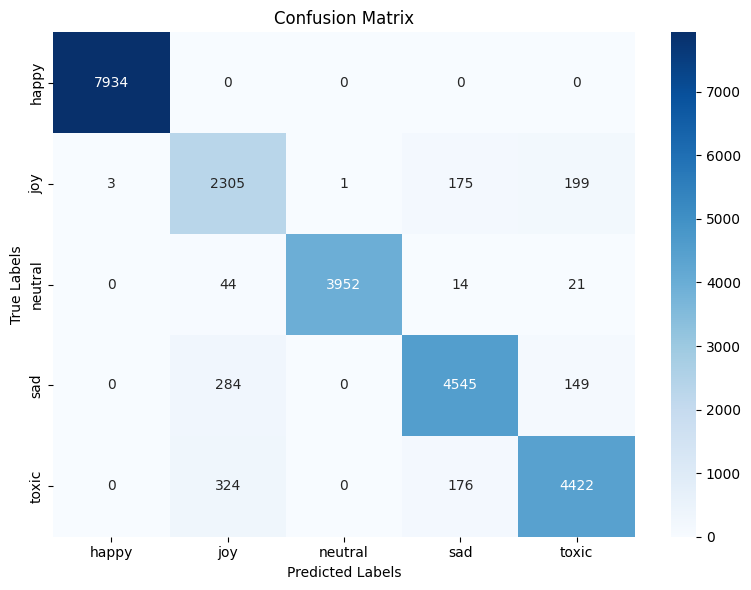

In [2]:

# Classification report
used_labels = sorted(unique_labels(labels, predictions))
used_class_names = [str(label_encoder.classes_[i]) for i in used_labels]

report = classification_report(
    labels, predictions,
    labels=used_labels,
    target_names=used_class_names,
    zero_division=0
)
print(" Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(labels, predictions, labels=used_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=used_class_names, yticklabels=used_class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
